In [344]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [361]:
start_year = 2014
end_year = 2024

# load and concat WRDS data for all years
wrds_data = []
for year in range(start_year, end_year + 1):
    df_year = pd.read_csv(f'Data/sp500_cleaned_{year}.csv')
    wrds_data.append(df_year)

wrds_file = pd.concat(wrds_data, ignore_index=True)

In [362]:
# drop columns with nan values
wrds_file = wrds_file.dropna(axis=1)
wrds_file["date"] = pd.to_datetime(wrds_file["date"])
print(wrds_file.isna().sum().sum()) # should be 0; else something's wrong
print(wrds_file.shape)
print("Unique tickers:", wrds_file['ticker'].nunique())


cols_to_drop = set()
# all 6m return columns
for col in wrds_file.columns:
    if '6' in col or "SMA" in col:
        cols_to_drop.add(col)

cols_to_drop.add('ret_3m')
cols_to_drop.add('ret_6m')
wrds_file.drop(columns=list(cols_to_drop), inplace=True)

0
(52162, 66)
Unique tickers: 595


In [363]:
# 

In [364]:
# wrds_file

In [365]:
# wrds_file.describe()

Heatmap

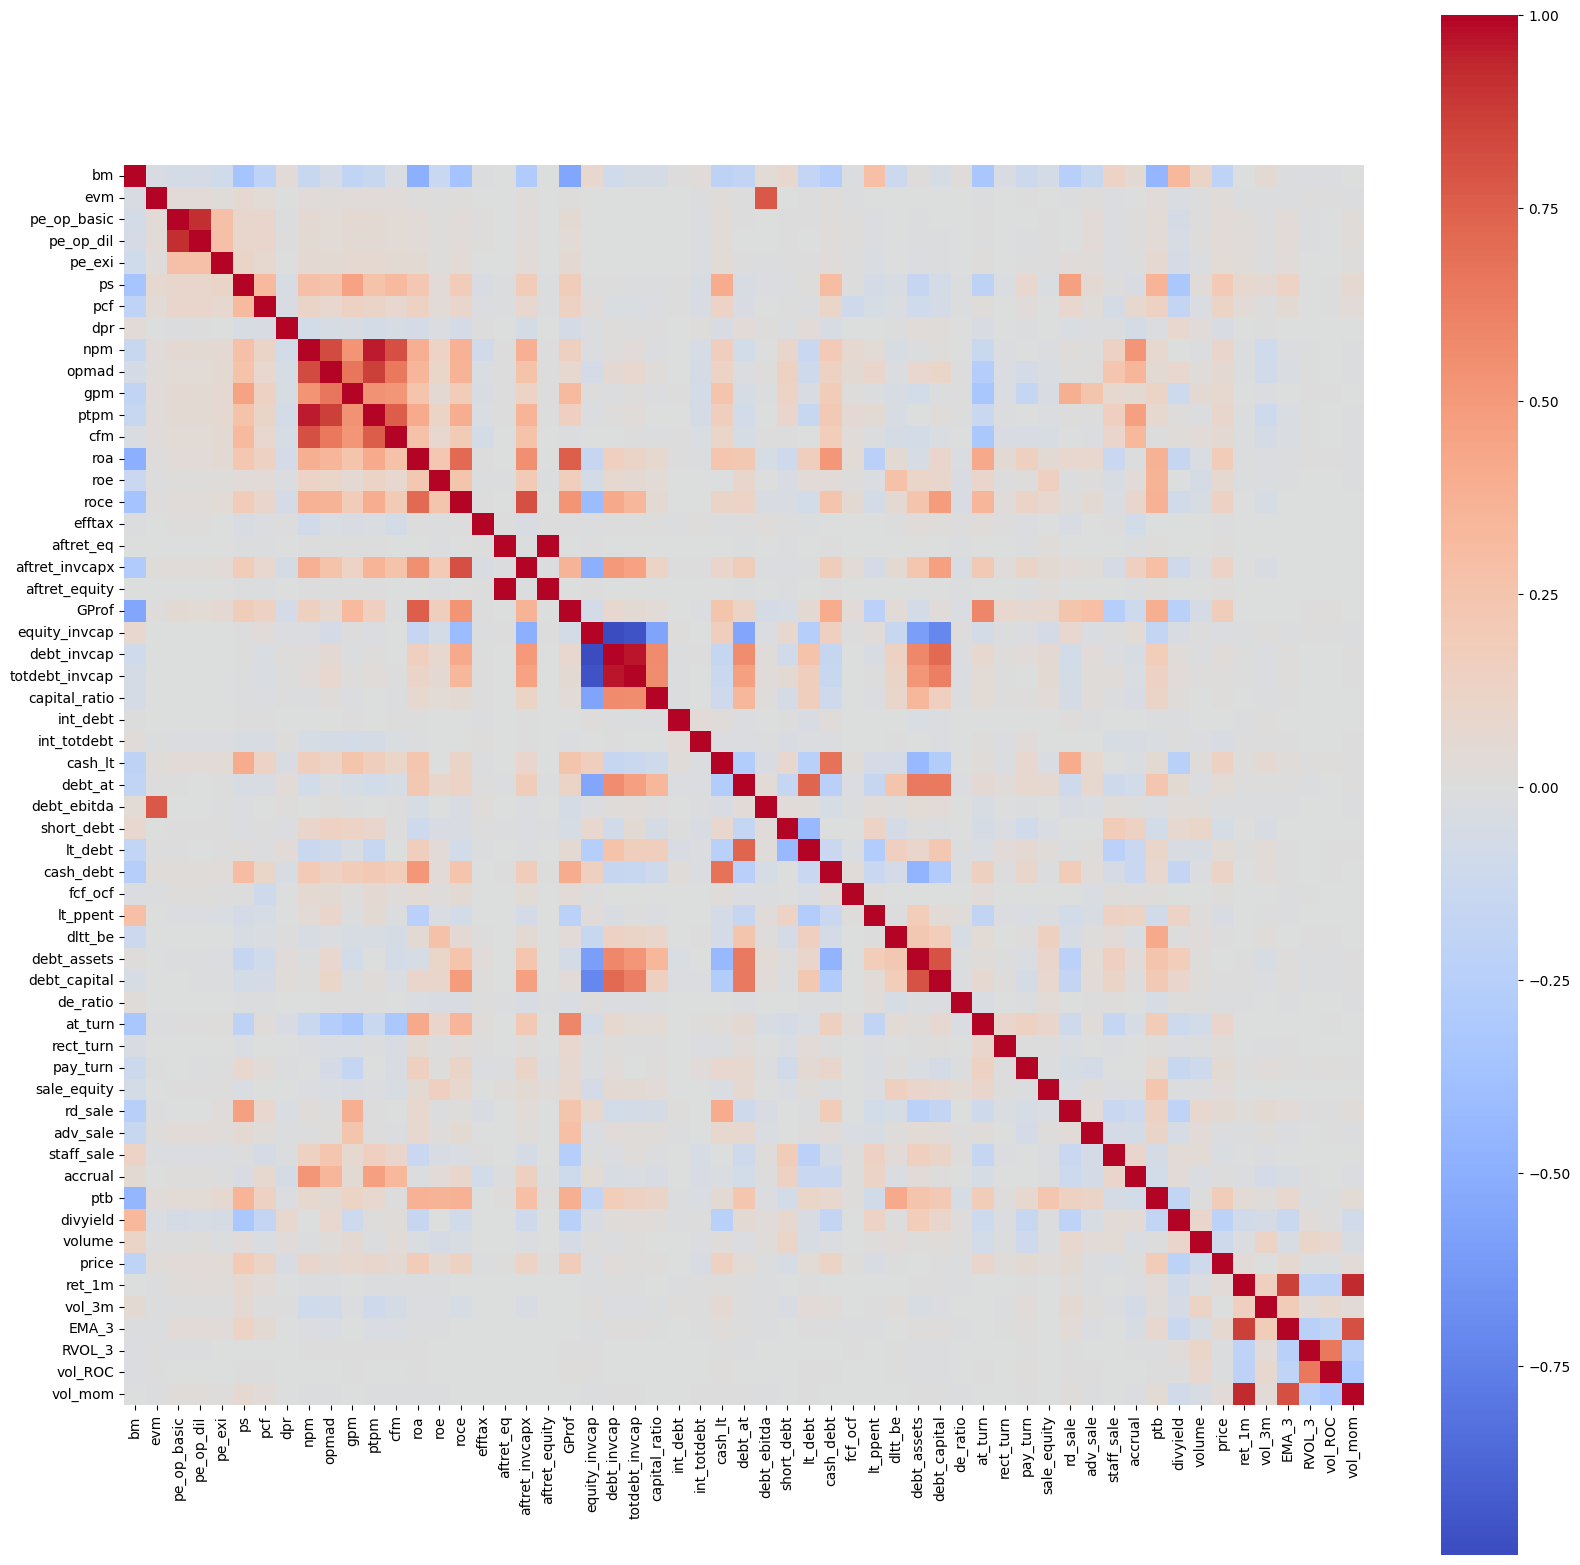

In [366]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))   
cols = wrds_file.select_dtypes(include='number').columns     # increase size
sns.heatmap(wrds_file[cols].corr(), 
            cmap='coolwarm', 
            square=True)
plt.show()


In [316]:
# find highly correlated features greater than 0.9
corr_matrix = wrds_file[cols].corr().abs()
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [(col1, col2, upper.loc[col1, col2]) for col1 in upper.columns for col2 in upper.columns
    if (col1 != col2) and pd.notna(upper.loc[col1, col2]) and (upper.loc[col1, col2] > threshold)]

len(high_corr_pairs)
# high_corr_pairs

10

In [317]:
# cols
# cols_to_drop = ['ret_3m', 'ret_6m']

In [318]:
# aftret_eq',  'aftret_equity'
# correlation bw calculate
# print(corr_matrix.loc['EMA_3', 'EMA_6'])

In [ ]:
# protected = {"ret_1m", "SMA_3"}        # columns we must NOT drop
# to_drop = set()

# for col1, col2, corr_val in high_corr_pairs:
#     # Skip pairs if already dropped
#     if col1 in to_drop or col2 in to_drop:
#         continue

#     # Case 1: col1 is protected → drop col2
#     if col1 in protected and col2 not in protected:
#         to_drop.add(col2)
#         continue

#     # Case 2: col2 is protected → drop col1
#     if col2 in protected and col1 not in protected:
#         to_drop.add(col1)
#         continue

#     # Case 3: none protected → drop the second feature by default
#     if col1 not in protected and col2 not in protected:
#         to_drop.add(col2)

# wrds_file = wrds_file.drop(columns=list(to_drop))
# print("Dropped columns:", to_drop)


Dropped columns: {'debt_invcap', 'SMA_6', 'vol_mom', 'EMA_6', 'totdebt_invcap', 'ret_3m', 'pe_op_dil', 'aftret_equity', 'ptpm'}


In [367]:
spy = pd.read_csv('Data/SPY.csv') # Date, SPY
spy["Date"] = pd.to_datetime(spy["Date"])
spy["market_ret"] = spy["SPY"].pct_change()
spy.rename(columns={"Date": "date"}, inplace=True) # rename Date to date for merging
spy = spy[['date', 'market_ret']].dropna()
spy.head()

,date,market_ret
1,2010-02-28,0.029145
2,2010-03-31,0.055920
3,2010-04-30,0.015922
4,2010-05-31,-0.080875
5,2010-06-30,-0.056597


In [368]:
# join wrds_file with spy returns on date
wrds_file = wrds_file.merge(spy, on='date', how='left')


In [369]:
wrds_file.isna().sum().sum() # should be 0; else something's wrong

0

In [370]:
df = wrds_file.copy()
df.columns

Index(['date', 'ticker', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi',
       'ps', 'pcf', 'dpr', 'npm', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'debt_at',
       'debt_ebitda', 'short_debt', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'at_turn', 'rect_turn', 'pay_turn', 'sale_equity', 'rd_sale',
       'adv_sale', 'staff_sale', 'accrual', 'ptb', 'divyield', 'volume',
       'price', 'ret_1m', 'vol_3m', 'EMA_3', 'RVOL_3', 'vol_ROC', 'vol_mom',
       'market_ret'],
      dtype='object')

# Regression

In [324]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [325]:
# drop prices columns
df = df.drop(columns=['price']) # 'ret_3m', 'ret_6m'?

In [326]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date','ticker'])

factor_cols = [c for c in df.columns  if c not in ['date','ticker','market_ret','ret_1m']]

# Cross-sectional standardization by date [these are Betas]
df[factor_cols] = df.groupby('date')[factor_cols].transform(
    lambda x: (x - x.mean()) / x.std()
)


In [327]:
print(f"Data shape: {df.shape}")

Data shape: (52162, 57)


In [328]:
train = df[(df['date'] >= "2014-01-01") & (df['date'] <= "2022-01-01")]
val   = df[(df['date'] >= "2022-01-01") & (df['date'] <= "2022-12-31")]
test  = df[(df['date'] >= "2022-12-31") & (df['date'] <= "2024-12-31")]
# print("Train shape:", train.shape)
# print("Val shape:", val.shape)
# print("Test shape:", test.shape)


In [329]:
# for each stock, regress against market
alpha = {}
betas = {}
residuals = []

for ticker, grp in train.groupby('ticker'):
    if grp.shape[0] < 12:
        continue
    
    X = grp[['market_ret']].values
    y = grp['ret_1m'].values
    
    reg = LinearRegression().fit(X, y)
    beta_i = reg.coef_[0]
    
    betas[ticker] = beta_i
    alpha[ticker] = reg.intercept_
    # compute residuals
    eps = y - reg.predict(X)
    
    tmp = grp[['date','ticker']].copy()
    tmp['eps'] = eps
    residuals.append(tmp)

residuals = pd.concat(residuals)
train = train.merge(residuals, on=['date','ticker'], how='left')


In [330]:
from collections import defaultdict

gamma_time_series = defaultdict(list)
dates_used = []

for dt, grp in train.groupby('date'): # yaha group by date
    grp = grp.dropna(subset=['eps'] + factor_cols)
    if grp.shape[0] < len(factor_cols) + 10: # arbitary
        continue
    
    X = grp[factor_cols].values
    y = grp['eps'].values
    
    reg = LinearRegression().fit(X, y)
    
    for i, fc in enumerate(factor_cols):
        gamma_time_series[fc].append(reg.coef_[i])
    
    dates_used.append(dt)

T = len(dates_used)


In [331]:
len(gamma_time_series.keys())

53

In [332]:
gamma_bar = {}
t_stats = {}

for fc in factor_cols:
    arr = np.array(gamma_time_series[fc])
    gamma_bar[fc] = arr.mean()
    t_stats[fc] = gamma_bar[fc] / (arr.std(ddof=1) / np.sqrt(T))


In [333]:
selected = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]
print("Selected factors:", len(selected))
print("Selected factors:", selected)


Selected factors: 20
Selected factors: ['bm', 'evm', 'pe_exi', 'pcf', 'npm', 'cfm', 'dltt_be', 'rect_turn', 'sale_equity', 'rd_sale', 'adv_sale', 'ptb', 'divyield', 'volume', 'ret_6m', 'SMA_3', 'EMA_3', 'RVOL_3', 'RVOL_6', 'vol_ROC']


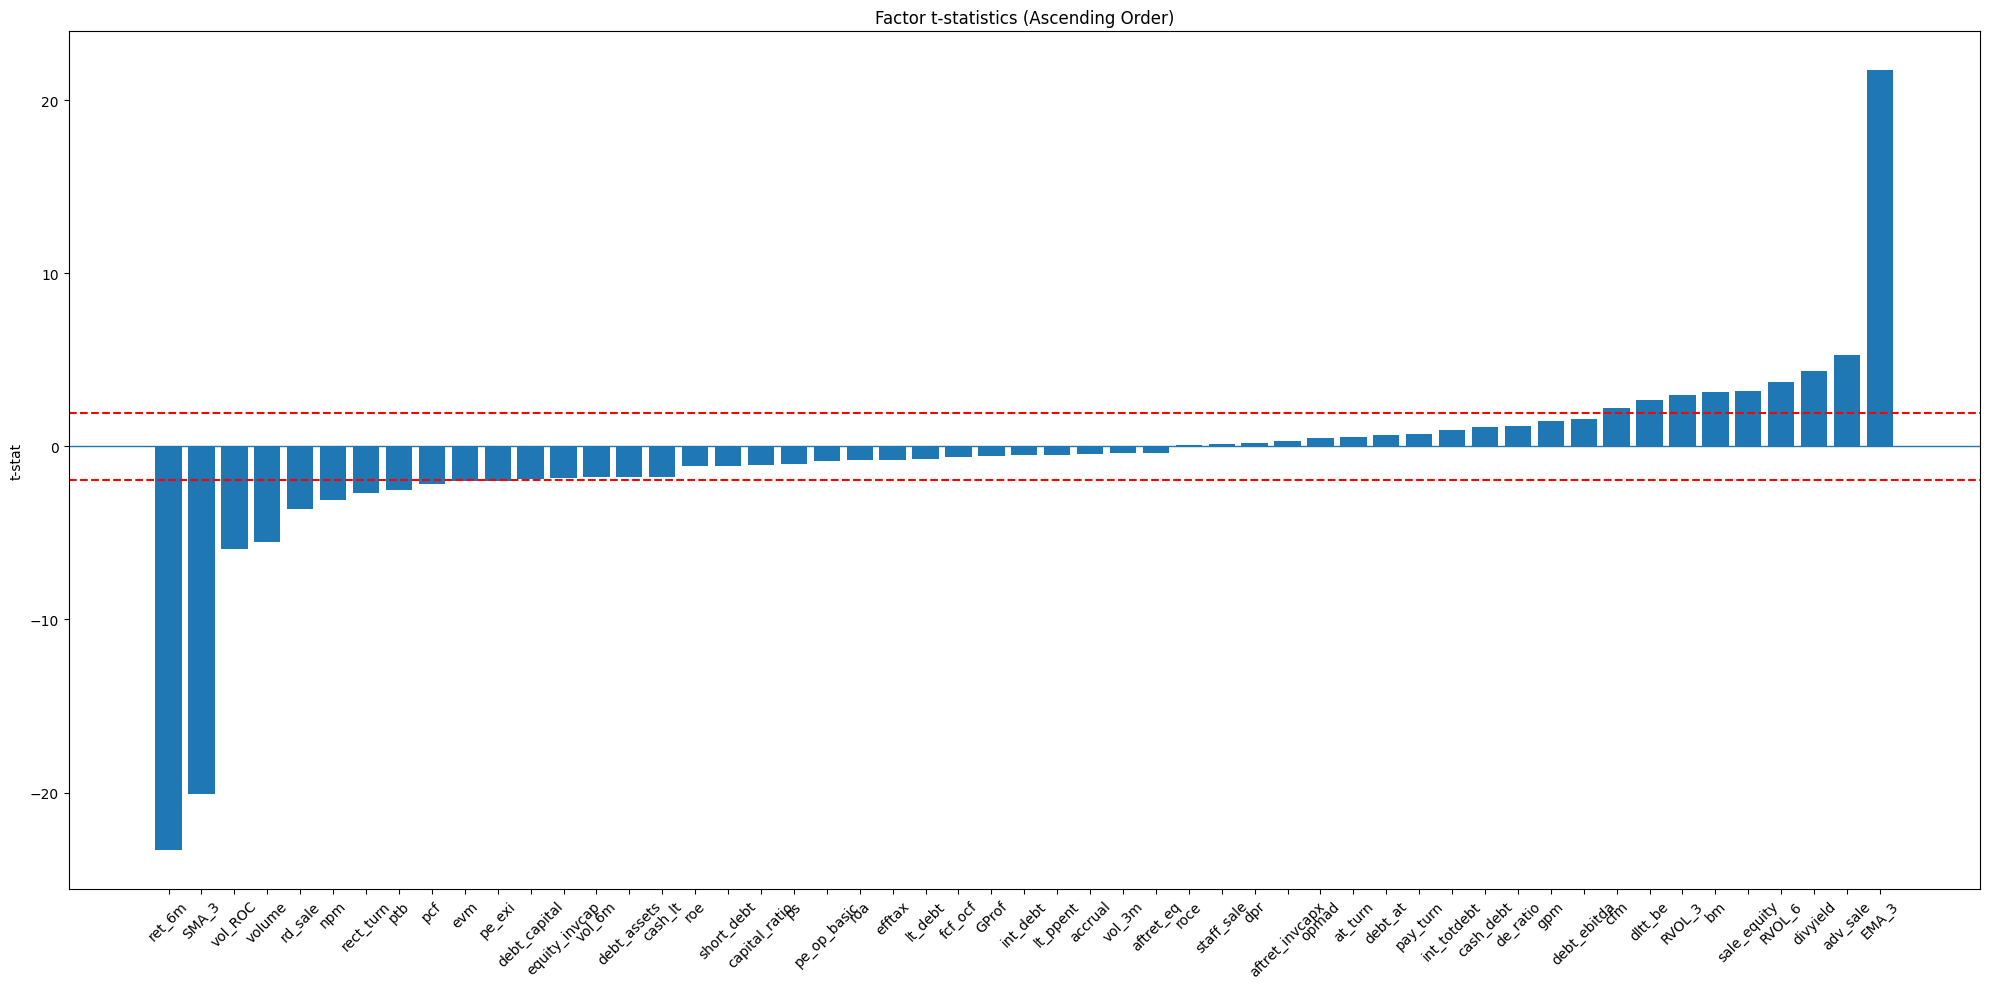

In [334]:
import matplotlib.pyplot as plt

# Sort by ascending t-stat
sorted_items = sorted(t_stats.items(), key=lambda x: x[1])

# Unpack sorted factors and values
factors = [item[0] for item in sorted_items]
values  = [item[1] for item in sorted_items]

plt.figure(figsize=(20,10))
plt.bar(factors, values)
plt.axhline(0, linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', label='t=1.96')
plt.axhline(-1.96, color='red', linestyle='--')

plt.title("Factor t-statistics (Ascending Order)")
plt.ylabel("t-stat")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [335]:
gamma_star = defaultdict(list)

for dt, grp in train.groupby('date'):
    grp = grp.dropna(subset=['eps'] + selected)
    
    if grp.shape[0] < len(selected) + 3:
        continue
    
    X = grp[selected].values
    y = grp['eps'].values
    
    reg = LinearRegression().fit(X, y)
    
    for i, fc in enumerate(selected):
        gamma_star[fc].append(reg.coef_[i])


In [336]:
gamma_bar_star = {fc: np.mean(gamma_star[fc]) for fc in selected}
print("Final factor premia")

for fc, val in gamma_bar_star.items():
    print(f"{fc}: {val:.6f}")


Final factor premia
bm: 0.000593
evm: -0.000510
pe_exi: -0.000575
pcf: -0.000570
npm: -0.001565
cfm: 0.001347
dltt_be: 0.001012
rect_turn: -0.000350
sale_equity: 0.000904
rd_sale: -0.001557
adv_sale: 0.001168
ptb: -0.001492
divyield: 0.001711
volume: -0.001538
ret_6m: -0.018390
SMA_3: -0.052747
EMA_3: 0.121384
RVOL_3: 0.002598
RVOL_6: 0.001746
vol_ROC: -0.003772


In [337]:
# # ========================================
# # COMPLETE LONG/SHORT PORTFOLIO STRATEGY
# # WITH VALIDATION-BASED HYPERPARAMETER TUNING
# # ========================================

# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from collections import defaultdict
# import matplotlib.pyplot as plt
# from itertools import product

# # ========================================
# # DATA PREPARATION
# # ========================================

# df = wrds_file.copy()
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(['date', 'ticker'])

# # Drop price column
# df = df.drop(columns=['price'])

# # Identify factor columns
# factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

# print(f"Total factors: {len(factor_cols)}")
# print(f"Data shape: {df.shape}")
# print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# # Split data
# train = df[(df['date'] >= "2015-01-01") & (df['date'] <= "2022-01-01")]
# val   = df[(df['date'] >= "2022-01-01") & (df['date'] <= "2022-12-31")]
# test  = df[(df['date'] >= "2022-12-31") & (df['date'] <= "2024-12-31")]

# print(f"\nTrain: {train.shape}")
# print(f"Val: {val.shape}")
# print(f"Test: {test.shape}")

# # ========================================
# # RISK-FREE RATE SETUP
# # ========================================
# # Using approximate 3-month Treasury bill rate (monthly)
# risk_free_monthly = (1+0.04)**(1/12) - 1 # ~0.24% annual (typical 2024 T-bill yield)
# print(f"\nUsing risk-free rate: {risk_free_monthly*100:.3f}% monthly ({((1+risk_free_monthly)**12-1)*100:.2f}% annual)")

# # ========================================
# # STEP 1: TIME SERIES REGRESSION (PER STOCK)
# # Regress each stock's returns on market returns
# # r_i,t = alpha_i + beta_i * r_m,t + eps_i,t
# # ========================================

# print("\n" + "="*60)
# print("STEP 1: Time Series Regression (Per Stock)")
# print("="*60)

# alpha_dict = {}
# beta_dict = {}
# residuals_list = []

# for ticker, grp in train.groupby('ticker'):
#     # Need sufficient observations
#     if grp.shape[0] < 12:
#         continue
    
#     # Drop any NaN values
#     grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
#     if grp_clean.shape[0] < 12:
#         continue
    
#     X = grp_clean[['market_ret']].values
#     y = grp_clean['ret_1m'].values
    
#     # Fit: r_i,t = alpha_i + beta_i * r_m,t + eps_i,t
#     reg = LinearRegression().fit(X, y)
    
#     alpha_dict[ticker] = reg.intercept_
#     beta_dict[ticker] = reg.coef_[0]
    
#     # Compute residuals
#     eps = y - reg.predict(X)
    
#     # Store residuals with date/ticker
#     tmp = grp_clean[['date', 'ticker']].copy()
#     tmp['eps'] = eps
#     residuals_list.append(tmp)

# # Merge residuals back to training data
# residuals_df = pd.concat(residuals_list, ignore_index=True)
# train = train.merge(residuals_df, on=['date', 'ticker'], how='left')

# print(f"Number of stocks with residuals: {len(alpha_dict)}")
# print(f"Training data with residuals: {train['eps'].notna().sum()} / {len(train)}")

# # ========================================
# # STEP 2: CROSS-SECTIONAL REGRESSION (PER TIME PERIOD)
# # For each date, regress residuals on normalized factors
# # eps_i,t = alpha_t + sum(gamma_k,t * factor_k,i,t) + u_i,t
# # ========================================

# print("\n" + "="*60)
# print("STEP 2: Cross-Sectional Regression (Per Date)")
# print("="*60)

# gamma_time_series = defaultdict(list)
# dates_used = []

# for dt, grp in train.groupby('date'):
#     # Drop rows with missing residuals or factors
#     grp_clean = grp.dropna(subset=['eps'] + factor_cols)
    
#     # Need enough observations
#     if grp_clean.shape[0] < len(factor_cols) + 10:
#         continue
    
#     # CRITICAL: Normalize factors cross-sectionally at time t
#     X_raw = grp_clean[factor_cols].copy()
#     X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
#     # Check for any remaining NaN/inf
#     if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
#         continue
    
#     y = grp_clean['eps'].values
    
#     # Regress: eps_i,t = alpha_t + sum(gamma_k,t * factor_k,i,t) + u_i,t
#     reg = LinearRegression().fit(X_normalized.values, y)
    
#     # Store gamma coefficients for each factor
#     for i, fc in enumerate(factor_cols):
#         gamma_time_series[fc].append(reg.coef_[i])
    
#     dates_used.append(dt)

# T = len(dates_used)
# print(f"Number of time periods used: {T}")
# print(f"Number of factors: {len(factor_cols)}")

# # ========================================
# # STEP 3: FACTOR SELECTION
# # Compute t-statistics and select significant factors
# # t-stat = gamma_bar / (gamma_std / sqrt(T))
# # ========================================

# print("\n" + "="*60)
# print("STEP 3: Factor Selection")
# print("="*60)

# gamma_bar = {}
# gamma_std = {}
# t_stats = {}

# for fc in factor_cols:
#     arr = np.array(gamma_time_series[fc])
    
#     gamma_bar[fc] = arr.mean()
#     gamma_std[fc] = arr.std(ddof=1)
    
#     # t-statistic: mean / (std / sqrt(T))
#     t_stats[fc] = gamma_bar[fc] / (gamma_std[fc] / np.sqrt(T))

# # Select factors with |t-stat| > 1.96 (95% confidence)
# selected = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]

# print(f"\nSelected factors: {len(selected)} out of {len(factor_cols)}")
# print("\nTop 10 factors by |t-stat|:")
# sorted_factors = sorted(t_stats.items(), key=lambda x: abs(x[1]), reverse=True)
# for fc, tstat in sorted_factors[:10]:
#     selected_mark = "✓" if fc in selected else ""
#     print(f"  {fc:30s}: t-stat = {tstat:7.3f}  {selected_mark}")

# # Visualize t-statistics
# sorted_items = sorted(t_stats.items(), key=lambda x: x[1])
# factors_sorted = [item[0] for item in sorted_items]
# values_sorted = [item[1] for item in sorted_items]

# plt.figure(figsize=(20, 10))
# colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
# plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
# plt.axhline(0, color='black', linewidth=1)
# plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
# plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
# plt.title("Factor t-statistics (Sorted by value)", fontsize=16, fontweight='bold')
# plt.ylabel("t-statistic", fontsize=12)
# plt.xlabel("Factors", fontsize=12)
# plt.xticks(rotation=90, fontsize=6)
# plt.legend(fontsize=12)
# plt.grid(True, alpha=0.3, axis='y')
# plt.tight_layout()
# plt.show()

# # ========================================
# # STEP 4: COMPUTE FINAL FACTOR PREMIA
# # Re-run with only selected factors, get gamma_bar_star
# # ========================================

# print("\n" + "="*60)
# print("STEP 4: Compute Final Factor Premia")
# print("="*60)

# gamma_star = defaultdict(list)

# for dt, grp in train.groupby('date'):
#     grp_clean = grp.dropna(subset=['eps'] + selected)
    
#     if grp_clean.shape[0] < len(selected) + 3:
#         continue
    
#     # Normalize selected factors cross-sectionally
#     X_raw = grp_clean[selected].copy()
#     X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
#     if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
#         continue
    
#     y = grp_clean['eps'].values
    
#     reg = LinearRegression().fit(X_normalized.values, y)
    
#     for i, fc in enumerate(selected):
#         gamma_star[fc].append(reg.coef_[i])

# # Average across time: gamma_bar_star
# gamma_bar_star = {fc: np.mean(gamma_star[fc]) for fc in selected}

# print("\nFinal Factor Premia (γ̄*):")
# print("-" * 60)
# for fc in sorted(gamma_bar_star.keys(), key=lambda x: abs(gamma_bar_star[x]), reverse=True):
#     print(f"  {fc:30s}: {gamma_bar_star[fc]:8.6f}")

# # ========================================
# # PERFORMANCE METRICS FUNCTIONS
# # ========================================

# def calculate_sharpe_with_rf(returns_series, risk_free_rate, freq=12):
#     """
#     Calculate annualized Sharpe ratio using risk-free rate
    
#     Parameters:
#     -----------
#     returns_series : pd.Series
#         Portfolio returns
#     risk_free_rate : float
#         Risk-free rate per period
#     freq : int
#         Number of periods per year (12 for monthly)
    
#     Returns:
#     --------
#     float : Annualized Sharpe ratio
#     """
#     if len(returns_series) < 2:
#         return 0.0
    
#     # Calculate excess returns
#     excess_returns = returns_series - risk_free_rate
    
#     # Annualized metrics
#     annualized_excess_return = excess_returns.mean() * freq
#     annualized_volatility = returns_series.std(ddof=1) * np.sqrt(freq)
    
#     return annualized_excess_return / annualized_volatility if annualized_volatility > 0 else 0.0

# def calculate_sortino_ratio(returns_series, risk_free_rate, freq=12):
#     """
#     Calculate Sortino ratio (downside deviation only)
#     """
#     if len(returns_series) < 2:
#         return 0.0
    
#     excess_returns = returns_series - risk_free_rate
#     downside_returns = excess_returns[excess_returns < 0]
    
#     if len(downside_returns) < 2:
#         return 0.0
    
#     annualized_excess_return = excess_returns.mean() * freq
#     downside_std = downside_returns.std(ddof=1) * np.sqrt(freq)
    
#     return annualized_excess_return / downside_std if downside_std > 0 else 0.0

# def calculate_max_drawdown(portfolio_values):
#     """
#     Calculate maximum drawdown from portfolio values
#     """
#     if len(portfolio_values) < 2:
#         return 0.0
    
#     cumulative = portfolio_values
#     running_max = cumulative.expanding().max()
#     drawdown = (cumulative - running_max) / running_max
#     return drawdown.min()

# # ========================================
# # ENHANCED PORTFOLIO CONSTRUCTION FUNCTION
# # ========================================

# def build_portfolio_enhanced(data, alpha_dict, beta_dict, gamma_bar_star, selected,
#                              n_long, n_short, rebalance_freq, winsorize_pct=0.05,
#                              min_price=5.0, risk_free_rate=0.0002):
#     """
#     Build and evaluate portfolio with enhanced features
    
#     Parameters:
#     -----------
#     data : DataFrame
#         Data to evaluate on (val or test)
#     alpha_dict : dict
#         Alpha values from training
#     beta_dict : dict
#         Beta values from training
#     gamma_bar_star : dict
#         Factor premia from training
#     selected : list
#         Selected factors
#     n_long : int
#         Number of stocks to long
#     n_short : int
#         Number of stocks to short
#     rebalance_freq : int
#         Rebalancing frequency in months
#     winsorize_pct : float
#         Percentage to winsorize from top and bottom
#     min_price : float
#         Minimum stock price to include
#     risk_free_rate : float
#         Monthly risk-free rate
    
#     Returns:
#     --------
#     portfolio_df : DataFrame
#         Portfolio returns for each period
#     """
    
#     oos_data = data.copy()
#     oos_data = oos_data.sort_values(['ticker', 'date'])
    
#     all_dates = sorted(oos_data['date'].unique())
#     portfolio_returns = []
    
#     # Track current portfolio
#     current_long_tickers = None
#     current_short_tickers = None
#     months_held = 0
    
#     for i in range(len(all_dates) - 1):
#         current_date = all_dates[i]
#         next_date = all_dates[i + 1]
        
#         # Get data at time t (for portfolio formation)
#         grp_t = oos_data[oos_data['date'] == current_date].copy()
        
#         # Get data at time t+1 (for realized returns)
#         grp_t1 = oos_data[oos_data['date'] == next_date].copy()
        
#         # Apply minimum price filter if price column exists
#         if 'price' in grp_t.columns:
#             grp_t = grp_t[grp_t['price'] >= min_price]
        
#         # Skip if not enough stocks
#         if len(grp_t) < (n_long + n_short):
#             continue
        
#         # =====================================
#         # REBALANCING LOGIC
#         # =====================================
        
#         # Check if we need to rebalance
#         should_rebalance = (current_long_tickers is None) or (months_held >= rebalance_freq)
        
#         if should_rebalance:
#             # Normalize factors cross-sectionally at time t
#             for fc in factor_cols:
#                 if grp_t[fc].notna().sum() > 1:
#                     mean_val = grp_t[fc].mean()
#                     std_val = grp_t[fc].std()
#                     if std_val > 0:
#                         grp_t[fc] = (grp_t[fc] - mean_val) / std_val
#                     else:
#                         grp_t[fc] = 0
            
#             # Predict idiosyncratic component using selected factors
#             grp_t['eps_pred'] = 0.0
#             for fc in selected:
#                 grp_t['eps_pred'] += grp_t[fc].fillna(0) * gamma_bar_star[fc]
            
#             # Map alpha and beta from training
#             grp_t['alpha_i'] = grp_t['ticker'].map(alpha_dict)
#             grp_t['beta_i'] = grp_t['ticker'].map(beta_dict)
            
#             # Expected market return - use historical average
#             historical_market = oos_data[oos_data['date'] < current_date]['market_ret']
#             if len(historical_market) >= 12:
#                 grp_t['E_r_m'] = historical_market.tail(12).mean()
#             else:
#                 # If insufficient history, use risk-free rate as baseline
#                 grp_t['E_r_m'] = risk_free_rate
            
#             # Total predicted return
#             grp_t['r_pred'] = (
#                 grp_t['alpha_i'].fillna(0) + 
#                 grp_t['beta_i'].fillna(0) * grp_t['E_r_m'] + 
#                 grp_t['eps_pred']
#             )
            
#             # Drop stocks with missing predictions
#             grp_t = grp_t.dropna(subset=['r_pred', 'alpha_i', 'beta_i'])
            
#             # Apply winsorization to remove extreme predictions
#             if winsorize_pct > 0 and len(grp_t) > 10:
#                 lower_bound = grp_t['r_pred'].quantile(winsorize_pct)
#                 upper_bound = grp_t['r_pred'].quantile(1 - winsorize_pct)
#                 grp_t = grp_t[(grp_t['r_pred'] >= lower_bound) & (grp_t['r_pred'] <= upper_bound)]
            
#             if len(grp_t) < (n_long + n_short):
#                 continue
            
#             # Rank by predicted return
#             grp_t = grp_t.sort_values('r_pred', ascending=False)
            
#             # Select with buffer to account for delistings
#             buffer_factor = 1.5  # Take 50% more than needed
#             candidate_long = grp_t.head(int(n_long * buffer_factor))['ticker'].tolist()
#             candidate_short = grp_t.tail(int(n_short * buffer_factor))['ticker'].tolist()
            
#             # Check which candidates have returns in next period
#             available_next = grp_t1['ticker'].tolist()
#             current_long_tickers = [t for t in candidate_long if t in available_next][:n_long]
#             current_short_tickers = [t for t in candidate_short if t in available_next][:n_short]
            
#             # Reset counter
#             months_held = 0
        
#         # =====================================
#         # MEASURE RETURNS FOR CURRENT HOLDINGS
#         # =====================================
        
#         # Get returns at t+1 for current holdings
#         long_rets = grp_t1[grp_t1['ticker'].isin(current_long_tickers)]['ret_1m']
#         short_rets = grp_t1[grp_t1['ticker'].isin(current_short_tickers)]['ret_1m']
        
#         # Skip if we don't have enough stocks with realized returns
#         if len(long_rets) < max(1, n_long // 2) or len(short_rets) < max(1, n_short // 2):
#             # If too many stocks dropped out, force rebalance next period
#             current_long_tickers = None
#             current_short_tickers = None
#             months_held = 0
#             continue
        
#         # Calculate equal-weighted portfolio returns
#         long_ret = long_rets.mean()
#         short_ret = short_rets.mean()
#         ls_ret = long_ret - short_ret
        
#         # Calculate excess returns over risk-free rate
#         long_excess = long_ret - risk_free_rate
#         short_excess = short_ret - risk_free_rate
#         ls_excess = long_excess - short_excess
        
#         portfolio_returns.append({
#             'formation_date': current_date,
#             'return_date': next_date,
#             'long_return': long_ret,
#             'short_return': short_ret,
#             'ls_return': ls_ret,
#             'long_excess': long_excess,
#             'short_excess': short_excess,
#             'ls_excess': ls_excess,
#             'market_return': grp_t1['market_ret'].mean() if 'market_ret' in grp_t1.columns else 0,
#             'n_long': len(long_rets),
#             'n_short': len(short_rets),
#             'rebalanced': should_rebalance
#         })
        
#         # Increment months held
#         months_held += 1
    
#     portfolio_df = pd.DataFrame(portfolio_returns)
#     return portfolio_df

# # ========================================
# # STEP 5: HYPERPARAMETER TUNING ON VALIDATION SET
# # Test different combinations of:
# # - Number of stocks (n_stocks: 10, 15, 20 per leg)
# # - Rebalancing frequency (1, 2, 3 months)
# # ========================================

# print("\n" + "="*60)
# print("STEP 5: Hyperparameter Tuning on Validation Set")
# print("="*60)

# # Define hyperparameter grid
# n_stocks_options = [10, 15, 20, 30, 40, 50]
# rebalance_freq_options = [1, 2,3]

# # Store results
# tuning_results = []

# print("\nTesting hyperparameter combinations...")
# print(f"Total combinations: {len(n_stocks_options) * len(rebalance_freq_options)}")

# for n_stocks, rebalance_freq in product(n_stocks_options, rebalance_freq_options):
#     print(f"\nTesting: n_stocks={n_stocks}, rebalance_freq={rebalance_freq} months")
    
#     # Build portfolio on validation set
#     val_portfolio = build_portfolio_enhanced(
#         data=val,
#         alpha_dict=alpha_dict,
#         beta_dict=beta_dict,
#         gamma_bar_star=gamma_bar_star,
#         selected=selected,
#         n_long=n_stocks,
#         n_short=n_stocks,
#         rebalance_freq=rebalance_freq,
#         winsorize_pct=0.0,
#         min_price=5.0,
#         risk_free_rate=risk_free_monthly
#     )
    
#     if len(val_portfolio) == 0:
#         print(f"  ⚠️  No valid periods - skipping")
#         continue
    
#     # Calculate performance metrics
#     mean_return = val_portfolio['ls_return'].mean()
#     mean_excess = val_portfolio['ls_excess'].mean()
#     std_return = val_portfolio['ls_return'].std()
    
#     # Calculate Sharpe ratio with risk-free rate
#     sharpe_annual = calculate_sharpe_with_rf(
#         val_portfolio['ls_return'],
#         risk_free_rate=risk_free_monthly,
#         freq=12
#     )
    
#     # Calculate Sortino ratio
#     sortino_annual = calculate_sortino_ratio(
#         val_portfolio['ls_return'],
#         risk_free_rate=risk_free_monthly,
#         freq=12
#     )
    
#     # Cumulative return
#     cum_return = (1 + val_portfolio['ls_return']).prod() - 1
    
#     # Win rate
#     win_rate = (val_portfolio['ls_return'] > 0).sum() / len(val_portfolio)
    
#     # Max drawdown
#     cumulative_values = 100 * (1 + val_portfolio['ls_return']).cumprod()
#     max_drawdown = calculate_max_drawdown(cumulative_values)
    
#     # Number of rebalances
#     n_rebalances = val_portfolio['rebalanced'].sum()
    
#     tuning_results.append({
#         'n_stocks': n_stocks,
#         'rebalance_freq': rebalance_freq,
#         'n_periods': len(val_portfolio),
#         'mean_return': mean_return,
#         'mean_excess': mean_excess,
#         'std_return': std_return,
#         'sharpe_annual': sharpe_annual,
#         'sortino_annual': sortino_annual,
#         'cum_return': cum_return,
#         'win_rate': win_rate,
#         'max_drawdown': max_drawdown,
#         'n_rebalances': n_rebalances
#     })
    
#     print(f"  Periods: {len(val_portfolio)}")
#     print(f"  Mean return: {mean_return*100:.3f}%")
#     print(f"  Mean excess return: {mean_excess*100:.3f}%")
#     print(f"  Sharpe (annual): {sharpe_annual:.3f}")
#     print(f"  Sortino (annual): {sortino_annual:.3f}")
#     print(f"  Cum return: {cum_return*100:.2f}%")
#     print(f"  Win rate: {win_rate*100:.1f}%")
#     print(f"  Max drawdown: {max_drawdown*100:.2f}%")
#     print(f"  Rebalances: {n_rebalances}")

# # Convert to DataFrame
# tuning_df = pd.DataFrame(tuning_results)

# print("\n" + "="*60)
# print("VALIDATION RESULTS SUMMARY")
# print("="*60)
# print(tuning_df.to_string(index=False))

# # ========================================
# # SELECT BEST HYPERPARAMETERS
# # ========================================

# # Choose best based on Sharpe ratio (most common metric)
# best_idx = tuning_df['sharpe_annual'].idxmax()
# best_params = tuning_df.iloc[best_idx]

# print("\n" + "="*60)
# print("BEST HYPERPARAMETERS (Based on Sharpe Ratio)")
# print("="*60)
# print(f"Number of stocks per leg: {int(best_params['n_stocks'])}")
# print(f"Rebalancing frequency: {int(best_params['rebalance_freq'])} month(s)")
# print(f"Validation Sharpe ratio: {best_params['sharpe_annual']:.3f}")
# print(f"Validation cumulative return: {best_params['cum_return']*100:.2f}%")

# # Extract best parameters
# best_n_stocks = int(best_params['n_stocks'])
# best_rebalance_freq = int(best_params['rebalance_freq'])

# # ========================================
# # VISUALIZE VALIDATION RESULTS
# # ========================================

# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# # -----------------------------------------------------
# # Plot 1: Sharpe Ratio Heatmap
# # -----------------------------------------------------
# pivot_sharpe = tuning_df.pivot(index='n_stocks', columns='rebalance_freq', values='sharpe_annual')
# im1 = axes[0].imshow(pivot_sharpe.values, cmap='RdYlGn', aspect='auto')
# axes[0].set_xticks(range(len(pivot_sharpe.columns)))
# axes[0].set_yticks(range(len(pivot_sharpe.index)))
# axes[0].set_xticklabels(pivot_sharpe.columns)
# axes[0].set_yticklabels(pivot_sharpe.index)
# axes[0].set_xlabel('Rebalancing Frequency (months)')
# axes[0].set_ylabel('Number of Stocks')
# axes[0].set_title('Sharpe Ratio (Annualized, with Rf)')
# for i in range(len(pivot_sharpe.index)):
#     for j in range(len(pivot_sharpe.columns)):
#         axes[0].text(j, i, f'{pivot_sharpe.values[i, j]:.2f}',
#                      ha="center", va="center", color="black", fontweight='bold')
# plt.colorbar(im1, ax=axes[0])


# # -----------------------------------------------------
# # Plot 2: Cumulative Return Heatmap
# # -----------------------------------------------------
# pivot_cum = tuning_df.pivot(index='n_stocks', columns='rebalance_freq', values='cum_return')
# im2 = axes[1].imshow(pivot_cum.values * 100, cmap='RdYlGn', aspect='auto')
# axes[1].set_xticks(range(len(pivot_cum.columns)))
# axes[1].set_yticks(range(len(pivot_cum.index)))
# axes[1].set_xticklabels(pivot_cum.columns)
# axes[1].set_yticklabels(pivot_cum.index)
# axes[1].set_xlabel('Rebalancing Frequency (months)')
# axes[1].set_ylabel('Number of Stocks')
# axes[1].set_title('Cumulative Return (%)')
# for i in range(len(pivot_cum.index)):
#     for j in range(len(pivot_cum.columns)):
#         axes[1].text(j, i, f'{pivot_cum.values[i, j]*100:.1f}%',
#                      ha="center", va="center", color="black", fontweight='bold')
# plt.colorbar(im2, ax=axes[1])


# # -----------------------------------------------------
# # Plot 3: Max Drawdown Heatmap
# # -----------------------------------------------------
# pivot_dd = tuning_df.pivot(index='n_stocks', columns='rebalance_freq', values='max_drawdown')
# im4 = axes[2].imshow(pivot_dd.values * 100, cmap='RdYlGn_r', aspect='auto')
# axes[2].set_xticks(range(len(pivot_dd.columns)))
# axes[2].set_yticks(range(len(pivot_dd.index)))
# axes[2].set_xticklabels(pivot_dd.columns)
# axes[2].set_yticklabels(pivot_dd.index)
# axes[2].set_xlabel('Rebalancing Frequency (months)')
# axes[2].set_ylabel('Number of Stocks')
# axes[2].set_title('Max Drawdown (%)')
# for i in range(len(pivot_dd.index)):
#     for j in range(len(pivot_dd.columns)):
#         axes[2].text(j, i, f'{pivot_dd.values[i, j]*100:.1f}%',
#                      ha="center", va="center", color="black", fontweight='bold')
# plt.colorbar(im4, ax=axes[2])


# # -----------------------------------------------------
# plt.suptitle('Validation Set: Hyperparameter Performance', fontsize=16, fontweight='bold')
# plt.tight_layout()
# plt.show()


# # ========================================
# # STEP 6: FINAL EVALUATION ON TEST SET
# # Using best hyperparameters from validation
# # ========================================

# print("\n" + "="*60)
# print("STEP 6: Final Evaluation on Test Set")
# print("="*60)
# print(f"Using best parameters: n_stocks={best_n_stocks}, rebalance_freq={best_rebalance_freq}")

# test_portfolio = build_portfolio_enhanced(
#     data=test,
#     alpha_dict=alpha_dict,
#     beta_dict=beta_dict,
#     gamma_bar_star=gamma_bar_star,
#     selected=selected,
#     n_long=best_n_stocks,
#     n_short=best_n_stocks,
#     rebalance_freq=best_rebalance_freq,
#     winsorize_pct=0.05,
#     min_price=5.0,
#     risk_free_rate=risk_free_monthly
# )

# if len(test_portfolio) == 0:
#     print("\n⚠️  ERROR: No portfolio returns generated on test set!")
# else:
#     # ========================================
#     # PERFORMANCE METRICS
#     # ========================================
    
#     initial_investment = 100
    
#     # Create portfolio values starting from $100
#     test_portfolio['portfolio_value_ls'] = initial_investment
#     test_portfolio['portfolio_value_long'] = initial_investment
#     test_portfolio['portfolio_value_short'] = initial_investment
    
#     for i in range(len(test_portfolio)):
#         if i == 0:
#             test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_ls'] = initial_investment * (1 + test_portfolio.loc[test_portfolio.index[i], 'ls_return'])
#             test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_long'] = initial_investment * (1 + test_portfolio.loc[test_portfolio.index[i], 'long_return'])
#             test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_short'] = initial_investment * (1 + test_portfolio.loc[test_portfolio.index[i], 'short_return'])
#         else:
#             test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_ls'] = test_portfolio.loc[test_portfolio.index[i-1], 'portfolio_value_ls'] * (1 + test_portfolio.loc[test_portfolio.index[i], 'ls_return'])
#             test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_long'] = test_portfolio.loc[test_portfolio.index[i-1], 'portfolio_value_long'] * (1 + test_portfolio.loc[test_portfolio.index[i], 'long_return'])
#             test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_short'] = test_portfolio.loc[test_portfolio.index[i-1], 'portfolio_value_short'] * (1 + test_portfolio.loc[test_portfolio.index[i], 'short_return'])
    
#     final_value_ls = test_portfolio['portfolio_value_ls'].iloc[-1]
#     final_value_long = test_portfolio['portfolio_value_long'].iloc[-1]
#     final_value_short = test_portfolio['portfolio_value_short'].iloc[-1]
    
#     total_return_ls = (final_value_ls - initial_investment) / initial_investment * 100
#     total_return_long = (final_value_long - initial_investment) / initial_investment * 100
#     total_return_short = (final_value_short - initial_investment) / initial_investment * 100
    
#     n_months = len(test_portfolio)
#     n_years = n_months / 12
    
#     if n_years > 0:
#         annualized_return_ls = (final_value_ls / initial_investment) ** (1/n_years) - 1
#         annualized_return_long = (final_value_long / initial_investment) ** (1/n_years) - 1
#         annualized_return_short = (final_value_short / initial_investment) ** (1/n_years) - 1
#     else:
#         annualized_return_ls = 0
#         annualized_return_long = 0
#         annualized_return_short = 0
    
#     print("\n" + "="*60)
#     print("TEST SET PERFORMANCE")
#     print("="*60)
    
#     print(f"\nStarting Investment: ${initial_investment:.2f}")
#     print(f"Investment Period: {n_months} months ({n_years:.2f} years)")
#     print(f"From: {test_portfolio['return_date'].min()}")
#     print(f"To:   {test_portfolio['return_date'].max()}")
    
#     print(f"\n💰 FINAL PORTFOLIO VALUES:")
#     print(f"  L/S Portfolio:  ${final_value_ls:,.2f}  ({total_return_ls:+.2f}%)")
#     print(f"  Long Only:      ${final_value_long:,.2f}  ({total_return_long:+.2f}%)")
#     print(f"  Short Only:     ${final_value_short:,.2f}  ({total_return_short:+.2f}%)")
    
#     # Enhanced performance metrics with risk-free rate
#     sharpe_annual = calculate_sharpe_with_rf(
#         test_portfolio['ls_return'],
#         risk_free_rate=risk_free_monthly,
#         freq=12
#     )
    
#     sortino_annual = calculate_sortino_ratio(
#         test_portfolio['ls_return'],
#         risk_free_rate=risk_free_monthly,
#         freq=12
#     )
    
#     print(f"\n📊 PERFORMANCE METRICS (with {risk_free_monthly*100:.3f}% monthly risk-free rate):")
#     print(f"  Mean Monthly Return: {test_portfolio['ls_return'].mean()*100:.3f}%")
#     print(f"  Mean Monthly Excess Return: {test_portfolio['ls_excess'].mean()*100:.3f}%")
#     print(f"  Volatility (monthly): {test_portfolio['ls_return'].std()*100:.3f}%")
#     print(f"  Sharpe Ratio (annualized, with Rf): {sharpe_annual:.3f}")
#     print(f"  Sortino Ratio (annualized): {sortino_annual:.3f}")
#     print(f"  Annualized Return: {annualized_return_ls*100:+.2f}%")
    
#     # Information Ratio (if market returns available)
#     if 'market_return' in test_portfolio.columns:
#         active_returns = test_portfolio['ls_return'] - test_portfolio['market_return']
#         if active_returns.std() > 0:
#             information_ratio = (active_returns.mean() * 12) / (active_returns.std() * np.sqrt(12))
#             print(f"  Information Ratio (vs Market): {information_ratio:.3f}")
    
#     win_rate = (test_portfolio['ls_return'] > 0).sum() / len(test_portfolio)
#     print(f"  Win Rate: {win_rate*100:.1f}%")
    
#     # Max drawdown
#     cumulative = test_portfolio['portfolio_value_ls']
#     running_max = cumulative.expanding().max()
#     drawdown = (cumulative - running_max) / running_max
#     max_drawdown = drawdown.min()
#     print(f"  Max Drawdown: {max_drawdown*100:.2f}%")
    
#     n_rebalances = test_portfolio['rebalanced'].sum()
#     print(f"  Number of Rebalances: {n_rebalances}")
    
#     # ========================================
#     # VISUALIZATION: $100 INVESTMENT GROWTH
#     # ========================================
    
#     fig = plt.figure(figsize=(16, 12))
#     gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)
    
#     # Plot 1: Main Portfolio Value Chart
#     ax1 = fig.add_subplot(gs[0:2, :])
    
#     dates_with_initial = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
#     values_ls_with_initial = [initial_investment] + test_portfolio['portfolio_value_ls'].tolist()
#     values_long_with_initial = [initial_investment] + test_portfolio['portfolio_value_long'].tolist()
#     values_short_with_initial = [initial_investment] + test_portfolio['portfolio_value_short'].tolist()
    
#     ax1.plot(dates_with_initial, values_ls_with_initial, 
#              linewidth=3, label='L/S Portfolio', color='#2E86AB', marker='o', markersize=4)
#     ax1.plot(dates_with_initial, values_long_with_initial, 
#              linewidth=2, label='Long Leg Only', alpha=0.7, color='#06A77D', linestyle='--')
#     ax1.plot(dates_with_initial, values_short_with_initial, 
#              linewidth=2, label='Short Leg Only', alpha=0.7, color='#D62246', linestyle='--')
    
#     ax1.axhline(initial_investment, color='black', linestyle=':', 
#                 linewidth=2, alpha=0.6, label=f'Initial Investment (${initial_investment})')
    
#     ax1.fill_between(dates_with_initial, 
#                      initial_investment, 
#                      values_ls_with_initial,
#                      where=(np.array(values_ls_with_initial) >= initial_investment),
#                      alpha=0.2, color='green', label='Profit Region')
#     ax1.fill_between(dates_with_initial, 
#                      initial_investment, 
#                      values_ls_with_initial,
#                      where=(np.array(values_ls_with_initial) < initial_investment),
#                      alpha=0.2, color='red', label='Loss Region')
    
#     # Mark rebalancing points
#     rebalance_dates = test_portfolio[test_portfolio['rebalanced']]['return_date']
#     rebalance_values = test_portfolio[test_portfolio['rebalanced']]['portfolio_value_ls']
#     ax1.scatter(rebalance_dates, rebalance_values, color='orange', s=100, 
#                 marker='v', zorder=5, label='Rebalance Points', edgecolors='black', linewidth=1)
    
#     ax1.annotate(f'Start: ${initial_investment:.2f}', 
#                 xy=(dates_with_initial[0], initial_investment),
#                 xytext=(-10, -30), textcoords='offset points',
#                 bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
#                 fontsize=11, fontweight='bold',
#                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))
    
#     ax1.annotate(f'Final: ${final_value_ls:.2f}\n({total_return_ls:+.1f}%)', 
#                 xy=(dates_with_initial[-1], final_value_ls),
#                 xytext=(10, 10), textcoords='offset points',
#                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
#                 fontsize=11, fontweight='bold',
#                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
#     ax1.set_title(f'Test Set: ${initial_investment} Investment (n_stocks={best_n_stocks}, rebalance={best_rebalance_freq}mo)', 
#                   fontsize=16, fontweight='bold', pad=20)
#     ax1.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
#     ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
#     ax1.legend(loc='best', fontsize=9, framealpha=0.9)
#     ax1.grid(True, alpha=0.3, linestyle='--')
#     ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
#     y_min = min(min(values_ls_with_initial), min(values_long_with_initial), min(values_short_with_initial))
#     y_max = max(max(values_ls_with_initial), max(values_long_with_initial), max(values_short_with_initial))
#     y_range = y_max - y_min
#     ax1.set_ylim(y_min - y_range*0.1, y_max + y_range*0.1)
    
#     # Plot 2: Monthly Returns
#     ax2 = fig.add_subplot(gs[2, :])
#     colors = ['#06A77D' if x > 0 else '#D62246' for x in test_portfolio['ls_return']]
#     bars = ax2.bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
#                    alpha=0.8, color=colors, edgecolor='black', linewidth=0.5)
    
#     best_month_idx = test_portfolio['ls_return'].idxmax()
#     worst_month_idx = test_portfolio['ls_return'].idxmin()
#     best_month_pos = test_portfolio.index.get_loc(best_month_idx)
#     worst_month_pos = test_portfolio.index.get_loc(worst_month_idx)
    
#     bars[best_month_pos].set_edgecolor('gold')
#     bars[best_month_pos].set_linewidth(3)
#     bars[worst_month_pos].set_edgecolor('darkred')
#     bars[worst_month_pos].set_linewidth(3)
    
#     ax2.axhline(0, color='black', linewidth=1)
#     ax2.set_title('Monthly Returns Distribution', fontsize=14, fontweight='bold')
#     ax2.set_xlabel('Date', fontsize=11)
#     ax2.set_ylabel('Return (%)', fontsize=11)
#     ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    
#     mean_return = test_portfolio['ls_return'].mean() * 100
#     ax2.axhline(mean_return, color='blue', linestyle='--', linewidth=2, 
#                 alpha=0.7, label=f'Mean: {mean_return:.2f}%')
#     ax2.legend(fontsize=10)
    
#     # Plot 3: Cumulative Return %
#     ax3 = fig.add_subplot(gs[3, 0])
#     cumulative_return_pct = (test_portfolio['portfolio_value_ls'] / initial_investment - 1) * 100
    
#     ax3.fill_between(test_portfolio['return_date'], 0, cumulative_return_pct,
#                      where=(cumulative_return_pct >= 0), alpha=0.3, color='green')
#     ax3.fill_between(test_portfolio['return_date'], 0, cumulative_return_pct,
#                      where=(cumulative_return_pct < 0), alpha=0.3, color='red')
#     ax3.plot(test_portfolio['return_date'], cumulative_return_pct, 
#              linewidth=2.5, color='#2E86AB')
#     ax3.axhline(0, color='black', linewidth=1, linestyle='-')
#     ax3.set_title('Cumulative Return (%)', fontsize=12, fontweight='bold')
#     ax3.set_xlabel('Date', fontsize=10)
#     ax3.set_ylabel('Return (%)', fontsize=10)
#     ax3.grid(True, alpha=0.3, linestyle='--')
    
#     # Plot 4: Drawdown
#     ax4 = fig.add_subplot(gs[3, 1])
#     running_max = test_portfolio['portfolio_value_ls'].expanding().max()
#     drawdown = (test_portfolio['portfolio_value_ls'] - running_max) / running_max * 100
    
#     ax4.fill_between(test_portfolio['return_date'], 0, drawdown, 
#                      alpha=0.6, color='#D62246')
#     ax4.plot(test_portfolio['return_date'], drawdown, 
#              linewidth=2, color='darkred')
#     ax4.axhline(0, color='black', linewidth=1)
#     ax4.set_title(f'Drawdown (Max: {drawdown.min():.2f}%)', 
#                   fontsize=12, fontweight='bold')
#     ax4.set_xlabel('Date', fontsize=10)
#     ax4.set_ylabel('Drawdown (%)', fontsize=10)
#     ax4.grid(True, alpha=0.3, linestyle='--')
    
#     plt.suptitle(f'Test Set Performance (Best Params from Validation)', 
#                  fontsize=18, fontweight='bold', y=0.995)
#     plt.tight_layout()
#     plt.show()

# print("\n" + "="*60)
# print("✅ Analysis Complete!")
# print("="*60)
# print(f"\nBest hyperparameters (from validation):")
# print(f"  - Number of stocks: {best_n_stocks} long, {best_n_stocks} short")
# print(f"  - Rebalancing: Every {best_rebalance_freq} month(s)")
# print(f"\nValidation performance:")
# print(f"  - Sharpe ratio: {best_params['sharpe_annual']:.3f}")
# print(f"  - Cumulative return: {best_params['cum_return']*100:.2f}%")
# print(f"\nTest set performance:")
# print(f"  - Sharpe ratio: {sharpe_annual:.3f}")
# print(f"  - Cumulative return: {total_return_ls:.2f}%")
# print(f"  - Final value: ${final_value_ls:.2f} from ${initial_investment}")

In [338]:
# # ========================================
# # HYBRID LONG/SHORT STRATEGY:
# # - ONE-TIME factor selection on training data
# # - ROLLING estimation of loadings & premia
# # ========================================

# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from collections import defaultdict
# import matplotlib.pyplot as plt
# from itertools import product
# import warnings
# warnings.filterwarnings('ignore')

# # ========================================
# # DATA PREPARATION
# # ========================================

# df = wrds_file.copy()
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(['date', 'ticker'])
# df = df.drop(columns=['price'], errors='ignore')

# factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

# print(f"Total factors: {len(factor_cols)}")
# print(f"Data shape: {df.shape}")
# print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# # Split data
# train_end = "2022-01-01"
# val_end = "2022-12-31"

# train = df[df['date'] < train_end]
# val = df[(df['date'] >= train_end) & (df['date'] < val_end)]
# test = df[df['date'] >= val_end]

# print(f"\nTrain: {train.shape}")
# print(f"Val: {val.shape}")
# print(f"Test: {test.shape}")

# risk_free_monthly = (1+0.04)**(1/12) - 1
# print(f"\nRisk-free rate: {risk_free_monthly*100:.3f}% monthly")

# # ========================================
# # PART 1: ONE-TIME FACTOR SELECTION
# # (Using only training data)
# # ========================================

# print("\n" + "="*60)
# print("PART 1: INITIAL FACTOR SELECTION (Training Data Only)")
# print("="*60)

# # Step 1: Estimate alphas/betas on training data
# print("\nStep 1: Time Series Regression (Alphas & Betas)")
# alpha_dict_train = {}
# beta_dict_train = {}
# residuals_list = []

# for ticker, grp in train.groupby('ticker'):
#     grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
#     if len(grp_clean) < 12:
#         continue
    
#     X = grp_clean[['market_ret']].values
#     y = grp_clean['ret_1m'].values
    
#     reg = LinearRegression().fit(X, y)
#     alpha_dict_train[ticker] = reg.intercept_
#     beta_dict_train[ticker] = reg.coef_[0]
    
#     eps = y - reg.predict(X)
#     tmp = grp_clean[['date', 'ticker']].copy()
#     tmp['eps'] = eps
#     residuals_list.append(tmp)

# residuals_df = pd.concat(residuals_list, ignore_index=True)
# train_with_eps = train.merge(residuals_df, on=['date', 'ticker'], how='left')

# print(f"Estimated α/β for {len(alpha_dict_train)} stocks")

# # Step 2: Cross-sectional regressions to get gamma time series
# print("\nStep 2: Cross-Sectional Regression")
# gamma_time_series = defaultdict(list)

# for dt, grp in train_with_eps.groupby('date'):
#     grp_clean = grp.dropna(subset=['eps'] + factor_cols)
#     if len(grp_clean) < len(factor_cols) + 10:
#         continue
    
#     X_raw = grp_clean[factor_cols].copy()
#     X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
#     if X_normalized.isnull().any().any():
#         continue
    
#     y = grp_clean['eps'].values
#     reg = LinearRegression().fit(X_normalized.values, y)
    
#     for i, fc in enumerate(factor_cols):
#         gamma_time_series[fc].append(reg.coef_[i])

# T = len(gamma_time_series[factor_cols[0]])
# print(f"Cross-sectional regressions: {T} time periods")

# # Step 3: Factor selection via t-statistics
# print("\nStep 3: Factor Selection (t-statistics)")
# t_stats = {}

# for fc in factor_cols:
#     arr = np.array(gamma_time_series[fc])
#     gamma_mean = arr.mean()
#     gamma_std = arr.std(ddof=1)
#     t_stats[fc] = gamma_mean / (gamma_std / np.sqrt(T)) if gamma_std > 0 else 0

# selected_factors = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]

# print(f"\n✓ Selected {len(selected_factors)}/{len(factor_cols)} factors (|t-stat| > 1.96)")
# print("\nTop 10 factors:")
# for fc, tstat in sorted(t_stats.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
#     mark = "✓" if fc in selected_factors else ""
#     print(f"  {fc:30s}: {tstat:7.3f} {mark}")

# # Visualize
# sorted_items = sorted(t_stats.items(), key=lambda x: x[1])
# factors_sorted = [item[0] for item in sorted_items]
# values_sorted = [item[1] for item in sorted_items]

# plt.figure(figsize=(20, 10))
# colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
# plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
# plt.axhline(0, color='black', linewidth=1)
# plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
# plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
# plt.title("Factor Selection: t-statistics on Training Data", fontsize=16, fontweight='bold')
# plt.ylabel("t-statistic", fontsize=12)
# plt.xlabel("Factors", fontsize=12)
# plt.xticks(rotation=90, fontsize=6)
# plt.legend(fontsize=12)
# plt.grid(True, alpha=0.3, axis='y')
# plt.tight_layout()
# plt.show()

# # ========================================
# # PART 2: ROLLING ESTIMATION FUNCTIONS
# # (For validation and test periods)
# # ========================================

# def estimate_alphas_betas_rolling(data, min_periods=12):
#     """Estimate α and β using available historical data"""
#     alpha_dict = {}
#     beta_dict = {}
    
#     for ticker, grp in data.groupby('ticker'):
#         grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
#         if len(grp_clean) < min_periods:
#             continue
        
#         X = grp_clean[['market_ret']].values
#         y = grp_clean['ret_1m'].values
        
#         reg = LinearRegression().fit(X, y)
#         alpha_dict[ticker] = reg.intercept_
#         beta_dict[ticker] = reg.coef_[0]
    
#     return alpha_dict, beta_dict

# def compute_residuals_rolling(data, alpha_dict, beta_dict):
#     """Compute residuals for given alphas/betas"""
#     data = data.copy()
#     data['alpha_i'] = data['ticker'].map(alpha_dict)
#     data['beta_i'] = data['ticker'].map(beta_dict)
#     data['eps'] = data['ret_1m'] - data['alpha_i'] - data['beta_i'] * data['market_ret']
#     return data

# def estimate_factor_premia_rolling(data, selected_factors, min_periods=12):
#     """Estimate factor premia using cross-sectional regressions"""
#     gamma_time_series = defaultdict(list)
    
#     for dt, grp in data.groupby('date'):
#         grp_clean = grp.dropna(subset=['eps'] + selected_factors)
#         if len(grp_clean) < len(selected_factors) + 10:
#             continue
        
#         X_raw = grp_clean[selected_factors].copy()
#         X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
        
#         if X_normalized.isnull().any().any():
#             continue
        
#         y = grp_clean['eps'].values
#         reg = LinearRegression().fit(X_normalized.values, y)
        
#         for i, fc in enumerate(selected_factors):
#             gamma_time_series[fc].append(reg.coef_[i])
    
#     if len(gamma_time_series.get(selected_factors[0], [])) < min_periods:
#         return None
    
#     gamma_bar = {fc: np.mean(gamma_time_series[fc]) for fc in selected_factors}
#     return gamma_bar

# # ========================================
# # PART 3: ROLLING PORTFOLIO CONSTRUCTION
# # ========================================

# def build_portfolio_with_rolling_estimation(
#     data, all_data, selected_factors, n_long, n_short, 
#     rebalance_freq, training_window=36, risk_free_rate=0.0002):
#     """
#     Build portfolio with rolling estimation of parameters
    
#     Key feature: Uses ONLY historical data at each point in time
#     """
    
#     oos_data = data.copy().sort_values(['ticker', 'date'])
#     all_dates = sorted(oos_data['date'].unique())
    
#     portfolio_returns = []
#     current_long = None
#     current_short = None
#     months_held = 0
    
#     for i in range(len(all_dates) - 1):
#         current_date = all_dates[i]
#         next_date = all_dates[i + 1]
        
#         # Get ONLY historical data (no lookahead!)
#         hist_data = all_data[all_data['date'] < current_date].copy()
        
#         # Apply rolling window
#         if training_window:
#             earliest_date = current_date - pd.DateOffset(months=training_window)
#             hist_data = hist_data[hist_data['date'] >= earliest_date]
        
#         # Need sufficient history
#         if len(hist_data['date'].unique()) < 24:
#             continue
        
#         grp_t = oos_data[oos_data['date'] == current_date].copy()
#         grp_t1 = oos_data[oos_data['date'] == next_date].copy()
        
#         if len(grp_t) < (n_long + n_short):
#             continue
        
#         # ===================================
#         # REBALANCING
#         # ===================================
#         should_rebalance = (current_long is None) or (months_held >= rebalance_freq)
        
#         if should_rebalance:
#             # Re-estimate alphas/betas on historical data
#             alpha_dict, beta_dict = estimate_alphas_betas_rolling(hist_data)
            
#             # Compute residuals for historical data
#             hist_with_eps = compute_residuals_rolling(hist_data, alpha_dict, beta_dict)
            
#             # Re-estimate factor premia on historical data (using SELECTED factors)
#             gamma_bar = estimate_factor_premia_rolling(hist_with_eps, selected_factors)
            
#             if gamma_bar is None or len(alpha_dict) < 50:
#                 continue
            
#             # Make predictions for current period
#             # Normalize factors cross-sectionally
#             for fc in factor_cols:
#                 if grp_t[fc].notna().sum() > 1:
#                     grp_t[fc] = (grp_t[fc] - grp_t[fc].mean()) / grp_t[fc].std()
            
#             # Predict idiosyncratic return using SELECTED factors
#             grp_t['eps_pred'] = 0.0
#             for fc in selected_factors:
#                 grp_t['eps_pred'] += grp_t[fc].fillna(0) * gamma_bar[fc]
            
#             grp_t['alpha_i'] = grp_t['ticker'].map(alpha_dict)
#             grp_t['beta_i'] = grp_t['ticker'].map(beta_dict)
            
#             # Expected market return
#             recent_market = hist_data.tail(12*100)['market_ret'].mean()
#             grp_t['E_r_m'] = recent_market if not np.isnan(recent_market) else risk_free_rate
            
#             # Total predicted return
#             grp_t['r_pred'] = (grp_t['alpha_i'].fillna(0) + 
#                               grp_t['beta_i'].fillna(0) * grp_t['E_r_m'] + 
#                               grp_t['eps_pred'])
            
#             grp_t = grp_t.dropna(subset=['r_pred', 'alpha_i', 'beta_i'])
            
#             if len(grp_t) < (n_long + n_short):
#                 continue
            
#             # Select stocks
#             grp_t = grp_t.sort_values('r_pred', ascending=False)
            
#             candidate_long = grp_t.head(int(n_long * 1.5))['ticker'].tolist()
#             candidate_short = grp_t.tail(int(n_short * 1.5))['ticker'].tolist()
            
#             available_next = grp_t1['ticker'].tolist()
#             current_long = [t for t in candidate_long if t in available_next][:n_long]
#             current_short = [t for t in candidate_short if t in available_next][:n_short]
            
#             months_held = 0
        
#         # ===================================
#         # MEASURE RETURNS
#         # ===================================
#         long_rets = grp_t1[grp_t1['ticker'].isin(current_long)]['ret_1m']
#         short_rets = grp_t1[grp_t1['ticker'].isin(current_short)]['ret_1m']
        
#         if len(long_rets) < max(1, n_long//2) or len(short_rets) < max(1, n_short//2):
#             current_long = None
#             current_short = None
#             months_held = 0
#             continue
        
#         long_ret = long_rets.mean()
#         short_ret = short_rets.mean()
#         ls_ret = long_ret - short_ret
        
#         portfolio_returns.append({
#             'formation_date': current_date,
#             'return_date': next_date,
#             'long_return': long_ret,
#             'short_return': short_ret,
#             'ls_return': ls_ret,
#             'ls_excess': ls_ret - risk_free_rate,
#             'market_return': grp_t1['market_ret'].mean(),
#             'n_long': len(long_rets),
#             'n_short': len(short_rets),
#             'rebalanced': should_rebalance
#         })
        
#         months_held += 1
    
#     return pd.DataFrame(portfolio_returns)

# # ========================================
# # PERFORMANCE METRICS
# # ========================================

# def calculate_metrics(portfolio_df, rf_rate):
#     """Calculate comprehensive performance metrics"""
#     if len(portfolio_df) == 0:
#         return None
    
#     rets = portfolio_df['ls_return']
#     excess = rets - rf_rate
    
#     sharpe = (excess.mean() * 12) / (rets.std() * np.sqrt(12)) if rets.std() > 0 else 0
    
#     downside = excess[excess < 0]
#     sortino = ((excess.mean() * 12) / (downside.std() * np.sqrt(12)) 
#                if len(downside) > 1 and downside.std() > 0 else 0)
    
#     cum_ret = (1 + rets).prod() - 1
#     cum_vals = (1 + rets).cumprod()
#     running_max = cum_vals.expanding().max()
#     max_dd = ((cum_vals - running_max) / running_max).min()
    
#     return {
#         'n_periods': len(rets),
#         'total_return': cum_ret,
#         'annualized_return': (1 + rets.mean())**12 - 1,
#         'sharpe': sharpe,
#         'sortino': sortino,
#         'max_drawdown': max_dd,
#         'win_rate': (rets > 0).mean()
#     }

# # ========================================
# # HYPERPARAMETER TUNING (VALIDATION)
# # ========================================

# print("\n" + "="*60)
# print("PART 4: HYPERPARAMETER TUNING WITH ROLLING ESTIMATION")
# print("="*60)

# n_stocks_options = [10, 25, 30, 50]
# rebalance_options = [1, 2, 3]
# window_options = [36, None]  # 36 months or expanding

# tuning_results = []

# for n_stocks, rebal, window in product(n_stocks_options, rebalance_options, window_options):
#     window_str = f"{window}mo" if window else "expanding"
#     print(f"\nTesting: n={n_stocks}, rebal={rebal}mo, window={window_str}")
    
#     val_portfolio = build_portfolio_with_rolling_estimation(
#         data=val,
#         all_data=df,
#         selected_factors=selected_factors,
#         n_long=n_stocks,
#         n_short=n_stocks,
#         rebalance_freq=rebal,
#         training_window=window,
#         risk_free_rate=risk_free_monthly
#     )
    
#     if len(val_portfolio) == 0:
#         print("  ⚠️  No results")
#         continue
    
#     perf = calculate_metrics(val_portfolio, risk_free_monthly)
    
#     tuning_results.append({
#         'n_stocks': n_stocks,
#         'rebalance': rebal,
#         'window': window_str,
#         **perf
#     })
    
#     print(f"  Sharpe: {perf['sharpe']:.3f}, Return: {perf['total_return']*100:.2f}%")

# tuning_df = pd.DataFrame(tuning_results)

# print("\n" + "="*60)
# print("VALIDATION RESULTS")
# print("="*60)
# print(tuning_df.to_string(index=False))

# # Select best
# best_idx = tuning_df['sharpe'].idxmax()
# best = tuning_df.iloc[best_idx]

# print(f"\n🏆 BEST PARAMETERS:")
# print(f"   n_stocks: {int(best['n_stocks'])}")
# print(f"   rebalance: {int(best['rebalance'])} months")
# print(f"   window: {best['window']}")
# print(f"   Validation Sharpe: {best['sharpe']:.3f}")

# # Visualize validation results
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# for window_val in tuning_df['window'].unique():
#     subset = tuning_df[tuning_df['window'] == window_val]
    
#     # Sharpe heatmap
#     pivot = subset.pivot(index='n_stocks', columns='rebalance', values='sharpe')
#     im = axes[0].imshow(pivot.values, cmap='RdYlGn', aspect='auto', alpha=0.7)
#     axes[0].set_xticks(range(len(pivot.columns)))
#     axes[0].set_yticks(range(len(pivot.index)))
#     axes[0].set_xticklabels(pivot.columns)
#     axes[0].set_yticklabels(pivot.index)
#     axes[0].set_title('Sharpe Ratio')
#     axes[0].set_xlabel('Rebalance Freq (mo)')
#     axes[0].set_ylabel('N Stocks')
#     # Add value annotations
#     for i in range(len(pivot.index)):
#         for j in range(len(pivot.columns)):
#             axes[0].text(j, i, f'{pivot.values[i, j]:.2f}',
#                         ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
#     # Return heatmap
#     pivot = subset.pivot(index='n_stocks', columns='rebalance', values='total_return')
#     axes[1].imshow(pivot.values * 100, cmap='RdYlGn', aspect='auto', alpha=0.7)
#     axes[1].set_xticks(range(len(pivot.columns)))
#     axes[1].set_yticks(range(len(pivot.index)))
#     axes[1].set_xticklabels(pivot.columns)
#     axes[1].set_yticklabels(pivot.index)
#     axes[1].set_title('Total Return (%)')
#     axes[1].set_xlabel('Rebalance Freq (mo)')
#     # Add value annotations
#     for i in range(len(pivot.index)):
#         for j in range(len(pivot.columns)):
#             axes[1].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
#                         ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
#     # Drawdown heatmap
#     pivot = subset.pivot(index='n_stocks', columns='rebalance', values='max_drawdown')
#     axes[2].imshow(pivot.values * 100, cmap='RdYlGn_r', aspect='auto', alpha=0.7)
#     axes[2].set_xticks(range(len(pivot.columns)))
#     axes[2].set_yticks(range(len(pivot.index)))
#     axes[2].set_xticklabels(pivot.columns)
#     axes[2].set_yticklabels(pivot.index)
#     axes[2].set_title('Max Drawdown (%)')
#     axes[2].set_xlabel('Rebalance Freq (mo)')
#     # Add value annotations
#     for i in range(len(pivot.index)):
#         for j in range(len(pivot.columns)):
#             axes[2].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
#                         ha="center", va="center", color="black", fontweight='bold', fontsize=10)

# plt.suptitle('Validation: Rolling Estimation Performance', fontsize=16, fontweight='bold')
# plt.tight_layout()
# plt.show()

# # ========================================
# # FINAL TEST
# # ========================================

# print("\n" + "="*60)
# print("PART 5: FINAL TEST SET EVALUATION")
# print("="*60)

# best_window = None if best['window'] == 'expanding' else int(best['window'].replace('mo', ''))

# test_portfolio = build_portfolio_with_rolling_estimation(
#     data=test,
#     all_data=df,
#     selected_factors=selected_factors,
#     n_long=int(best['n_stocks']),
#     n_short=int(best['n_stocks']),
#     rebalance_freq=int(best['rebalance']),
#     training_window=best_window,
#     risk_free_rate=risk_free_monthly
# )

# if len(test_portfolio) > 0:
#     test_perf = calculate_metrics(test_portfolio, risk_free_monthly)
    
#     print(f"\n📊 TEST SET PERFORMANCE:")
#     print(f"   Periods: {test_perf['n_periods']}")
#     print(f"   Total Return: {test_perf['total_return']*100:.2f}%")
#     print(f"   Annualized: {test_perf['annualized_return']*100:.2f}%")
#     print(f"   Sharpe Ratio: {test_perf['sharpe']:.3f}")
#     print(f"   Sortino Ratio: {test_perf['sortino']:.3f}")
#     print(f"   Max Drawdown: {test_perf['max_drawdown']*100:.2f}%")
#     print(f"   Win Rate: {test_perf['win_rate']*100:.1f}%")
    
#     # Visualization
#     fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
#     # Portfolio value - start from 100
#     cum_ret = 100 * (1 + test_portfolio['ls_return']).cumprod()
#     # Prepend initial value of 100
#     dates_plot = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
#     values_plot = [100] + cum_ret.tolist()
    
#     axes[0,0].plot(dates_plot, values_plot, linewidth=2.5, color='#2E86AB')
#     axes[0,0].axhline(100, color='black', linestyle=':', linewidth=1.5)
#     axes[0,0].set_title('Portfolio Value ($100 start)', fontweight='bold', fontsize=12)
#     axes[0,0].set_ylabel('Value ($)', fontweight='bold')
#     axes[0,0].grid(True, alpha=0.3)
#     axes[0,0].fill_between(dates_plot, 100, values_plot,
#                            where=(np.array(values_plot) >= 100), alpha=0.3, color='green')
#     axes[0,0].fill_between(dates_plot, 100, values_plot,
#                            where=(np.array(values_plot) < 100), alpha=0.3, color='red')
#     axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))
    
#     # Monthly returns
#     colors = ['g' if x > 0 else 'r' for x in test_portfolio['ls_return']]
#     axes[0,1].bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
#                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)
#     axes[0,1].axhline(0, color='black', linewidth=1)
#     axes[0,1].axhline(test_portfolio['ls_return'].mean()*100, 
#                       color='blue', linestyle='--', linewidth=1.5, alpha=0.7,
#                       label=f'Mean: {test_portfolio["ls_return"].mean()*100:.2f}%')
#     axes[0,1].set_title('Monthly Returns', fontweight='bold', fontsize=12)
#     axes[0,1].set_ylabel('Return (%)', fontweight='bold')
#     axes[0,1].legend()
#     axes[0,1].grid(True, alpha=0.3, axis='y')
    
#     # Cumulative return
#     axes[1,0].plot(test_portfolio['return_date'], 
#                    (cum_ret/100 - 1) * 100, linewidth=2.5, color='blue')
#     axes[1,0].axhline(0, color='black', linewidth=1)
#     axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
#                            where=((cum_ret/100 - 1) * 100 >= 0), alpha=0.3, color='green')
#     axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
#                            where=((cum_ret/100 - 1) * 100 < 0), alpha=0.3, color='red')
#     axes[1,0].set_title('Cumulative Return', fontweight='bold', fontsize=12)
#     axes[1,0].set_ylabel('Return (%)', fontweight='bold')
#     axes[1,0].grid(True, alpha=0.3)
    
#     # Drawdown
#     running_max = cum_ret.expanding().max()
#     dd = (cum_ret - running_max) / running_max * 100
#     axes[1,1].fill_between(test_portfolio['return_date'], 0, dd, 
#                            color='red', alpha=0.6)
#     axes[1,1].plot(test_portfolio['return_date'], dd, linewidth=2, color='darkred')
#     axes[1,1].set_title(f'Drawdown (Max: {dd.min():.2f}%)', fontweight='bold', fontsize=12)
#     axes[1,1].set_ylabel('Drawdown (%)', fontweight='bold')
#     axes[1,1].grid(True, alpha=0.3)
    
#     plt.suptitle(f'Test Set: Rolling Estimation Strategy\n' +
#                  f'(n={int(best["n_stocks"])}, rebal={int(best["rebalance"])}mo, ' +
#                  f'window={best["window"]}, {len(selected_factors)} factors)', 
#                  fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
    
#     # Summary comparison
#     print("\n" + "="*60)
#     print("SUMMARY: Validation vs Test")
#     print("="*60)
#     print(f"{'Metric':<25} {'Validation':>12} {'Test':>12}")
#     print("-" * 60)
#     print(f"{'Sharpe Ratio':<25} {best['sharpe']:>12.3f} {test_perf['sharpe']:>12.3f}")
#     print(f"{'Total Return (%)':<25} {best['total_return']*100:>12.2f} {test_perf['total_return']*100:>12.2f}")
#     print(f"{'Max Drawdown (%)':<25} {best['max_drawdown']*100:>12.2f} {test_perf['max_drawdown']*100:>12.2f}")
#     print(f"{'Win Rate (%)':<25} {best['win_rate']*100:>12.1f} {test_perf['win_rate']*100:>12.1f}")
    
# else:
#     print("❌ No test results generated")

# print("\n✅ ANALYSIS COMPLETE")
# print("\n📋 METHODOLOGY SUMMARY:")
# print("  1. Factor selection: ONE-TIME on training data (2015-2022)")
# print("  2. Parameter estimation: ROLLING on historical data only")
# print("  3. No look-ahead bias: All predictions use only past information")
# print(f"  4. Selected {len(selected_factors)} statistically significant factors")

In [339]:
# # ========================================
# # HYBRID LONG/SHORT STRATEGY:
# # - ONE-TIME factor selection on training data
# # - ROLLING estimation of loadings & premia
# # ========================================

# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from collections import defaultdict
# import matplotlib.pyplot as plt
# from itertools import product
# import warnings
# warnings.filterwarnings('ignore')

# # ========================================
# # DATA PREPARATION
# # ========================================

# df = wrds_file.copy()
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(['date', 'ticker'])
# df = df.drop(columns=['price'], errors='ignore')

# factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

# print(f"Total factors: {len(factor_cols)}")
# print(f"Data shape: {df.shape}")
# print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# # Split data
# train_end = "2022-01-01"
# val_end = "2022-12-31"

# train = df[df['date'] < train_end]
# val = df[(df['date'] >= train_end) & (df['date'] < val_end)]
# test = df[df['date'] >= val_end]

# print(f"\nTrain: {train.shape}")
# print(f"Val: {val.shape}")
# print(f"Test: {test.shape}")

# risk_free_monthly = (1+0.04)**(1/12) - 1
# print(f"\nRisk-free rate: {risk_free_monthly*100:.3f}% monthly")

# # ========================================
# # PART 1: ONE-TIME FACTOR SELECTION
# # (Using only training data)
# # ========================================

# print("\n" + "="*60)
# print("PART 1: INITIAL FACTOR SELECTION (Training Data Only)")
# print("="*60)

# # Step 1: Estimate alphas/betas on training data
# print("\nStep 1: Time Series Regression (Alphas & Betas)")
# alpha_dict_train = {}
# beta_dict_train = {}
# residuals_list = []

# for ticker, grp in train.groupby('ticker'):
#     grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
#     if len(grp_clean) < 12:
#         continue
    
#     X = grp_clean[['market_ret']].values
#     y = grp_clean['ret_1m'].values
    
#     reg = LinearRegression().fit(X, y)
#     alpha_dict_train[ticker] = reg.intercept_
#     beta_dict_train[ticker] = reg.coef_[0]
    
#     eps = y - reg.predict(X)
#     tmp = grp_clean[['date', 'ticker']].copy()
#     tmp['eps'] = eps
#     residuals_list.append(tmp)

# residuals_df = pd.concat(residuals_list, ignore_index=True)
# train_with_eps = train.merge(residuals_df, on=['date', 'ticker'], how='left')

# print(f"Estimated α/β for {len(alpha_dict_train)} stocks")

# # Step 2: Cross-sectional regressions to get gamma time series
# print("\nStep 2: Cross-Sectional Regression")
# gamma_time_series = defaultdict(list)

# for dt, grp in train_with_eps.groupby('date'):
#     grp_clean = grp.dropna(subset=['eps'] + factor_cols)
#     if len(grp_clean) < len(factor_cols) + 10:
#         continue
    
#     X_raw = grp_clean[factor_cols].copy()
#     X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
#     if X_normalized.isnull().any().any():
#         continue
    
#     y = grp_clean['eps'].values
#     reg = LinearRegression().fit(X_normalized.values, y)
    
#     for i, fc in enumerate(factor_cols):
#         gamma_time_series[fc].append(reg.coef_[i])

# T = len(gamma_time_series[factor_cols[0]])
# print(f"Cross-sectional regressions: {T} time periods")

# # Step 3: Factor selection via t-statistics
# print("\nStep 3: Factor Selection (t-statistics)")
# t_stats = {}

# for fc in factor_cols:
#     arr = np.array(gamma_time_series[fc])
#     gamma_mean = arr.mean()
#     gamma_std = arr.std(ddof=1)
#     t_stats[fc] = gamma_mean / (gamma_std / np.sqrt(T)) if gamma_std > 0 else 0

# selected_factors = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]

# print(f"\n✓ Selected {len(selected_factors)}/{len(factor_cols)} factors (|t-stat| > 1.96)")
# print("\nTop 10 factors:")
# for fc, tstat in sorted(t_stats.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
#     mark = "✓" if fc in selected_factors else ""
#     print(f"  {fc:30s}: {tstat:7.3f} {mark}")

# # Calculate initial factor premia for selected factors
# gamma_star_initial = defaultdict(list)
# for dt, grp in train_with_eps.groupby('date'):
#     grp_clean = grp.dropna(subset=['eps'] + selected_factors)
#     if len(grp_clean) < len(selected_factors) + 10:
#         continue
    
#     X_raw = grp_clean[selected_factors].copy()
#     X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
#     if X_normalized.isnull().any().any():
#         continue
    
#     y = grp_clean['eps'].values
#     reg = LinearRegression().fit(X_normalized.values, y)
    
#     for i, fc in enumerate(selected_factors):
#         gamma_star_initial[fc].append(reg.coef_[i])

# gamma_bar_initial = {fc: np.mean(gamma_star_initial[fc]) for fc in selected_factors}

# print("\n" + "="*60)
# print("INITIAL FACTOR PREMIA (Training Data Average)")
# print("="*60)
# for fc in sorted(gamma_bar_initial.keys(), key=lambda x: abs(gamma_bar_initial[x]), reverse=True):
#     print(f"  {fc:30s}: {gamma_bar_initial[fc]:8.6f}")

# # Visualize
# sorted_items = sorted(t_stats.items(), key=lambda x: x[1])
# factors_sorted = [item[0] for item in sorted_items]
# values_sorted = [item[1] for item in sorted_items]

# plt.figure(figsize=(20, 10))
# colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
# plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
# plt.axhline(0, color='black', linewidth=1)
# plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
# plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
# plt.title("Factor Selection: t-statistics on Training Data", fontsize=16, fontweight='bold')
# plt.ylabel("t-statistic", fontsize=12)
# plt.xlabel("Factors", fontsize=12)
# plt.xticks(rotation=90, fontsize=6)
# plt.legend(fontsize=12)
# plt.grid(True, alpha=0.3, axis='y')
# plt.tight_layout()
# plt.show()

# # ========================================
# # PART 2: ROLLING ESTIMATION FUNCTIONS
# # (For validation and test periods)
# # ========================================

# def estimate_alphas_betas_rolling(data, min_periods=12):
#     """Estimate α and β using available historical data"""
#     alpha_dict = {}
#     beta_dict = {}
    
#     for ticker, grp in data.groupby('ticker'):
#         grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
#         if len(grp_clean) < min_periods:
#             continue
        
#         X = grp_clean[['market_ret']].values
#         y = grp_clean['ret_1m'].values
        
#         reg = LinearRegression().fit(X, y)
#         alpha_dict[ticker] = reg.intercept_
#         beta_dict[ticker] = reg.coef_[0]
    
#     return alpha_dict, beta_dict

# def compute_residuals_rolling(data, alpha_dict, beta_dict):
#     """Compute residuals for given alphas/betas"""
#     data = data.copy()
#     data['alpha_i'] = data['ticker'].map(alpha_dict)
#     data['beta_i'] = data['ticker'].map(beta_dict)
#     data['eps'] = data['ret_1m'] - data['alpha_i'] - data['beta_i'] * data['market_ret']
#     return data

# def estimate_factor_premia_rolling(data, selected_factors, min_periods=12):
#     """Estimate factor premia using cross-sectional regressions"""
#     gamma_time_series = defaultdict(list)
    
#     for dt, grp in data.groupby('date'):
#         grp_clean = grp.dropna(subset=['eps'] + selected_factors)
#         if len(grp_clean) < len(selected_factors) + 10:
#             continue
        
#         X_raw = grp_clean[selected_factors].copy()
#         X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
        
#         if X_normalized.isnull().any().any():
#             continue
        
#         y = grp_clean['eps'].values
#         reg = LinearRegression().fit(X_normalized.values, y)
        
#         for i, fc in enumerate(selected_factors):
#             gamma_time_series[fc].append(reg.coef_[i])
    
#     if len(gamma_time_series.get(selected_factors[0], [])) < min_periods:
#         return None
    
#     gamma_bar = {fc: np.mean(gamma_time_series[fc]) for fc in selected_factors}
#     return gamma_bar

# # ========================================
# # PART 3: ROLLING PORTFOLIO CONSTRUCTION
# # ========================================

# def build_portfolio_with_rolling_estimation(
#     data, all_data, selected_factors, n_long, n_short, 
#     rebalance_freq, training_window=36, risk_free_rate=0.0002,
#     track_coefficients=False):
#     """
#     Build portfolio with rolling estimation of parameters
    
#     Key feature: Uses ONLY historical data at each point in time
#     """
    
#     oos_data = data.copy().sort_values(['ticker', 'date'])
#     all_dates = sorted(oos_data['date'].unique())
    
#     portfolio_returns = []
#     coefficient_history = [] if track_coefficients else None
#     current_long = None
#     current_short = None
#     months_held = 0
    
#     for i in range(len(all_dates) - 1):
#         current_date = all_dates[i]
#         next_date = all_dates[i + 1]
        
#         # Get ONLY historical data (no lookahead!)
#         hist_data = all_data[all_data['date'] < current_date].copy()
        
#         # Apply rolling window
#         if training_window:
#             earliest_date = current_date - pd.DateOffset(months=training_window)
#             hist_data = hist_data[hist_data['date'] >= earliest_date]
        
#         # Need sufficient history
#         if len(hist_data['date'].unique()) < 24:
#             continue
        
#         grp_t = oos_data[oos_data['date'] == current_date].copy()
#         grp_t1 = oos_data[oos_data['date'] == next_date].copy()
        
#         if len(grp_t) < (n_long + n_short):
#             continue
        
#         # ===================================
#         # REBALANCING
#         # ===================================
#         should_rebalance = (current_long is None) or (months_held >= rebalance_freq)
        
#         if should_rebalance:
#             # Re-estimate alphas/betas on historical data
#             alpha_dict, beta_dict = estimate_alphas_betas_rolling(hist_data)
            
#             # Compute residuals for historical data
#             hist_with_eps = compute_residuals_rolling(hist_data, alpha_dict, beta_dict)
            
#             # Re-estimate factor premia on historical data (using SELECTED factors)
#             gamma_bar = estimate_factor_premia_rolling(hist_with_eps, selected_factors)
            
#             if gamma_bar is None or len(alpha_dict) < 50:
#                 continue
            
#             # Track coefficient evolution if requested
#             if track_coefficients:
#                 coef_record = {'date': current_date}
#                 coef_record.update(gamma_bar)
#                 coefficient_history.append(coef_record)
            
#             # Make predictions for current period
#             # Normalize factors cross-sectionally
#             for fc in factor_cols:
#                 if grp_t[fc].notna().sum() > 1:
#                     grp_t[fc] = (grp_t[fc] - grp_t[fc].mean()) / grp_t[fc].std()
            
#             # Predict idiosyncratic return using SELECTED factors
#             grp_t['eps_pred'] = 0.0
#             for fc in selected_factors:
#                 grp_t['eps_pred'] += grp_t[fc].fillna(0) * gamma_bar[fc]
            
#             grp_t['alpha_i'] = grp_t['ticker'].map(alpha_dict)
#             grp_t['beta_i'] = grp_t['ticker'].map(beta_dict)
            
#             # Expected market return
#             recent_market = hist_data.tail(12*100)['market_ret'].mean()
#             grp_t['E_r_m'] = recent_market if not np.isnan(recent_market) else risk_free_rate
            
#             # Total predicted return
#             grp_t['r_pred'] = (grp_t['alpha_i'].fillna(0) + 
#                               grp_t['beta_i'].fillna(0) * grp_t['E_r_m'] + 
#                               grp_t['eps_pred'])
            
#             grp_t = grp_t.dropna(subset=['r_pred', 'alpha_i', 'beta_i'])
            
#             if len(grp_t) < (n_long + n_short):
#                 continue
            
#             # Select stocks
#             grp_t = grp_t.sort_values('r_pred', ascending=False)
            
#             candidate_long = grp_t.head(int(n_long * 1.5))['ticker'].tolist()
#             candidate_short = grp_t.tail(int(n_short * 1.5))['ticker'].tolist()
            
#             available_next = grp_t1['ticker'].tolist()
#             current_long = [t for t in candidate_long if t in available_next][:n_long]
#             current_short = [t for t in candidate_short if t in available_next][:n_short]
            
#             months_held = 0
        
#         # ===================================
#         # MEASURE RETURNS
#         # ===================================
#         long_rets = grp_t1[grp_t1['ticker'].isin(current_long)]['ret_1m']
#         short_rets = grp_t1[grp_t1['ticker'].isin(current_short)]['ret_1m']
        
#         if len(long_rets) < max(1, n_long//2) or len(short_rets) < max(1, n_short//2):
#             current_long = None
#             current_short = None
#             months_held = 0
#             continue
        
#         long_ret = long_rets.mean()
#         short_ret = short_rets.mean()
#         ls_ret = long_ret - short_ret
        
#         portfolio_returns.append({
#             'formation_date': current_date,
#             'return_date': next_date,
#             'long_return': long_ret,
#             'short_return': short_ret,
#             'ls_return': ls_ret,
#             'ls_excess': ls_ret - risk_free_rate,
#             'market_return': grp_t1['market_ret'].mean(),
#             'n_long': len(long_rets),
#             'n_short': len(short_rets),
#             'rebalanced': should_rebalance
#         })
        
#         months_held += 1
    
#     result = pd.DataFrame(portfolio_returns)
#     if track_coefficients and coefficient_history:
#         return result, pd.DataFrame(coefficient_history)
#     return result

# # ========================================
# # PERFORMANCE METRICS
# # ========================================

# def calculate_metrics(portfolio_df, rf_rate):
#     """Calculate comprehensive performance metrics"""
#     if len(portfolio_df) == 0:
#         return None
    
#     rets = portfolio_df['ls_return']
#     excess = rets - rf_rate
    
#     sharpe = (excess.mean() * 12) / (rets.std() * np.sqrt(12)) if rets.std() > 0 else 0
    
#     downside = excess[excess < 0]
#     sortino = ((excess.mean() * 12) / (downside.std() * np.sqrt(12)) 
#                if len(downside) > 1 and downside.std() > 0 else 0)
    
#     cum_ret = (1 + rets).prod() - 1
#     cum_vals = (1 + rets).cumprod()
#     running_max = cum_vals.expanding().max()
#     max_dd = ((cum_vals - running_max) / running_max).min()
    
#     return {
#         'n_periods': len(rets),
#         'total_return': cum_ret,
#         'annualized_return': (1 + rets.mean())**12 - 1,
#         'sharpe': sharpe,
#         'sortino': sortino,
#         'max_drawdown': max_dd,
#         'win_rate': (rets > 0).mean()
#     }

# # ========================================
# # HYPERPARAMETER TUNING (VALIDATION)
# # ========================================

# print("\n" + "="*60)
# print("PART 4: HYPERPARAMETER TUNING WITH ROLLING ESTIMATION")
# print("="*60)

# n_stocks_options = [10, 25, 50]
# rebalance_options = [1, 2, 3, 5]
# window_options = [36, None]  # 36 months or expanding

# tuning_results = []

# for n_stocks, rebal, window in product(n_stocks_options, rebalance_options, window_options):
#     window_str = f"{window}mo" if window else "expanding"
#     print(f"\nTesting: n={n_stocks}, rebal={rebal}mo, window={window_str}")
    
#     val_portfolio = build_portfolio_with_rolling_estimation(
#         data=val,
#         all_data=df,
#         selected_factors=selected_factors,
#         n_long=n_stocks,
#         n_short=n_stocks,
#         rebalance_freq=rebal,
#         training_window=window,
#         risk_free_rate=risk_free_monthly
#     )
    
#     if len(val_portfolio) == 0:
#         print("  ⚠️  No results")
#         continue
    
#     perf = calculate_metrics(val_portfolio, risk_free_monthly)
    
#     tuning_results.append({
#         'n_stocks': n_stocks,
#         'rebalance': rebal,
#         'window': window_str,
#         **perf
#     })
    
#     print(f"  Sharpe: {perf['sharpe']:.3f}, Return: {perf['total_return']*100:.2f}%")

# tuning_df = pd.DataFrame(tuning_results)

# print("\n" + "="*60)
# print("VALIDATION RESULTS")
# print("="*60)
# print(tuning_df.to_string(index=False))

# # Select best
# best_idx = tuning_df['sharpe'].idxmax()
# best = tuning_df.iloc[best_idx]

# print(f"\n🏆 BEST PARAMETERS:")
# print(f"   n_stocks: {int(best['n_stocks'])}")
# print(f"   rebalance: {int(best['rebalance'])} months")
# print(f"   window: {best['window']}")
# print(f"   Validation Sharpe: {best['sharpe']:.3f}")

# # Visualize validation results
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# for window_val in tuning_df['window'].unique():
#     subset = tuning_df[tuning_df['window'] == window_val]
    
#     # Sharpe heatmap
#     pivot = subset.pivot(index='n_stocks', columns='rebalance', values='sharpe')
#     im = axes[0].imshow(pivot.values, cmap='RdYlGn', aspect='auto', alpha=0.7)
#     axes[0].set_xticks(range(len(pivot.columns)))
#     axes[0].set_yticks(range(len(pivot.index)))
#     axes[0].set_xticklabels(pivot.columns)
#     axes[0].set_yticklabels(pivot.index)
#     axes[0].set_title('Sharpe Ratio')
#     axes[0].set_xlabel('Rebalance Freq (mo)')
#     axes[0].set_ylabel('N Stocks')
#     # Add value annotations
#     for i in range(len(pivot.index)):
#         for j in range(len(pivot.columns)):
#             axes[0].text(j, i, f'{pivot.values[i, j]:.2f}',
#                         ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
#     # Return heatmap
#     pivot = subset.pivot(index='n_stocks', columns='rebalance', values='total_return')
#     axes[1].imshow(pivot.values * 100, cmap='RdYlGn', aspect='auto', alpha=0.7)
#     axes[1].set_xticks(range(len(pivot.columns)))
#     axes[1].set_yticks(range(len(pivot.index)))
#     axes[1].set_xticklabels(pivot.columns)
#     axes[1].set_yticklabels(pivot.index)
#     axes[1].set_title('Total Return (%)')
#     axes[1].set_xlabel('Rebalance Freq (mo)')
#     # Add value annotations
#     for i in range(len(pivot.index)):
#         for j in range(len(pivot.columns)):
#             axes[1].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
#                         ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
#     # Drawdown heatmap
#     pivot = subset.pivot(index='n_stocks', columns='rebalance', values='max_drawdown')
#     axes[2].imshow(pivot.values * 100, cmap='RdYlGn_r', aspect='auto', alpha=0.7)
#     axes[2].set_xticks(range(len(pivot.columns)))
#     axes[2].set_yticks(range(len(pivot.index)))
#     axes[2].set_xticklabels(pivot.columns)
#     axes[2].set_yticklabels(pivot.index)
#     axes[2].set_title('Max Drawdown (%)')
#     axes[2].set_xlabel('Rebalance Freq (mo)')
#     # Add value annotations
#     for i in range(len(pivot.index)):
#         for j in range(len(pivot.columns)):
#             axes[2].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
#                         ha="center", va="center", color="black", fontweight='bold', fontsize=10)

# plt.suptitle('Validation: Rolling Estimation Performance', fontsize=16, fontweight='bold')
# plt.tight_layout()
# plt.show()

# # ========================================
# # FINAL TEST
# # ========================================

# print("\n" + "="*60)
# print("PART 5: FINAL TEST SET EVALUATION")
# print("="*60)

# best_window = None if best['window'] == 'expanding' else int(best['window'].replace('mo', ''))

# test_portfolio, coef_history = build_portfolio_with_rolling_estimation(
#     data=test,
#     all_data=df,
#     selected_factors=selected_factors,
#     n_long=int(best['n_stocks']),
#     n_short=int(best['n_stocks']),
#     rebalance_freq=int(best['rebalance']),
#     training_window=best_window,
#     risk_free_rate=risk_free_monthly,
#     track_coefficients=True
# )

# if len(test_portfolio) > 0:
#     test_perf = calculate_metrics(test_portfolio, risk_free_monthly)
    
#     print(f"\n📊 TEST SET PERFORMANCE:")
#     print(f"   Periods: {test_perf['n_periods']}")
#     print(f"   Total Return: {test_perf['total_return']*100:.2f}%")
#     print(f"   Annualized: {test_perf['annualized_return']*100:.2f}%")
#     print(f"   Sharpe Ratio: {test_perf['sharpe']:.3f}")
#     print(f"   Sortino Ratio: {test_perf['sortino']:.3f}")
#     print(f"   Max Drawdown: {test_perf['max_drawdown']*100:.2f}%")
#     print(f"   Win Rate: {test_perf['win_rate']*100:.1f}%")
    
#     # Visualization
#     fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
#     # Portfolio value - start from 100
#     cum_ret = 100 * (1 + test_portfolio['ls_return']).cumprod()
#     # Prepend initial value of 100
#     dates_plot = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
#     values_plot = [100] + cum_ret.tolist()
    
#     axes[0,0].plot(dates_plot, values_plot, linewidth=2.5, color='#2E86AB')
#     axes[0,0].axhline(100, color='black', linestyle=':', linewidth=1.5)
#     axes[0,0].set_title('Portfolio Value ($100 start)', fontweight='bold', fontsize=12)
#     axes[0,0].set_ylabel('Value ($)', fontweight='bold')
#     axes[0,0].grid(True, alpha=0.3)
#     axes[0,0].fill_between(dates_plot, 100, values_plot,
#                            where=(np.array(values_plot) >= 100), alpha=0.3, color='green')
#     axes[0,0].fill_between(dates_plot, 100, values_plot,
#                            where=(np.array(values_plot) < 100), alpha=0.3, color='red')
#     axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))
    
#     # Monthly returns
#     colors = ['g' if x > 0 else 'r' for x in test_portfolio['ls_return']]
#     axes[0,1].bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
#                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)
#     axes[0,1].axhline(0, color='black', linewidth=1)
#     axes[0,1].axhline(test_portfolio['ls_return'].mean()*100, 
#                       color='blue', linestyle='--', linewidth=1.5, alpha=0.7,
#                       label=f'Mean: {test_portfolio["ls_return"].mean()*100:.2f}%')
#     axes[0,1].set_title('Monthly Returns', fontweight='bold', fontsize=12)
#     axes[0,1].set_ylabel('Return (%)', fontweight='bold')
#     axes[0,1].legend()
#     axes[0,1].grid(True, alpha=0.3, axis='y')
    
#     # Cumulative return
#     axes[1,0].plot(test_portfolio['return_date'], 
#                    (cum_ret/100 - 1) * 100, linewidth=2.5, color='blue')
#     axes[1,0].axhline(0, color='black', linewidth=1)
#     axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
#                            where=((cum_ret/100 - 1) * 100 >= 0), alpha=0.3, color='green')
#     axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
#                            where=((cum_ret/100 - 1) * 100 < 0), alpha=0.3, color='red')
#     axes[1,0].set_title('Cumulative Return', fontweight='bold', fontsize=12)
#     axes[1,0].set_ylabel('Return (%)', fontweight='bold')
#     axes[1,0].grid(True, alpha=0.3)
    
#     # Drawdown
#     running_max = cum_ret.expanding().max()
#     dd = (cum_ret - running_max) / running_max * 100
#     axes[1,1].fill_between(test_portfolio['return_date'], 0, dd, 
#                            color='red', alpha=0.6)
#     axes[1,1].plot(test_portfolio['return_date'], dd, linewidth=2, color='darkred')
#     axes[1,1].set_title(f'Drawdown (Max: {dd.min():.2f}%)', fontweight='bold', fontsize=12)
#     axes[1,1].set_ylabel('Drawdown (%)', fontweight='bold')
#     axes[1,1].grid(True, alpha=0.3)
    
#     plt.suptitle(f'Test Set: Rolling Estimation Strategy\n' +
#                  f'(n={int(best["n_stocks"])}, rebal={int(best["rebalance"])}mo, ' +
#                  f'window={best["window"]}, {len(selected_factors)} factors)', 
#                  fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
    
#     # ========================================
#     # VISUALIZE COEFFICIENT EVOLUTION
#     # ========================================
    
#     if len(coef_history) > 0:
#         print("\n" + "="*60)
#         print("COEFFICIENT EVOLUTION OVER TIME")
#         print("="*60)
        
#         # Show how coefficients changed
#         print(f"\nCoefficients were re-estimated {len(coef_history)} times during test period")
#         print("\nComparison: Initial (Training) vs Final (Test):")
#         print("-" * 80)
#         print(f"{'Factor':<30} {'Initial (Train)':>15} {'Final (Test)':>15} {'Change':>15}")
#         print("-" * 80)
        
#         for fc in sorted(selected_factors, key=lambda x: abs(gamma_bar_initial.get(x, 0)), reverse=True)[:10]:
#             initial_val = gamma_bar_initial.get(fc, 0)
#             final_val = coef_history[fc].iloc[-1] if fc in coef_history.columns else 0
#             change = final_val - initial_val
#             print(f"{fc:<30} {initial_val:>15.6f} {final_val:>15.6f} {change:>+15.6f}")
        
#         # Plot coefficient evolution for top factors
#         top_factors = sorted(selected_factors, 
#                            key=lambda x: abs(gamma_bar_initial.get(x, 0)), 
#                            reverse=True)[:6]
        
#         fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#         axes = axes.flatten()
        
#         for idx, fc in enumerate(top_factors):
#             if fc in coef_history.columns:
#                 ax = axes[idx]
#                 ax.plot(coef_history['date'], coef_history[fc], 
#                        linewidth=2, marker='o', markersize=4, color='#2E86AB')
#                 ax.axhline(gamma_bar_initial[fc], color='red', linestyle='--', 
#                           linewidth=2, alpha=0.7, label='Initial (Training)')
#                 ax.axhline(0, color='black', linestyle=':', linewidth=1)
#                 ax.set_title(f'{fc}', fontweight='bold', fontsize=11)
#                 ax.set_ylabel('Coefficient', fontweight='bold', fontsize=9)
#                 ax.grid(True, alpha=0.3)
#                 ax.legend(fontsize=8)
#                 ax.tick_params(axis='x', rotation=45, labelsize=8)
        
#         plt.suptitle('Top 6 Factor Coefficients: Evolution During Test Period\n' + 
#                     '(Red dashed line = Initial value from training data)', 
#                     fontsize=14, fontweight='bold')
#         plt.tight_layout()
#         plt.show()
        
#         # Summary statistics on coefficient stability
#         print("\n" + "="*60)
#         print("COEFFICIENT STABILITY METRICS")
#         print("="*60)
        
#         for fc in top_factors[:5]:
#             if fc in coef_history.columns:
#                 vals = coef_history[fc].values
#                 mean_val = np.mean(vals)
#                 std_val = np.std(vals)
#                 min_val = np.min(vals)
#                 max_val = np.max(vals)
#                 cv = (std_val / abs(mean_val)) * 100 if mean_val != 0 else np.inf
                
#                 print(f"\n{fc}:")
#                 print(f"  Mean: {mean_val:8.6f}")
#                 print(f"  Std:  {std_val:8.6f}")
#                 print(f"  Range: [{min_val:8.6f}, {max_val:8.6f}]")
#                 print(f"  Coef. of Variation: {cv:.1f}%")
    
#     # Summary comparison
#     print("\n" + "="*60)
#     print("SUMMARY: Validation vs Test")
#     print("="*60)
#     print(f"{'Metric':<25} {'Validation':>12} {'Test':>12}")
#     print("-" * 60)
#     print(f"{'Sharpe Ratio':<25} {best['sharpe']:>12.3f} {test_perf['sharpe']:>12.3f}")
#     print(f"{'Total Return (%)':<25} {best['total_return']*100:>12.2f} {test_perf['total_return']*100:>12.2f}")
#     print(f"{'Max Drawdown (%)':<25} {best['max_drawdown']*100:>12.2f} {test_perf['max_drawdown']*100:>12.2f}")
#     print(f"{'Win Rate (%)':<25} {best['win_rate']*100:>12.1f} {test_perf['win_rate']*100:>12.1f}")
    
# else:
#     print("❌ No test results generated")

# print("\n✅ ANALYSIS COMPLETE")
# print("\n📋 METHODOLOGY SUMMARY:")
# print("  1. Factor selection: ONE-TIME on training data (2015-2022)")
# print("  2. Parameter estimation: ROLLING on historical data only")
# print("  3. No look-ahead bias: All predictions use only past information")
# print(f"  4. Selected {len(selected_factors)} statistically significant factors")

In [340]:
x  = 10
rebalance_freq = 2

In [341]:
# print("\n" + "="*60)
# print("PART 5: FINAL TEST SET EVALUATION")
# print("="*60)

# best_window = None if best['window'] == 'expanding' else int(best['window'].replace('mo', ''))

# test_portfolio, coef_history = build_portfolio_with_rolling_estimation(
#     data=test,
#     all_data=df,
#     selected_factors=selected_factors,
#     n_long=x,
#     n_short=x,
#     rebalance_freq=rebalance_freq,
#     training_window=best_window,
#     risk_free_rate=risk_free_monthly,
#     track_coefficients=True
# )

# if len(test_portfolio) > 0:
#     test_perf = calculate_metrics(test_portfolio, risk_free_monthly)
    
#     print(f"\n📊 TEST SET PERFORMANCE:")
#     print(f"   Periods: {test_perf['n_periods']}")
#     print(f"   Total Return: {test_perf['total_return']*100:.2f}%")
#     print(f"   Annualized: {test_perf['annualized_return']*100:.2f}%")
#     print(f"   Sharpe Ratio: {test_perf['sharpe']:.3f}")
#     print(f"   Sortino Ratio: {test_perf['sortino']:.3f}")
#     print(f"   Max Drawdown: {test_perf['max_drawdown']*100:.2f}%")
#     print(f"   Win Rate: {test_perf['win_rate']*100:.1f}%")
    
#     # Visualization
#     fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
#     # Portfolio value - start from 100
#     cum_ret = 100 * (1 + test_portfolio['ls_return']).cumprod()
#     # Prepend initial value of 100
#     dates_plot = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
#     values_plot = [100] + cum_ret.tolist()
    
#     axes[0,0].plot(dates_plot, values_plot, linewidth=2.5, color='#2E86AB')
#     axes[0,0].axhline(100, color='black', linestyle=':', linewidth=1.5)
#     axes[0,0].set_title('Portfolio Value ($100 start)', fontweight='bold', fontsize=12)
#     axes[0,0].set_ylabel('Value ($)', fontweight='bold')
#     axes[0,0].grid(True, alpha=0.3)
#     axes[0,0].fill_between(dates_plot, 100, values_plot,
#                            where=(np.array(values_plot) >= 100), alpha=0.3, color='green')
#     axes[0,0].fill_between(dates_plot, 100, values_plot,
#                            where=(np.array(values_plot) < 100), alpha=0.3, color='red')
#     axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))
    
#     # Monthly returns
#     colors = ['g' if x > 0 else 'r' for x in test_portfolio['ls_return']]
#     axes[0,1].bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
#                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)
#     axes[0,1].axhline(0, color='black', linewidth=1)
#     axes[0,1].axhline(test_portfolio['ls_return'].mean()*100, 
#                       color='blue', linestyle='--', linewidth=1.5, alpha=0.7,
#                       label=f'Mean: {test_portfolio["ls_return"].mean()*100:.2f}%')
#     axes[0,1].set_title('Monthly Returns', fontweight='bold', fontsize=12)
#     axes[0,1].set_ylabel('Return (%)', fontweight='bold')
#     axes[0,1].legend()
#     axes[0,1].grid(True, alpha=0.3, axis='y')
    
#     # Cumulative return
#     axes[1,0].plot(test_portfolio['return_date'], 
#                    (cum_ret/100 - 1) * 100, linewidth=2.5, color='blue')
#     axes[1,0].axhline(0, color='black', linewidth=1)
#     axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
#                            where=((cum_ret/100 - 1) * 100 >= 0), alpha=0.3, color='green')
#     axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
#                            where=((cum_ret/100 - 1) * 100 < 0), alpha=0.3, color='red')
#     axes[1,0].set_title('Cumulative Return', fontweight='bold', fontsize=12)
#     axes[1,0].set_ylabel('Return (%)', fontweight='bold')
#     axes[1,0].grid(True, alpha=0.3)
    
#     # Drawdown
#     running_max = cum_ret.expanding().max()
#     dd = (cum_ret - running_max) / running_max * 100
#     axes[1,1].fill_between(test_portfolio['return_date'], 0, dd, 
#                            color='red', alpha=0.6)
#     axes[1,1].plot(test_portfolio['return_date'], dd, linewidth=2, color='darkred')
#     axes[1,1].set_title(f'Drawdown (Max: {dd.min():.2f}%)', fontweight='bold', fontsize=12)
#     axes[1,1].set_ylabel('Drawdown (%)', fontweight='bold')
#     axes[1,1].grid(True, alpha=0.3)
    
#     plt.suptitle(f'Test Set: Rolling Estimation Strategy\n' +
#                  f'(n={int(best["n_stocks"])}, rebal={int(best["rebalance"])}mo, ' +
#                  f'window={best["window"]}, {len(selected_factors)} factors)', 
#                  fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
    
#     # ========================================
#     # VISUALIZE COEFFICIENT EVOLUTION
#     # ========================================
    
#     if len(coef_history) > 0:
#         print("\n" + "="*60)
#         print("COEFFICIENT EVOLUTION OVER TIME")
#         print("="*60)
        
#         # Show how coefficients changed
#         print(f"\nCoefficients were re-estimated {len(coef_history)} times during test period")
#         print("\nComparison: Initial (Training) vs Final (Test):")
#         print("-" * 80)
#         print(f"{'Factor':<30} {'Initial (Train)':>15} {'Final (Test)':>15} {'Change':>15}")
#         print("-" * 80)
        
#         for fc in sorted(selected_factors, key=lambda x: abs(gamma_bar_initial.get(x, 0)), reverse=True)[:10]:
#             initial_val = gamma_bar_initial.get(fc, 0)
#             final_val = coef_history[fc].iloc[-1] if fc in coef_history.columns else 0
#             change = final_val - initial_val
#             print(f"{fc:<30} {initial_val:>15.6f} {final_val:>15.6f} {change:>+15.6f}")
        
#         # Plot coefficient evolution for top factors
#         top_factors = sorted(selected_factors, 
#                            key=lambda x: abs(gamma_bar_initial.get(x, 0)), 
#                            reverse=True)[:6]
        
#         fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#         axes = axes.flatten()
        
#         for idx, fc in enumerate(top_factors):
#             if fc in coef_history.columns:
#                 ax = axes[idx]
#                 ax.plot(coef_history['date'], coef_history[fc], 
#                        linewidth=2, marker='o', markersize=4, color='#2E86AB')
#                 ax.axhline(gamma_bar_initial[fc], color='red', linestyle='--', 
#                           linewidth=2, alpha=0.7, label='Initial (Training)')
#                 ax.axhline(0, color='black', linestyle=':', linewidth=1)
#                 ax.set_title(f'{fc}', fontweight='bold', fontsize=11)
#                 ax.set_ylabel('Coefficient', fontweight='bold', fontsize=9)
#                 ax.grid(True, alpha=0.3)
#                 ax.legend(fontsize=8)
#                 ax.tick_params(axis='x', rotation=45, labelsize=8)
        
#         plt.suptitle('Top 6 Factor Coefficients: Evolution During Test Period\n' + 
#                     '(Red dashed line = Initial value from training data)', 
#                     fontsize=14, fontweight='bold')
#         plt.tight_layout()
#         plt.show()
        
#         # Summary statistics on coefficient stability

    
#     # Summary comparison
#     print("\n" + "="*60)
#     print("SUMMARY: Validation vs Test")
#     print("="*60)
#     print(f"{'Metric':<25} {'Validation':>12} {'Test':>12}")
#     print("-" * 60)
#     print(f"{'Sharpe Ratio':<25} {best['sharpe']:>12.3f} {test_perf['sharpe']:>12.3f}")
#     print(f"{'Total Return (%)':<25} {best['total_return']*100:>12.2f} {test_perf['total_return']*100:>12.2f}")
#     print(f"{'Max Drawdown (%)':<25} {best['max_drawdown']*100:>12.2f} {test_perf['max_drawdown']*100:>12.2f}")
#     print(f"{'Win Rate (%)':<25} {best['win_rate']*100:>12.1f} {test_perf['win_rate']*100:>12.1f}")
    
# else:
#     print("❌ No test results generated")


Total factors: 53
Data shape: (52162, 57)
Date range: 2014-01-31 00:00:00 to 2024-12-31 00:00:00

Train: (36890, 57)
Val: (4735, 57)
Test: (10537, 57)

Risk-free rate: 0.327% monthly

PART 1: INITIAL FACTOR SELECTION (Training Data Only)

Step 1: Time Series Regression (Alphas & Betas)
Estimated α/β for 523 stocks

Step 2: Cross-Sectional Regression
Cross-sectional regressions: 96 time periods

Step 3: Factor Selection (t-statistics)

✓ Selected 20/53 factors (|t-stat| > 1.96)

Top 10 factors:
  ret_6m                        : -23.287 ✓
  EMA_3                         :  21.588 ✓
  SMA_3                         : -19.995 ✓
  vol_ROC                       :  -5.980 ✓
  volume                        :  -5.539 ✓
  adv_sale                      :   5.277 ✓
  divyield                      :   4.365 ✓
  RVOL_6                        :   3.672 ✓
  rd_sale                       :  -3.637 ✓
  sale_equity                   :   3.203 ✓

INITIAL FACTOR PREMIA (Training Data Average)
  EMA_3       

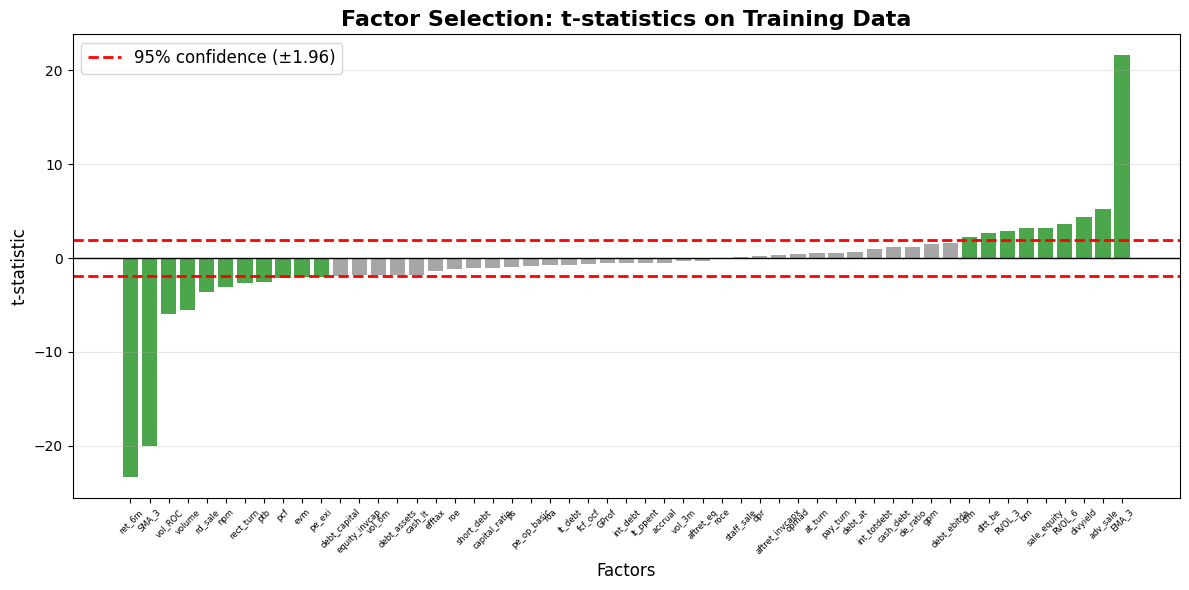


PART 4: HYPERPARAMETER TUNING WITH ROLLING ESTIMATION

Testing: n=10, rebal=1mo, window=36mo


KeyboardInterrupt: 

In [342]:
# ========================================
# HYBRID LONG/SHORT STRATEGY:
# - ONE-TIME factor selection on training data
# - ROLLING estimation of loadings & premia
# ========================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# ========================================
# DATA PREPARATION
# ========================================

df = wrds_file.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'ticker'])
df = df.drop(columns=['price'], errors='ignore')

factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

print(f"Total factors: {len(factor_cols)}")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Split data
train_end = "2022-01-01"
val_end = "2022-12-31"

train = df[df['date'] < train_end]
val = df[(df['date'] >= train_end) & (df['date'] < val_end)]
test = df[df['date'] >= val_end]

print(f"\nTrain: {train.shape}")
print(f"Val: {val.shape}")
print(f"Test: {test.shape}")

risk_free_monthly = (1+0.04)**(1/12) - 1
print(f"\nRisk-free rate: {risk_free_monthly*100:.3f}% monthly")

# ========================================
# PART 1: ONE-TIME FACTOR SELECTION
# (Using only training data)
# ========================================

print("\n" + "="*60)
print("PART 1: INITIAL FACTOR SELECTION (Training Data Only)")
print("="*60)

# Step 1: Estimate alphas/betas on training data
print("\nStep 1: Time Series Regression (Alphas & Betas)")
alpha_dict_train = {}
beta_dict_train = {}
residuals_list = []

for ticker, grp in train.groupby('ticker'):
    grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
    if len(grp_clean) < 12:
        continue
    
    X = grp_clean[['market_ret']].values
    y = grp_clean['ret_1m'].values
    
    reg = LinearRegression().fit(X, y)
    alpha_dict_train[ticker] = reg.intercept_
    beta_dict_train[ticker] = reg.coef_[0]
    
    eps = y - reg.predict(X)
    tmp = grp_clean[['date', 'ticker']].copy()
    tmp['eps'] = eps
    residuals_list.append(tmp)

residuals_df = pd.concat(residuals_list, ignore_index=True)
train_with_eps = train.merge(residuals_df, on=['date', 'ticker'], how='left')

print(f"Estimated α/β for {len(alpha_dict_train)} stocks")

# Step 2: Cross-sectional regressions to get gamma time series
print("\nStep 2: Cross-Sectional Regression")
gamma_time_series = defaultdict(list)

for dt, grp in train_with_eps.groupby('date'):
    grp_clean = grp.dropna(subset=['eps'] + factor_cols)
    if len(grp_clean) < len(factor_cols) + 10:
        continue
    
    X_raw = grp_clean[factor_cols].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    if X_normalized.isnull().any().any():
        continue
    
    y = grp_clean['eps'].values
    reg = LinearRegression().fit(X_normalized.values, y)
    
    for i, fc in enumerate(factor_cols):
        gamma_time_series[fc].append(reg.coef_[i])

T = len(gamma_time_series[factor_cols[0]])
print(f"Cross-sectional regressions: {T} time periods")

# Step 3: Factor selection via t-statistics
print("\nStep 3: Factor Selection (t-statistics)")
t_stats = {}

for fc in factor_cols:
    arr = np.array(gamma_time_series[fc])
    gamma_mean = arr.mean()
    gamma_std = arr.std(ddof=1)
    t_stats[fc] = gamma_mean / (gamma_std / np.sqrt(T)) if gamma_std > 0 else 0

selected_factors = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]

print(f"\n✓ Selected {len(selected_factors)}/{len(factor_cols)} factors (|t-stat| > 1.96)")
print("\nTop 10 factors:")
for fc, tstat in sorted(t_stats.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
    mark = "✓" if fc in selected_factors else ""
    print(f"  {fc:30s}: {tstat:7.3f} {mark}")

# Calculate initial factor premia for selected factors
gamma_star_initial = defaultdict(list)
for dt, grp in train_with_eps.groupby('date'):
    grp_clean = grp.dropna(subset=['eps'] + selected_factors)
    if len(grp_clean) < len(selected_factors) + 10:
        continue
    
    X_raw = grp_clean[selected_factors].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    if X_normalized.isnull().any().any():
        continue
    
    y = grp_clean['eps'].values
    reg = LinearRegression().fit(X_normalized.values, y)
    
    for i, fc in enumerate(selected_factors):
        gamma_star_initial[fc].append(reg.coef_[i])

gamma_bar_initial = {fc: np.mean(gamma_star_initial[fc]) for fc in selected_factors}

print("\n" + "="*60)
print("INITIAL FACTOR PREMIA (Training Data Average)")
print("="*60)
for fc in sorted(gamma_bar_initial.keys(), key=lambda x: abs(gamma_bar_initial[x]), reverse=True):
    print(f"  {fc:30s}: {gamma_bar_initial[fc]:8.6f}")

# Visualize
sorted_items = sorted(t_stats.items(), key=lambda x: x[1])
factors_sorted = [item[0] for item in sorted_items]
values_sorted = [item[1] for item in sorted_items]

plt.figure(figsize=(12, 6))
colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
plt.title("Factor Selection: t-statistics on Training Data", fontsize=16, fontweight='bold')
plt.ylabel("t-statistic", fontsize=12)
plt.xlabel("Factors", fontsize=12)
plt.xticks(rotation=45, fontsize=6)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ========================================
# PART 2: ROLLING ESTIMATION FUNCTIONS
# (For validation and test periods)
# ========================================

def estimate_alphas_betas_rolling(data, min_periods=12):
    """Estimate α and β using available historical data"""
    alpha_dict = {}
    beta_dict = {}
    
    for ticker, grp in data.groupby('ticker'):
        grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
        if len(grp_clean) < min_periods:
            continue
        
        X = grp_clean[['market_ret']].values
        y = grp_clean['ret_1m'].values
        
        reg = LinearRegression().fit(X, y)
        alpha_dict[ticker] = reg.intercept_
        beta_dict[ticker] = reg.coef_[0]
    
    return alpha_dict, beta_dict

def compute_residuals_rolling(data, alpha_dict, beta_dict):
    """
    Compute residuals for given alphas/betas
    Only keeps stocks that have alpha/beta estimates
    """
    data = data.copy()
    data['alpha_i'] = data['ticker'].map(alpha_dict)
    data['beta_i'] = data['ticker'].map(beta_dict)
    
    # Only compute residuals for stocks with valid alpha/beta
    mask = data['alpha_i'].notna() & data['beta_i'].notna()
    data.loc[mask, 'eps'] = (data.loc[mask, 'ret_1m'] - 
                              data.loc[mask, 'alpha_i'] - 
                              data.loc[mask, 'beta_i'] * data.loc[mask, 'market_ret'])
    
    return data

def estimate_factor_premia_rolling(data, selected_factors, min_periods=12):
    """
    Estimate factor premia using cross-sectional regressions
    
    CRITICAL: This function uses ONLY the selected_factors, not all factors.
    This follows proper Fama-MacBeth methodology:
    1. Select factors based on t-statistics (done once on training data)
    2. Re-run regressions with ONLY selected factors (done here)
    3. Average coefficients across time to get premia
    
    Parameters:
    -----------
    data : DataFrame
        Historical data with 'eps' (residuals) and factor columns
    selected_factors : list
        List of factor names that passed t-stat threshold
    min_periods : int
        Minimum number of cross-sectional regressions needed
    
    Returns:
    --------
    dict : Average factor premia (gamma_bar) for each selected factor
    """
    gamma_time_series = defaultdict(list)
    
    for dt, grp in data.groupby('date'):
        # ONLY use selected factors, not all factors
        grp_clean = grp.dropna(subset=['eps'] + selected_factors)
        if len(grp_clean) < len(selected_factors) + 10:
            continue
        
        # Regress residuals on SELECTED factors only
        X_raw = grp_clean[selected_factors].copy()
        X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
        
        if X_normalized.isnull().any().any():
            continue
        
        y = grp_clean['eps'].values
        reg = LinearRegression().fit(X_normalized.values, y)
        
        # Store coefficients for selected factors
        for i, fc in enumerate(selected_factors):
            gamma_time_series[fc].append(reg.coef_[i])
    
    if len(gamma_time_series.get(selected_factors[0], [])) < min_periods:
        return None
    
    # Average across time to get factor premia
    gamma_bar = {fc: np.mean(gamma_time_series[fc]) for fc in selected_factors}
    return gamma_bar

# ========================================
# PART 3: ROLLING PORTFOLIO CONSTRUCTION
# ========================================

def build_portfolio_with_rolling_estimation(
    data, all_data, selected_factors, n_long, n_short, 
    rebalance_freq, training_window=36, risk_free_rate=0.0002,
    track_coefficients=False):
    """
    Build portfolio with rolling estimation of parameters
    
    Key feature: Uses ONLY historical data at each point in time
    
    Handles corporate actions:
    - If a stock disappears (delisting/merger), we capture its last available return
    - If too many stocks disappear, we force rebalancing
    """
    
    oos_data = data.copy().sort_values(['ticker', 'date'])
    all_dates = sorted(oos_data['date'].unique())
    
    portfolio_returns = []
    coefficient_history = [] if track_coefficients else None
    corporate_events = []  # Track disappearances
    current_long = None
    current_short = None
    months_held = 0
    
    for i in range(len(all_dates) - 1):
        current_date = all_dates[i]
        next_date = all_dates[i + 1]
        
        # Get ONLY historical data (no lookahead!)
        hist_data = all_data[all_data['date'] < current_date].copy()
        
        # Apply rolling window
        if training_window:
            earliest_date = current_date - pd.DateOffset(months=training_window)
            hist_data = hist_data[hist_data['date'] >= earliest_date]
        
        # Need sufficient history
        if len(hist_data['date'].unique()) < 24:
            continue
        
        grp_t = oos_data[oos_data['date'] == current_date].copy()
        grp_t1 = oos_data[oos_data['date'] == next_date].copy()
        
        if len(grp_t) < (n_long + n_short):
            continue
        
        # ===================================
        # REBALANCING
        # ===================================
        should_rebalance = (current_long is None) or (months_held >= rebalance_freq)
        
        if should_rebalance:
            # Re-estimate alphas/betas on historical data
            alpha_dict, beta_dict = estimate_alphas_betas_rolling(hist_data)
            
            # Compute residuals for historical data
            hist_with_eps = compute_residuals_rolling(hist_data, alpha_dict, beta_dict)
            
            # Re-estimate factor premia on historical data (using SELECTED factors)
            gamma_bar = estimate_factor_premia_rolling(hist_with_eps, selected_factors)
            
            if gamma_bar is None or len(alpha_dict) < 50:
                continue
            
            # Track coefficient evolution if requested
            if track_coefficients:
                coef_record = {'date': current_date}
                coef_record.update(gamma_bar)
                coefficient_history.append(coef_record)
            
            # Make predictions for current period
            # Normalize factors cross-sectionally
            for fc in factor_cols:
                if grp_t[fc].notna().sum() > 1:
                    grp_t[fc] = (grp_t[fc] - grp_t[fc].mean()) / grp_t[fc].std()
            
            # Predict idiosyncratic return using SELECTED factors
            grp_t['eps_pred'] = 0.0
            for fc in selected_factors:
                grp_t['eps_pred'] += grp_t[fc].fillna(0) * gamma_bar[fc]
            
            grp_t['alpha_i'] = grp_t['ticker'].map(alpha_dict)
            grp_t['beta_i'] = grp_t['ticker'].map(beta_dict)
            
            # Expected market return
            recent_market = hist_data.tail(12*100)['market_ret'].mean()
            grp_t['E_r_m'] = recent_market if not np.isnan(recent_market) else risk_free_rate
            
            # Total predicted return
            grp_t['r_pred'] = (grp_t['alpha_i'].fillna(0) + 
                              grp_t['beta_i'].fillna(0) * grp_t['E_r_m'] + 
                              grp_t['eps_pred'])
            
            grp_t = grp_t.dropna(subset=['r_pred', 'alpha_i', 'beta_i'])
            
            if len(grp_t) < (n_long + n_short):
                continue
            
            # Select stocks
            grp_t = grp_t.sort_values('r_pred', ascending=False)
            
            candidate_long = grp_t.head(int(n_long * 1.5))['ticker'].tolist()
            candidate_short = grp_t.tail(int(n_short * 1.5))['ticker'].tolist()
            
            available_next = grp_t1['ticker'].tolist()
            current_long = [t for t in candidate_long if t in available_next][:n_long]
            current_short = [t for t in candidate_short if t in available_next][:n_short]
            
            months_held = 0
        
        # ===================================
        # MEASURE RETURNS
        # ===================================
        
        # Identify which stocks have returns available
        available_tickers_t1 = set(grp_t1['ticker'].tolist())
        
        # Check for disappeared stocks
        disappeared_long = [t for t in current_long if t not in available_tickers_t1]
        disappeared_short = [t for t in current_short if t not in available_tickers_t1]
        
        if disappeared_long or disappeared_short:
            # Log corporate events
            for ticker in disappeared_long:
                # Try to get last known return (if stock delisted during this period)
                last_return = all_data[(all_data['ticker'] == ticker) & 
                                      (all_data['date'] == current_date)]['ret_1m']
                corporate_events.append({
                    'date': next_date,
                    'ticker': ticker,
                    'side': 'long',
                    'last_return': last_return.iloc[0] if len(last_return) > 0 else np.nan
                })
            
            for ticker in disappeared_short:
                last_return = all_data[(all_data['ticker'] == ticker) & 
                                      (all_data['date'] == current_date)]['ret_1m']
                corporate_events.append({
                    'date': next_date,
                    'ticker': ticker,
                    'side': 'short',
                    'last_return': last_return.iloc[0] if len(last_return) > 0 else np.nan
                })
        
        # Get returns for stocks that are still available
        long_rets = grp_t1[grp_t1['ticker'].isin(current_long)]['ret_1m']
        short_rets = grp_t1[grp_t1['ticker'].isin(current_short)]['ret_1m']
        
        # Check if we lost too many stocks (>30% of either leg)
        long_survival_rate = len(long_rets) / len(current_long) if len(current_long) > 0 else 0
        short_survival_rate = len(short_rets) / len(current_short) if len(current_short) > 0 else 0
        
        # If too many stocks disappeared, force rebalance next period
        if long_survival_rate < 0.7 or short_survival_rate < 0.7:
            current_long = None
            current_short = None
            months_held = 0
            continue
        
        # Skip if we don't have minimum number of stocks
        if len(long_rets) < max(1, n_long // 2) or len(short_rets) < max(1, n_short // 2):
            current_long = None
            current_short = None
            months_held = 0
            continue
        
        long_ret = long_rets.mean()
        short_ret = short_rets.mean()
        ls_ret = long_ret - short_ret
        
        portfolio_returns.append({
            'formation_date': current_date,
            'return_date': next_date,
            'long_return': long_ret,
            'short_return': short_ret,
            'ls_return': ls_ret,
            'ls_excess': ls_ret - risk_free_rate,
            'market_return': grp_t1['market_ret'].mean(),
            'n_long': len(long_rets),
            'n_short': len(short_rets),
            'n_long_target': len(current_long),
            'n_short_target': len(current_short),
            'disappeared_long': len(disappeared_long),
            'disappeared_short': len(disappeared_short),
            'rebalanced': should_rebalance
        })
        
        months_held += 1
    
    result = pd.DataFrame(portfolio_returns)
    
    # Return results with corporate events tracking
    return_tuple = [result]
    if track_coefficients and coefficient_history:
        return_tuple.append(pd.DataFrame(coefficient_history))
    else:
        return_tuple.append(None)
    
    return_tuple.append(pd.DataFrame(corporate_events) if corporate_events else None)
    
    return tuple(return_tuple)

# ========================================
# PERFORMANCE METRICS
# ========================================

def calculate_metrics(portfolio_df, rf_rate):
    """Calculate comprehensive performance metrics"""
    if len(portfolio_df) == 0:
        return None
    
    rets = portfolio_df['ls_return']
    excess = rets - rf_rate
    
    sharpe = (excess.mean() * 12) / (rets.std() * np.sqrt(12)) if rets.std() > 0 else 0
    
    downside = excess[excess < 0]
    sortino = ((excess.mean() * 12) / (downside.std() * np.sqrt(12)) 
               if len(downside) > 1 and downside.std() > 0 else 0)
    
    cum_ret = (1 + rets).prod() - 1
    cum_vals = (1 + rets).cumprod()
    running_max = cum_vals.expanding().max()
    max_dd = ((cum_vals - running_max) / running_max).min()
    
    return {
        'n_periods': len(rets),
        'total_return': cum_ret,
        'annualized_return': (1 + rets.mean())**12 - 1,
        'sharpe': sharpe,
        'sortino': sortino,
        'max_drawdown': max_dd,
        'win_rate': (rets > 0).mean()
    }

# ========================================
# HYPERPARAMETER TUNING (VALIDATION)
# ========================================

print("\n" + "="*60)
print("PART 4: HYPERPARAMETER TUNING WITH ROLLING ESTIMATION")
print("="*60)

n_stocks_options = [10, 25, 50]
rebalance_options = [1, 2, 3]
window_options = [36, None]  # 36 months or expanding

tuning_results = []

for n_stocks, rebal, window in product(n_stocks_options, rebalance_options, window_options):
    window_str = f"{window}mo" if window else "expanding"
    print(f"\nTesting: n={n_stocks}, rebal={rebal}mo, window={window_str}")
    
    val_results = build_portfolio_with_rolling_estimation(
        data=val,
        all_data=df,
        selected_factors=selected_factors,
        n_long=n_stocks,
        n_short=n_stocks,
        rebalance_freq=rebal,
        training_window=window,
        risk_free_rate=risk_free_monthly
    )
    
    val_portfolio = val_results[0]
    
    if len(val_portfolio) == 0:
        print("  ⚠️  No results")
        continue
    
    perf = calculate_metrics(val_portfolio, risk_free_monthly)
    
    tuning_results.append({
        'n_stocks': n_stocks,
        'rebalance': rebal,
        'window': window_str,
        **perf
    })
    
    print(f"  Sharpe: {perf['sharpe']:.3f}, Return: {perf['total_return']*100:.2f}%")

tuning_df = pd.DataFrame(tuning_results)

print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
print(tuning_df.to_string(index=False))

# Select best
best_idx = tuning_df['sharpe'].idxmax()
best = tuning_df.iloc[best_idx]

print(f"\n🏆 BEST PARAMETERS:")
print(f"   n_stocks: {int(best['n_stocks'])}")
print(f"   rebalance: {int(best['rebalance'])} months")
print(f"   window: {best['window']}")
print(f"   Validation Sharpe: {best['sharpe']:.3f}")

# Visualize validation results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for window_val in tuning_df['window'].unique():
    subset = tuning_df[tuning_df['window'] == window_val]
    
    # Sharpe heatmap
    pivot = subset.pivot(index='n_stocks', columns='rebalance', values='sharpe')
    im = axes[0].imshow(pivot.values, cmap='RdYlGn', aspect='auto', alpha=0.7)
    axes[0].set_xticks(range(len(pivot.columns)))
    axes[0].set_yticks(range(len(pivot.index)))
    axes[0].set_xticklabels(pivot.columns)
    axes[0].set_yticklabels(pivot.index)
    axes[0].set_title('Sharpe Ratio')
    axes[0].set_xlabel('Rebalance Freq (mo)')
    axes[0].set_ylabel('N Stocks')
    # Add value annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            axes[0].text(j, i, f'{pivot.values[i, j]:.2f}',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
    # Return heatmap
    pivot = subset.pivot(index='n_stocks', columns='rebalance', values='total_return')
    axes[1].imshow(pivot.values * 100, cmap='RdYlGn', aspect='auto', alpha=0.7)
    axes[1].set_xticks(range(len(pivot.columns)))
    axes[1].set_yticks(range(len(pivot.index)))
    axes[1].set_xticklabels(pivot.columns)
    axes[1].set_yticklabels(pivot.index)
    axes[1].set_title('Total Return (%)')
    axes[1].set_xlabel('Rebalance Freq (mo)')
    # Add value annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            axes[1].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
    # Drawdown heatmap
    pivot = subset.pivot(index='n_stocks', columns='rebalance', values='max_drawdown')
    axes[2].imshow(pivot.values * 100, cmap='RdYlGn_r', aspect='auto', alpha=0.7)
    axes[2].set_xticks(range(len(pivot.columns)))
    axes[2].set_yticks(range(len(pivot.index)))
    axes[2].set_xticklabels(pivot.columns)
    axes[2].set_yticklabels(pivot.index)
    axes[2].set_title('Max Drawdown (%)')
    axes[2].set_xlabel('Rebalance Freq (mo)')
    # Add value annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            axes[2].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)

plt.suptitle('Validation: Rolling Estimation Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FINAL TEST
# ========================================

print("\n" + "="*60)
print("PART 5: FINAL TEST SET EVALUATION")
print("="*60)

best_window = None if best['window'] == 'expanding' else int(best['window'].replace('mo', ''))

test_results = build_portfolio_with_rolling_estimation(
    data=test,
    all_data=df,
    selected_factors=selected_factors,
    n_long=int(best['n_stocks']),
    n_short=int(best['n_stocks']),
    rebalance_freq=int(best['rebalance']),
    training_window=best_window,
    risk_free_rate=risk_free_monthly,
    track_coefficients=True
)

test_portfolio = test_results[0]
coef_history = test_results[1]
corporate_events_df = test_results[2]

if len(test_portfolio) > 0:
    test_perf = calculate_metrics(test_portfolio, risk_free_monthly)
    
    print(f"\n📊 TEST SET PERFORMANCE:")
    print(f"   Periods: {test_perf['n_periods']}")
    print(f"   Total Return: {test_perf['total_return']*100:.2f}%")
    print(f"   Annualized: {test_perf['annualized_return']*100:.2f}%")
    print(f"   Sharpe Ratio: {test_perf['sharpe']:.3f}")
    print(f"   Sortino Ratio: {test_perf['sortino']:.3f}")
    print(f"   Max Drawdown: {test_perf['max_drawdown']*100:.2f}%")
    print(f"   Win Rate: {test_perf['win_rate']*100:.1f}%")
    
    # ========================================
    # CORPORATE EVENTS ANALYSIS
    # ========================================
    
    if corporate_events_df is not None and len(corporate_events_df) > 0:
        print("\n" + "="*60)
        print("CORPORATE EVENTS (Delistings/Mergers)")
        print("="*60)
        
        total_disappeared = len(corporate_events_df)
        long_disappeared = len(corporate_events_df[corporate_events_df['side'] == 'long'])
        short_disappeared = len(corporate_events_df[corporate_events_df['side'] == 'short'])
        
        print(f"\nTotal stocks that disappeared: {total_disappeared}")
        print(f"  - From long positions: {long_disappeared}")
        print(f"  - From short positions: {short_disappeared}")
        
        # Analyze impact
        events_with_returns = corporate_events_df.dropna(subset=['last_return'])
        if len(events_with_returns) > 0:
            avg_return = events_with_returns['last_return'].mean()
            print(f"\nAverage last return before disappearance: {avg_return*100:.2f}%")
            print(f"(Negative = stocks crashed before delisting)")
            
            # Show worst cases
            print("\n5 Worst disappearances (lowest returns):")
            worst = events_with_returns.nsmallest(5, 'last_return')
            for _, row in worst.iterrows():
                print(f"  {row['ticker']:10s} ({row['side']:5s}): {row['last_return']*100:+7.2f}% on {row['date'].date()}")
        
        # Portfolio impact over time
        disappeared_summary = test_portfolio[['return_date', 'disappeared_long', 'disappeared_short']].copy()
        disappeared_summary['total_disappeared'] = (disappeared_summary['disappeared_long'] + 
                                                   disappeared_summary['disappeared_short'])
        
        total_events = disappeared_summary['total_disappeared'].sum()
        if total_events > 0:
            print(f"\nTotal disappearance events during test period: {int(total_events)}")
            print(f"Disappearance rate: {total_events / len(test_portfolio):.2f} stocks per month")
    
    # Portfolio composition statistics
    print("\n" + "="*60)
    print("PORTFOLIO COMPOSITION STATISTICS")
    print("="*60)
    
    avg_long = test_portfolio['n_long'].mean()
    avg_short = test_portfolio['n_short'].mean()
    min_long = test_portfolio['n_long'].min()
    min_short = test_portfolio['n_short'].min()
    
    print(f"\nAverage stocks per leg:")
    print(f"  Long:  {avg_long:.1f} (target: {int(best['n_stocks'])}, min: {int(min_long)})")
    print(f"  Short: {avg_short:.1f} (target: {int(best['n_stocks'])}, min: {int(min_short)})")
    
    # Check if we consistently hit targets
    target_long = test_portfolio['n_long_target'].iloc[0] if 'n_long_target' in test_portfolio.columns else int(best['n_stocks'])
    pct_full_long = (test_portfolio['n_long'] == target_long).mean() * 100
    pct_full_short = (test_portfolio['n_short'] == target_long).mean() * 100
    
    print(f"\nPercentage of periods with full target:")
    print(f"  Long:  {pct_full_long:.1f}%")
    print(f"  Short: {pct_full_short:.1f}%")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Portfolio value - start from 100
    cum_ret = 100 * (1 + test_portfolio['ls_return']).cumprod()
    # Prepend initial value of 100
    dates_plot = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
    values_plot = [100] + cum_ret.tolist()
    
    axes[0,0].plot(dates_plot, values_plot, linewidth=2.5, color='#2E86AB')
    axes[0,0].axhline(100, color='black', linestyle=':', linewidth=1.5)
    axes[0,0].set_title('Portfolio Value ($100 start)', fontweight='bold', fontsize=12)
    axes[0,0].set_ylabel('Value ($)', fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].fill_between(dates_plot, 100, values_plot,
                           where=(np.array(values_plot) >= 100), alpha=0.3, color='green')
    axes[0,0].fill_between(dates_plot, 100, values_plot,
                           where=(np.array(values_plot) < 100), alpha=0.3, color='red')
    axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))
    
    # Monthly returns
    colors = ['g' if x > 0 else 'r' for x in test_portfolio['ls_return']]
    axes[0,1].bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
                  color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[0,1].axhline(0, color='black', linewidth=1)
    axes[0,1].axhline(test_portfolio['ls_return'].mean()*100, 
                      color='blue', linestyle='--', linewidth=1.5, alpha=0.7,
                      label=f'Mean: {test_portfolio["ls_return"].mean()*100:.2f}%')
    axes[0,1].set_title('Monthly Returns', fontweight='bold', fontsize=12)
    axes[0,1].set_ylabel('Return (%)', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3, axis='y')
    
    # Cumulative return
    axes[1,0].plot(test_portfolio['return_date'], 
                   (cum_ret/100 - 1) * 100, linewidth=2.5, color='blue')
    axes[1,0].axhline(0, color='black', linewidth=1)
    axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
                           where=((cum_ret/100 - 1) * 100 >= 0), alpha=0.3, color='green')
    axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
                           where=((cum_ret/100 - 1) * 100 < 0), alpha=0.3, color='red')
    axes[1,0].set_title('Cumulative Return', fontweight='bold', fontsize=12)
    axes[1,0].set_ylabel('Return (%)', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    # Drawdown
    running_max = cum_ret.expanding().max()
    dd = (cum_ret - running_max) / running_max * 100
    axes[1,1].fill_between(test_portfolio['return_date'], 0, dd, 
                           color='red', alpha=0.6)
    axes[1,1].plot(test_portfolio['return_date'], dd, linewidth=2, color='darkred')
    axes[1,1].set_title(f'Drawdown (Max: {dd.min():.2f}%)', fontweight='bold', fontsize=12)
    axes[1,1].set_ylabel('Drawdown (%)', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Test Set: Rolling Estimation Strategy\n' +
                 f'(n={int(best["n_stocks"])}, rebal={int(best["rebalance"])}mo, ' +
                 f'window={best["window"]}, {len(selected_factors)} factors)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # VISUALIZE COEFFICIENT EVOLUTION
    # ========================================
    
    if coef_history is not None and len(coef_history) > 0:
        print("\n" + "="*60)
        print("COEFFICIENT EVOLUTION OVER TIME")
        print("="*60)
        
        # Show how coefficients changed
        print(f"\nCoefficients were re-estimated {len(coef_history)} times during test period")
        print("\nComparison: Initial (Training) vs Final (Test):")
        print("-" * 80)
        print(f"{'Factor':<30} {'Initial (Train)':>15} {'Final (Test)':>15} {'Change':>15}")
        print("-" * 80)
        
        for fc in sorted(selected_factors, key=lambda x: abs(gamma_bar_initial.get(x, 0)), reverse=True)[:10]:
            initial_val = gamma_bar_initial.get(fc, 0)
            final_val = coef_history[fc].iloc[-1] if fc in coef_history.columns else 0
            change = final_val - initial_val
            print(f"{fc:<30} {initial_val:>15.6f} {final_val:>15.6f} {change:>+15.6f}")
        
        # Plot coefficient evolution for top factors
        top_factors = sorted(selected_factors, 
                           key=lambda x: abs(gamma_bar_initial.get(x, 0)), 
                           reverse=True)[:6]
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for idx, fc in enumerate(top_factors):
            if fc in coef_history.columns:
                ax = axes[idx]
                ax.plot(coef_history['date'], coef_history[fc], 
                       linewidth=2, marker='o', markersize=4, color='#2E86AB')
                ax.axhline(gamma_bar_initial[fc], color='red', linestyle='--', 
                          linewidth=2, alpha=0.7, label='Initial (Training)')
                ax.axhline(0, color='black', linestyle=':', linewidth=1)
                ax.set_title(f'{fc}', fontweight='bold', fontsize=11)
                ax.set_ylabel('Coefficient', fontweight='bold', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=8)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
        
        plt.suptitle('Top 6 Factor Coefficients: Evolution During Test Period\n' + 
                    '(Red dashed line = Initial value from training data)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Summary statistics on coefficient stability
        print("\n" + "="*60)
        print("COEFFICIENT STABILITY METRICS")
        print("="*60)
        
        for fc in top_factors[:5]:
            if fc in coef_history.columns:
                vals = coef_history[fc].values
                mean_val = np.mean(vals)
                std_val = np.std(vals)
                min_val = np.min(vals)
                max_val = np.max(vals)
                cv = (std_val / abs(mean_val)) * 100 if mean_val != 0 else np.inf
                
                print(f"\n{fc}:")
                print(f"  Mean: {mean_val:8.6f}")
                print(f"  Std:  {std_val:8.6f}")
                print(f"  Range: [{min_val:8.6f}, {max_val:8.6f}]")
                print(f"  Coef. of Variation: {cv:.1f}%")
    
    # Summary comparison
    print("\n" + "="*60)
    print("SUMMARY: Validation vs Test")
    print("="*60)
    print(f"{'Metric':<25} {'Validation':>12} {'Test':>12}")
    print("-" * 60)
    print(f"{'Sharpe Ratio':<25} {best['sharpe']:>12.3f} {test_perf['sharpe']:>12.3f}")
    print(f"{'Total Return (%)':<25} {best['total_return']*100:>12.2f} {test_perf['total_return']*100:>12.2f}")
    print(f"{'Max Drawdown (%)':<25} {best['max_drawdown']*100:>12.2f} {test_perf['max_drawdown']*100:>12.2f}")
    print(f"{'Win Rate (%)':<25} {best['win_rate']*100:>12.1f} {test_perf['win_rate']*100:>12.1f}")
    
else:
    print("❌ No test results generated")

print("\n✅ ANALYSIS COMPLETE")
print("\n📋 METHODOLOGY SUMMARY:")
print("  1. Factor selection: ONE-TIME on training data (2015-2022)")
print(f"     - Started with {len(factor_cols)} factors")
print(f"     - Selected {len(selected_factors)} significant factors (|t-stat| > 1.96)")
print("  2. Parameter estimation: ROLLING on historical data only")
print("     - Alpha/Beta re-estimated at each rebalancing")
print("     - Factor premia re-estimated using ONLY selected factors")
print("  3. No look-ahead bias: All predictions use only past information")
print("  4. Proper Fama-MacBeth: Regressions use ONLY selected factors, not all factors")

Graph

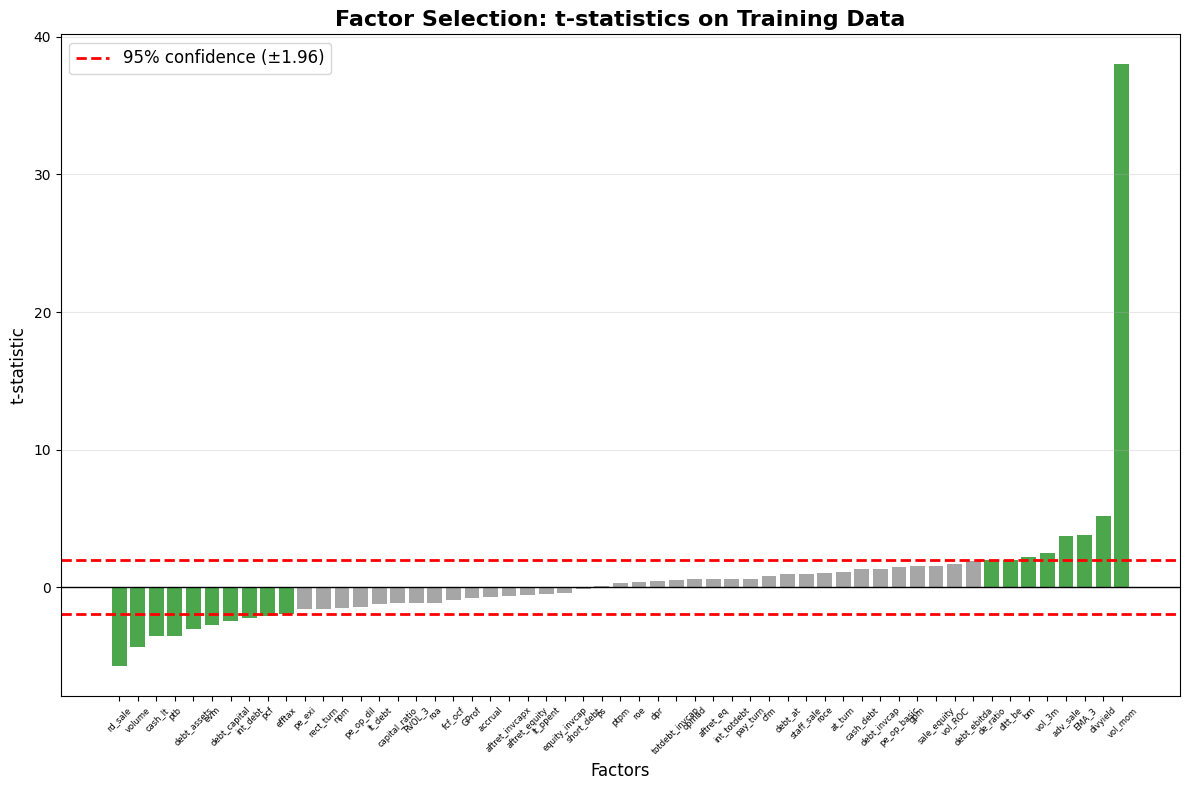

In [ ]:
plt.figure(figsize=(12, 8))
colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
plt.title("Factor Selection: t-statistics on Training Data", fontsize=16, fontweight='bold')
plt.ylabel("t-statistic", fontsize=12)
plt.xlabel("Factors", fontsize=12)
plt.xticks(rotation=45, fontsize=6)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


PART 5: FINAL TEST SET EVALUATION

📊 TEST SET PERFORMANCE:
   Periods: 24
   Total Return: -17.19%
   Annualized: -5.34%
   Sharpe Ratio: -0.337
   Sortino Ratio: -0.397
   Max Drawdown: -32.92%
   Win Rate: 54.2%

CORPORATE EVENTS (Delistings/Mergers)

Total stocks that disappeared: 6
  - From long positions: 3
  - From short positions: 3

Average last return before disappearance: 9.28%
(Negative = stocks crashed before delisting)

5 Worst disappearances (lowest returns):
  DVN        (short):   -1.89% on 2024-12-31
  NKE        (short):   -1.83% on 2024-05-31
  ILMN       (long ):   +2.71% on 2024-02-29
  TSLA       (long ):  +38.15% on 2024-12-31

Total disappearance events during test period: 6
Disappearance rate: 0.25 stocks per month

PORTFOLIO COMPOSITION STATISTICS

Average stocks per leg:
  Long:  9.9 (target: 10, min: 9)
  Short: 9.9 (target: 10, min: 9)

Percentage of periods with full target:
  Long:  87.5%
  Short: 87.5%


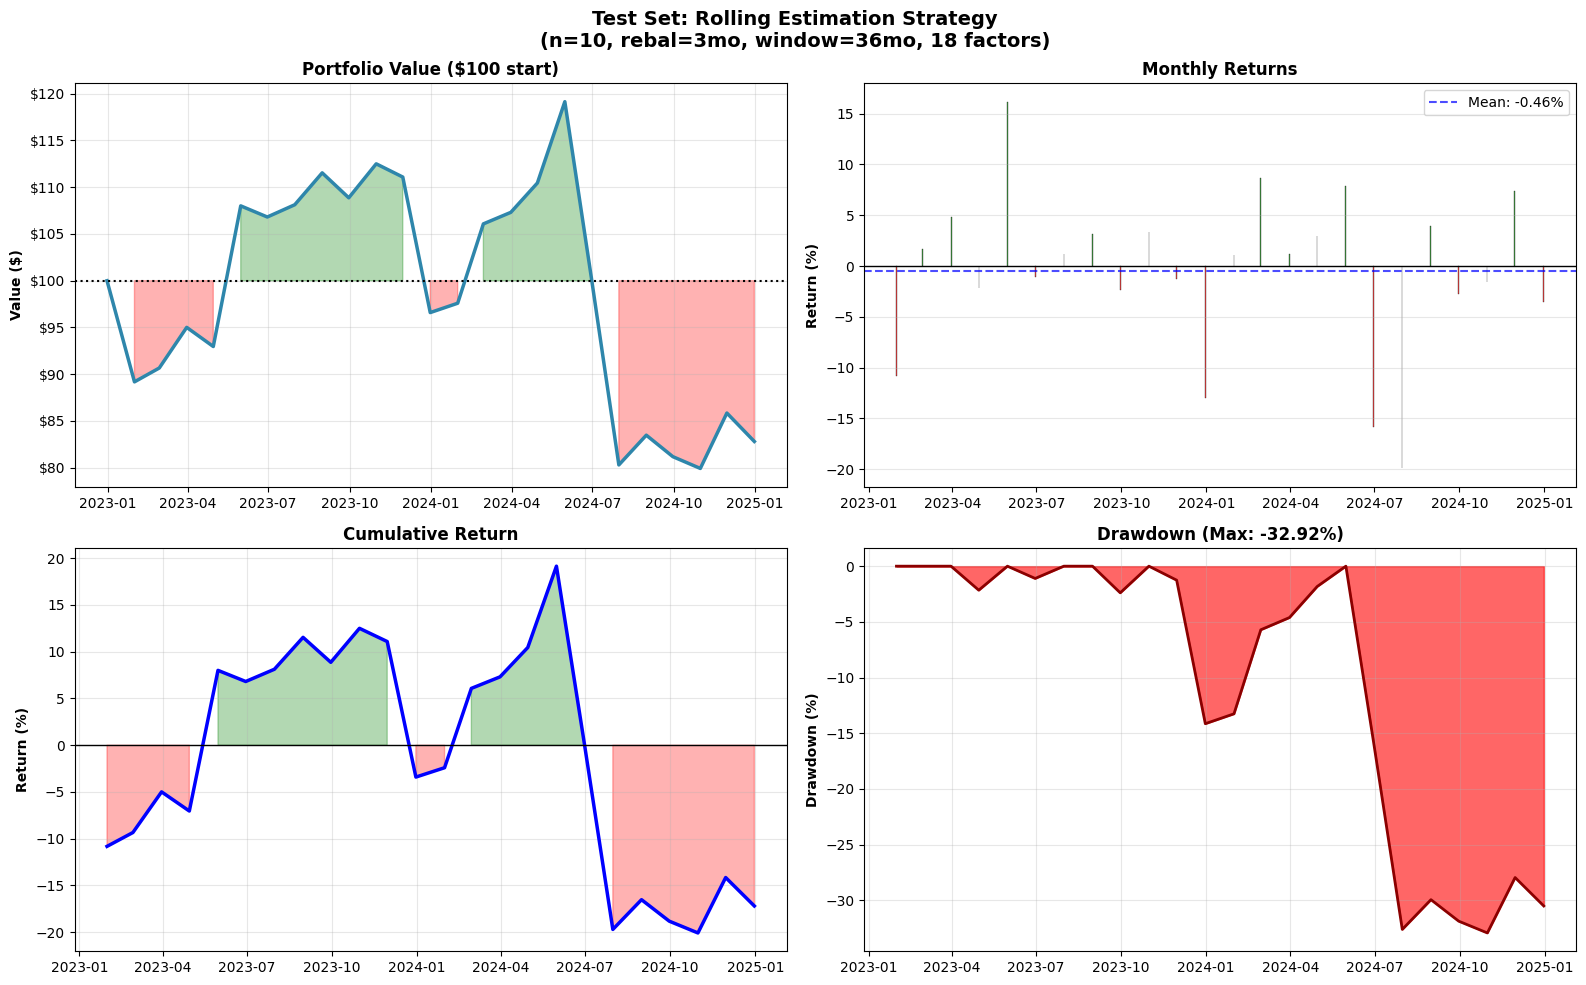


COEFFICIENT EVOLUTION OVER TIME

Coefficients were re-estimated 8 times during test period

Comparison: Initial (Training) vs Final (Test):
--------------------------------------------------------------------------------
Factor                         Initial (Train)    Final (Test)          Change
--------------------------------------------------------------------------------
vol_mom                               0.058335        0.062262       +0.003926
EMA_3                                 0.012150        0.007881       -0.004269
vol_3m                                0.003017        0.002553       -0.000464
rd_sale                              -0.001957       -0.000144       +0.001812
divyield                              0.001838        0.000079       -0.001759
volume                               -0.001248       -0.000474       +0.000773
debt_assets                          -0.001110       -0.000542       +0.000568
bm                                    0.001025        0.001085   

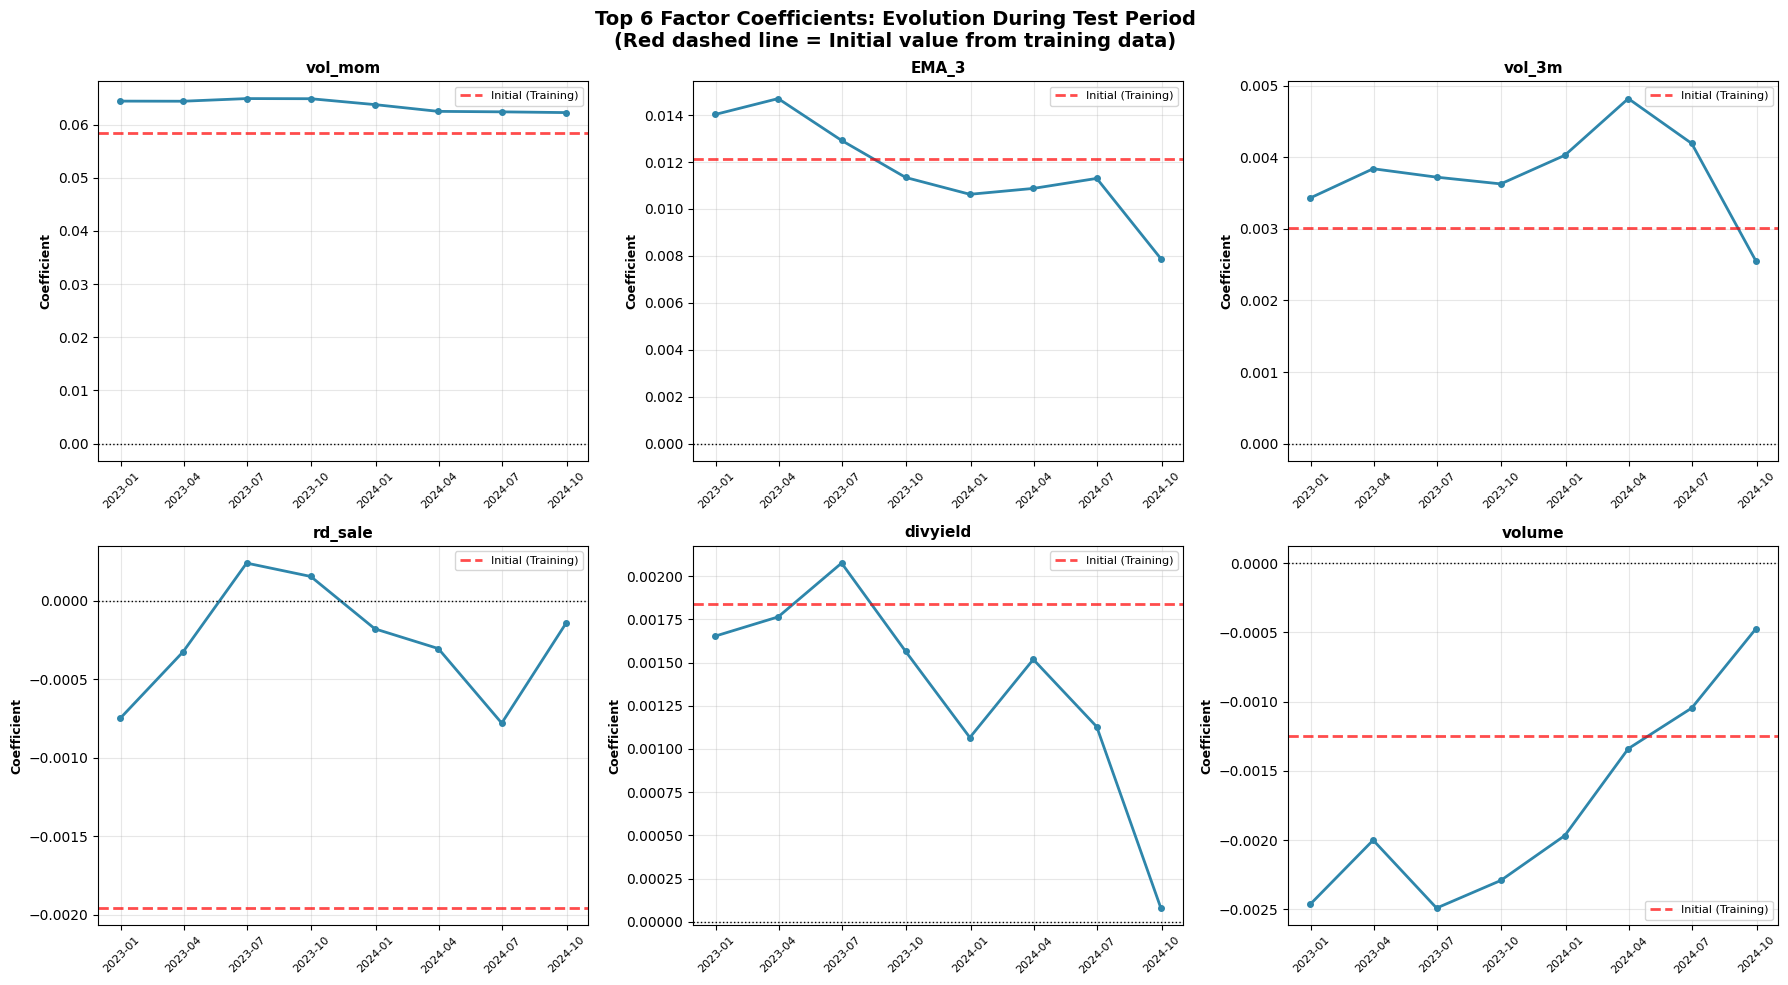


COEFFICIENT STABILITY METRICS

vol_mom:
  Mean: 0.063688
  Std:  0.001062
  Range: [0.062262, 0.064896]
  Coef. of Variation: 1.7%

EMA_3:
  Mean: 0.011711
  Std:  0.002021
  Range: [0.007881, 0.014706]
  Coef. of Variation: 17.3%

vol_3m:
  Mean: 0.003778
  Std:  0.000610
  Range: [0.002553, 0.004821]
  Coef. of Variation: 16.1%

rd_sale:
  Mean: -0.000260
  Std:  0.000346
  Range: [-0.000779, 0.000241]
  Coef. of Variation: 132.9%

divyield:
  Mean: 0.001356
  Std:  0.000571
  Range: [0.000079, 0.002076]
  Coef. of Variation: 42.1%

SUMMARY: Validation vs Test
Metric                      Validation         Test
------------------------------------------------------------
Sharpe Ratio                     0.460       -0.337
Total Return (%)                 10.07       -17.19
Max Drawdown (%)                -12.00       -32.92
Win Rate (%)                      70.0         54.2

✅ ANALYSIS COMPLETE

📋 METHODOLOGY SUMMARY:
  1. Factor selection: ONE-TIME on training data (2015-2022)
   

In [ ]:
# ========================================
# FINAL TEST
# ========================================

print("\n" + "="*60)
print("PART 5: FINAL TEST SET EVALUATION")
print("="*60)
rf = 3
n = 10
best_window = None if best['window'] == 'expanding' else int(best['window'].replace('mo', ''))

test_results = build_portfolio_with_rolling_estimation(
    data=test,
    all_data=df,
    selected_factors=selected_factors,
    n_long=n,
    n_short=n,
    rebalance_freq=rf,
    training_window=best_window,
    risk_free_rate=risk_free_monthly,
    track_coefficients=True
)

test_portfolio = test_results[0]
coef_history = test_results[1]
corporate_events_df = test_results[2]

if len(test_portfolio) > 0:
    test_perf = calculate_metrics(test_portfolio, risk_free_monthly)
    
    print(f"\n📊 TEST SET PERFORMANCE:")
    print(f"   Periods: {test_perf['n_periods']}")
    print(f"   Total Return: {test_perf['total_return']*100:.2f}%")
    print(f"   Annualized: {test_perf['annualized_return']*100:.2f}%")
    print(f"   Sharpe Ratio: {test_perf['sharpe']:.3f}")
    print(f"   Sortino Ratio: {test_perf['sortino']:.3f}")
    print(f"   Max Drawdown: {test_perf['max_drawdown']*100:.2f}%")
    print(f"   Win Rate: {test_perf['win_rate']*100:.1f}%")
    
    # ========================================
    # CORPORATE EVENTS ANALYSIS
    # ========================================
    
    if corporate_events_df is not None and len(corporate_events_df) > 0:
        print("\n" + "="*60)
        print("CORPORATE EVENTS (Delistings/Mergers)")
        print("="*60)
        
        total_disappeared = len(corporate_events_df)
        long_disappeared = len(corporate_events_df[corporate_events_df['side'] == 'long'])
        short_disappeared = len(corporate_events_df[corporate_events_df['side'] == 'short'])
        
        print(f"\nTotal stocks that disappeared: {total_disappeared}")
        print(f"  - From long positions: {long_disappeared}")
        print(f"  - From short positions: {short_disappeared}")
        
        # Analyze impact
        events_with_returns = corporate_events_df.dropna(subset=['last_return'])
        if len(events_with_returns) > 0:
            avg_return = events_with_returns['last_return'].mean()
            print(f"\nAverage last return before disappearance: {avg_return*100:.2f}%")
            print(f"(Negative = stocks crashed before delisting)")
            
            # Show worst cases
            print("\n5 Worst disappearances (lowest returns):")
            worst = events_with_returns.nsmallest(5, 'last_return')
            for _, row in worst.iterrows():
                print(f"  {row['ticker']:10s} ({row['side']:5s}): {row['last_return']*100:+7.2f}% on {row['date'].date()}")
        
        # Portfolio impact over time
        disappeared_summary = test_portfolio[['return_date', 'disappeared_long', 'disappeared_short']].copy()
        disappeared_summary['total_disappeared'] = (disappeared_summary['disappeared_long'] + 
                                                   disappeared_summary['disappeared_short'])
        
        total_events = disappeared_summary['total_disappeared'].sum()
        if total_events > 0:
            print(f"\nTotal disappearance events during test period: {int(total_events)}")
            print(f"Disappearance rate: {total_events / len(test_portfolio):.2f} stocks per month")
    
    # Portfolio composition statistics
    print("\n" + "="*60)
    print("PORTFOLIO COMPOSITION STATISTICS")
    print("="*60)
    
    avg_long = test_portfolio['n_long'].mean()
    avg_short = test_portfolio['n_short'].mean()
    min_long = test_portfolio['n_long'].min()
    min_short = test_portfolio['n_short'].min()
    
    print(f"\nAverage stocks per leg:")
    print(f"  Long:  {avg_long:.1f} (target: {int(best['n_stocks'])}, min: {int(min_long)})")
    print(f"  Short: {avg_short:.1f} (target: {int(best['n_stocks'])}, min: {int(min_short)})")
    
    # Check if we consistently hit targets
    target_long = test_portfolio['n_long_target'].iloc[0] if 'n_long_target' in test_portfolio.columns else int(best['n_stocks'])
    pct_full_long = (test_portfolio['n_long'] == target_long).mean() * 100
    pct_full_short = (test_portfolio['n_short'] == target_long).mean() * 100
    
    print(f"\nPercentage of periods with full target:")
    print(f"  Long:  {pct_full_long:.1f}%")
    print(f"  Short: {pct_full_short:.1f}%")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Portfolio value - start from 100
    cum_ret = 100 * (1 + test_portfolio['ls_return']).cumprod()
    # Prepend initial value of 100
    dates_plot = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
    values_plot = [100] + cum_ret.tolist()
    
    axes[0,0].plot(dates_plot, values_plot, linewidth=2.5, color='#2E86AB')
    axes[0,0].axhline(100, color='black', linestyle=':', linewidth=1.5)
    axes[0,0].set_title('Portfolio Value ($100 start)', fontweight='bold', fontsize=12)
    axes[0,0].set_ylabel('Value ($)', fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].fill_between(dates_plot, 100, values_plot,
                           where=(np.array(values_plot) >= 100), alpha=0.3, color='green')
    axes[0,0].fill_between(dates_plot, 100, values_plot,
                           where=(np.array(values_plot) < 100), alpha=0.3, color='red')
    axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))
    
    # Monthly returns
    colors = ['g' if x > 0 else 'r' for x in test_portfolio['ls_return']]
    axes[0,1].bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
                  color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[0,1].axhline(0, color='black', linewidth=1)
    axes[0,1].axhline(test_portfolio['ls_return'].mean()*100, 
                      color='blue', linestyle='--', linewidth=1.5, alpha=0.7,
                      label=f'Mean: {test_portfolio["ls_return"].mean()*100:.2f}%')
    axes[0,1].set_title('Monthly Returns', fontweight='bold', fontsize=12)
    axes[0,1].set_ylabel('Return (%)', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3, axis='y')
    
    # Cumulative return
    axes[1,0].plot(test_portfolio['return_date'], 
                   (cum_ret/100 - 1) * 100, linewidth=2.5, color='blue')
    axes[1,0].axhline(0, color='black', linewidth=1)
    axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
                           where=((cum_ret/100 - 1) * 100 >= 0), alpha=0.3, color='green')
    axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
                           where=((cum_ret/100 - 1) * 100 < 0), alpha=0.3, color='red')
    axes[1,0].set_title('Cumulative Return', fontweight='bold', fontsize=12)
    axes[1,0].set_ylabel('Return (%)', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    # Drawdown
    running_max = cum_ret.expanding().max()
    dd = (cum_ret - running_max) / running_max * 100
    axes[1,1].fill_between(test_portfolio['return_date'], 0, dd, 
                           color='red', alpha=0.6)
    axes[1,1].plot(test_portfolio['return_date'], dd, linewidth=2, color='darkred')
    axes[1,1].set_title(f'Drawdown (Max: {dd.min():.2f}%)', fontweight='bold', fontsize=12)
    axes[1,1].set_ylabel('Drawdown (%)', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Test Set: Rolling Estimation Strategy\n' +
                 f'(n={int(best["n_stocks"])}, rebal={int(best["rebalance"])}mo, ' +
                 f'window={best["window"]}, {len(selected_factors)} factors)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # VISUALIZE COEFFICIENT EVOLUTION
    # ========================================
    
    if coef_history is not None and len(coef_history) > 0:
        print("\n" + "="*60)
        print("COEFFICIENT EVOLUTION OVER TIME")
        print("="*60)
        
        # Show how coefficients changed
        print(f"\nCoefficients were re-estimated {len(coef_history)} times during test period")
        print("\nComparison: Initial (Training) vs Final (Test):")
        print("-" * 80)
        print(f"{'Factor':<30} {'Initial (Train)':>15} {'Final (Test)':>15} {'Change':>15}")
        print("-" * 80)
        
        for fc in sorted(selected_factors, key=lambda x: abs(gamma_bar_initial.get(x, 0)), reverse=True)[:10]:
            initial_val = gamma_bar_initial.get(fc, 0)
            final_val = coef_history[fc].iloc[-1] if fc in coef_history.columns else 0
            change = final_val - initial_val
            print(f"{fc:<30} {initial_val:>15.6f} {final_val:>15.6f} {change:>+15.6f}")
        
        # Plot coefficient evolution for top factors
        top_factors = sorted(selected_factors, 
                           key=lambda x: abs(gamma_bar_initial.get(x, 0)), 
                           reverse=True)[:6]
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for idx, fc in enumerate(top_factors):
            if fc in coef_history.columns:
                ax = axes[idx]
                ax.plot(coef_history['date'], coef_history[fc], 
                       linewidth=2, marker='o', markersize=4, color='#2E86AB')
                ax.axhline(gamma_bar_initial[fc], color='red', linestyle='--', 
                          linewidth=2, alpha=0.7, label='Initial (Training)')
                ax.axhline(0, color='black', linestyle=':', linewidth=1)
                ax.set_title(f'{fc}', fontweight='bold', fontsize=11)
                ax.set_ylabel('Coefficient', fontweight='bold', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=8)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
        
        plt.suptitle('Top 6 Factor Coefficients: Evolution During Test Period\n' + 
                    '(Red dashed line = Initial value from training data)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Summary statistics on coefficient stability
        print("\n" + "="*60)
        print("COEFFICIENT STABILITY METRICS")
        print("="*60)
        
        for fc in top_factors[:5]:
            if fc in coef_history.columns:
                vals = coef_history[fc].values
                mean_val = np.mean(vals)
                std_val = np.std(vals)
                min_val = np.min(vals)
                max_val = np.max(vals)
                cv = (std_val / abs(mean_val)) * 100 if mean_val != 0 else np.inf
                
                print(f"\n{fc}:")
                print(f"  Mean: {mean_val:8.6f}")
                print(f"  Std:  {std_val:8.6f}")
                print(f"  Range: [{min_val:8.6f}, {max_val:8.6f}]")
                print(f"  Coef. of Variation: {cv:.1f}%")
    
    # Summary comparison
    print("\n" + "="*60)
    print("SUMMARY: Validation vs Test")
    print("="*60)
    print(f"{'Metric':<25} {'Validation':>12} {'Test':>12}")
    print("-" * 60)
    print(f"{'Sharpe Ratio':<25} {best['sharpe']:>12.3f} {test_perf['sharpe']:>12.3f}")
    print(f"{'Total Return (%)':<25} {best['total_return']*100:>12.2f} {test_perf['total_return']*100:>12.2f}")
    print(f"{'Max Drawdown (%)':<25} {best['max_drawdown']*100:>12.2f} {test_perf['max_drawdown']*100:>12.2f}")
    print(f"{'Win Rate (%)':<25} {best['win_rate']*100:>12.1f} {test_perf['win_rate']*100:>12.1f}")
    
else:
    print("❌ No test results generated")

print("\n✅ ANALYSIS COMPLETE")
print("\n📋 METHODOLOGY SUMMARY:")
print("  1. Factor selection: ONE-TIME on training data (2015-2022)")
print(f"     - Started with {len(factor_cols)} factors")
print(f"     - Selected {len(selected_factors)} significant factors (|t-stat| > 1.96)")
print("  2. Parameter estimation: ROLLING on historical data only")
print("     - Alpha/Beta re-estimated at each rebalancing")
print("     - Factor premia re-estimated using ONLY selected factors")
print("  3. No look-ahead bias: All predictions use only past information")
print("  4. Proper Fama-MacBeth: Regressions use ONLY selected factors, not all factors")

Total factors: 55
Data shape: (52162, 59)
Date range: 2014-01-31 00:00:00 to 2024-12-31 00:00:00

Train: (36890, 59)
Val: (4735, 59)
Test: (10537, 59)

Risk-free rate: 0.327% monthly

PART 1: INITIAL FACTOR SELECTION (Training Data Only)

Step 1: Time Series Regression (Alphas & Betas)
Estimated α/β for 523 stocks

Step 2: Cross-Sectional Regression
Cross-sectional regressions: 96 time periods

Step 3: Factor Selection (t-statistics)

✓ Selected 18/55 factors (|t-stat| > 1.96)

Top 10 factors:
  vol_mom                       :  38.004 ✓
  rd_sale                       :  -5.721 ✓
  divyield                      :   5.176 ✓
  volume                        :  -4.378 ✓
  EMA_3                         :   3.766 ✓
  adv_sale                      :   3.722 ✓
  cash_lt                       :  -3.586 ✓
  ptb                           :  -3.586 ✓
  debt_assets                   :  -3.067 ✓
  evm                           :  -2.731 ✓

INITIAL FACTOR PREMIA (Training Data Average)
  vol_mom     

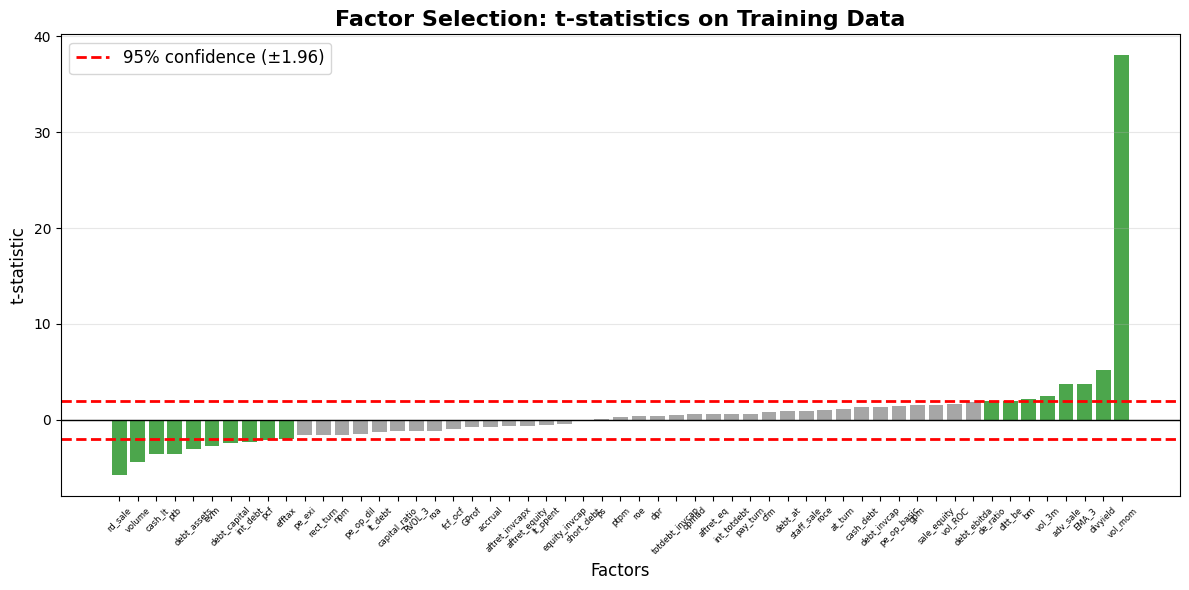


PART 4: HYPERPARAMETER TUNING WITH ROLLING ESTIMATION

Testing: n=10, rebal=1mo, window=36mo
  Sharpe: -0.455, Return: -4.61%, Vol: 17.89%

Testing: n=10, rebal=1mo, window=expanding
  Sharpe: -0.486, Return: -4.97%, Vol: 17.75%

Testing: n=10, rebal=2mo, window=36mo
  Sharpe: -0.483, Return: -7.94%, Vol: 23.35%

Testing: n=10, rebal=2mo, window=expanding
  Sharpe: -0.696, Return: -10.05%, Vol: 20.91%

Testing: n=10, rebal=3mo, window=36mo
  Sharpe: 0.460, Return: 10.07%, Vol: 20.95%

Testing: n=10, rebal=3mo, window=expanding
  Sharpe: 0.227, Return: 5.81%, Vol: 21.91%

Testing: n=25, rebal=1mo, window=36mo
  Sharpe: -0.572, Return: -7.58%, Vol: 20.12%

Testing: n=25, rebal=1mo, window=expanding
  Sharpe: -0.747, Return: -9.56%, Vol: 19.10%

Testing: n=25, rebal=2mo, window=36mo
  Sharpe: -0.597, Return: -5.79%, Vol: 16.49%

Testing: n=25, rebal=2mo, window=expanding
  Sharpe: -0.992, Return: -11.13%, Vol: 16.84%

Testing: n=25, rebal=3mo, window=36mo
  Sharpe: -0.243, Return: -2.15%

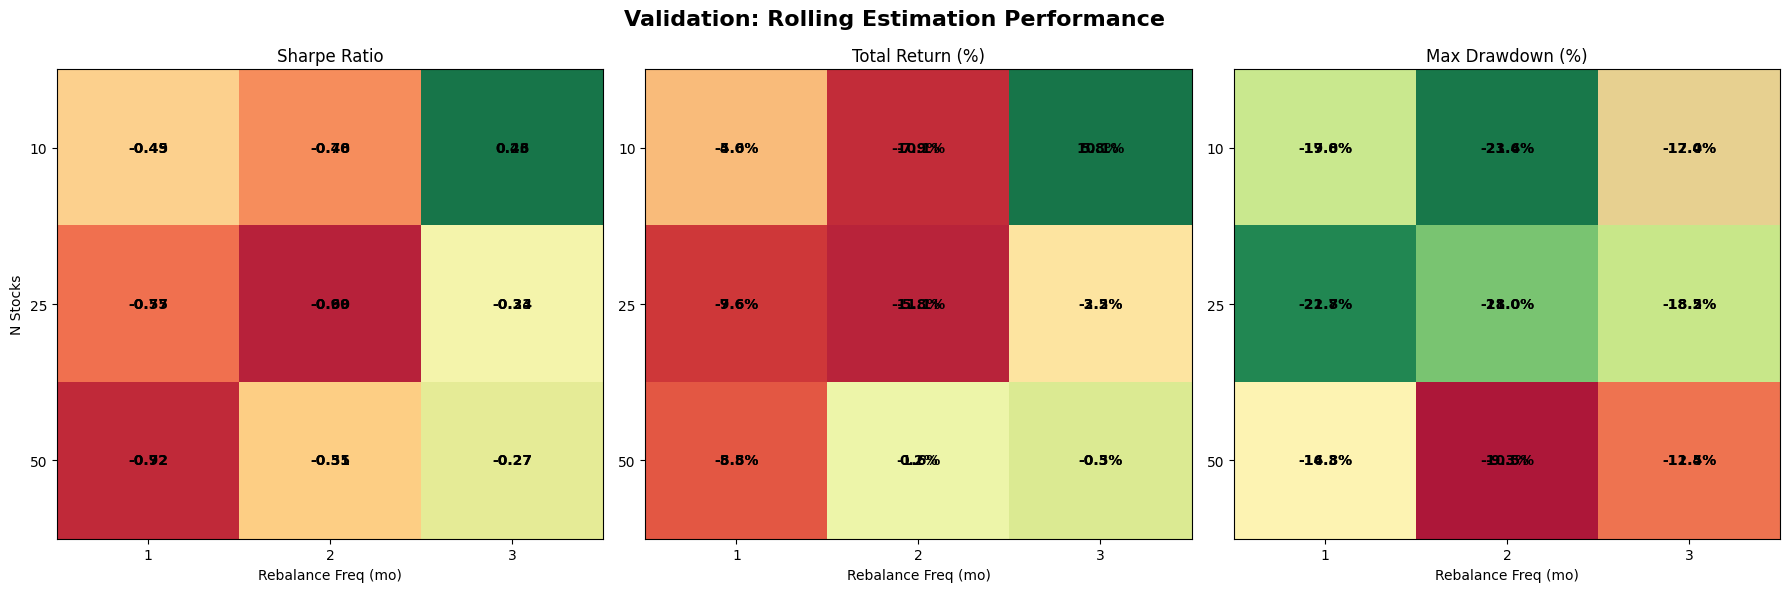


PART 5: FINAL TEST SET EVALUATION

📊 TEST SET PERFORMANCE:
   Periods: 24
   Total Return: -17.19%
   Annualized Return: -5.34%
   Annualized Volatility: 27.93%
   Sharpe Ratio: -0.337
   Sortino Ratio: -0.397
   Max Drawdown: -32.92%
   Win Rate: 54.2%

CORPORATE EVENTS (Delistings/Mergers)

Total stocks that disappeared: 6
  - From long positions: 3
  - From short positions: 3

Average last return before disappearance: 9.28%
(Negative = stocks crashed before delisting)

5 Worst disappearances (lowest returns):
  DVN        (short):   -1.89% on 2024-12-31
  NKE        (short):   -1.83% on 2024-05-31
  ILMN       (long ):   +2.71% on 2024-02-29
  TSLA       (long ):  +38.15% on 2024-12-31

Total disappearance events during test period: 6
Disappearance rate: 0.25 stocks per month

PORTFOLIO COMPOSITION STATISTICS

Average stocks per leg:
  Long:  9.9 (target: 10, min: 9)
  Short: 9.9 (target: 10, min: 9)

Percentage of periods with full target:
  Long:  87.5%
  Short: 87.5%


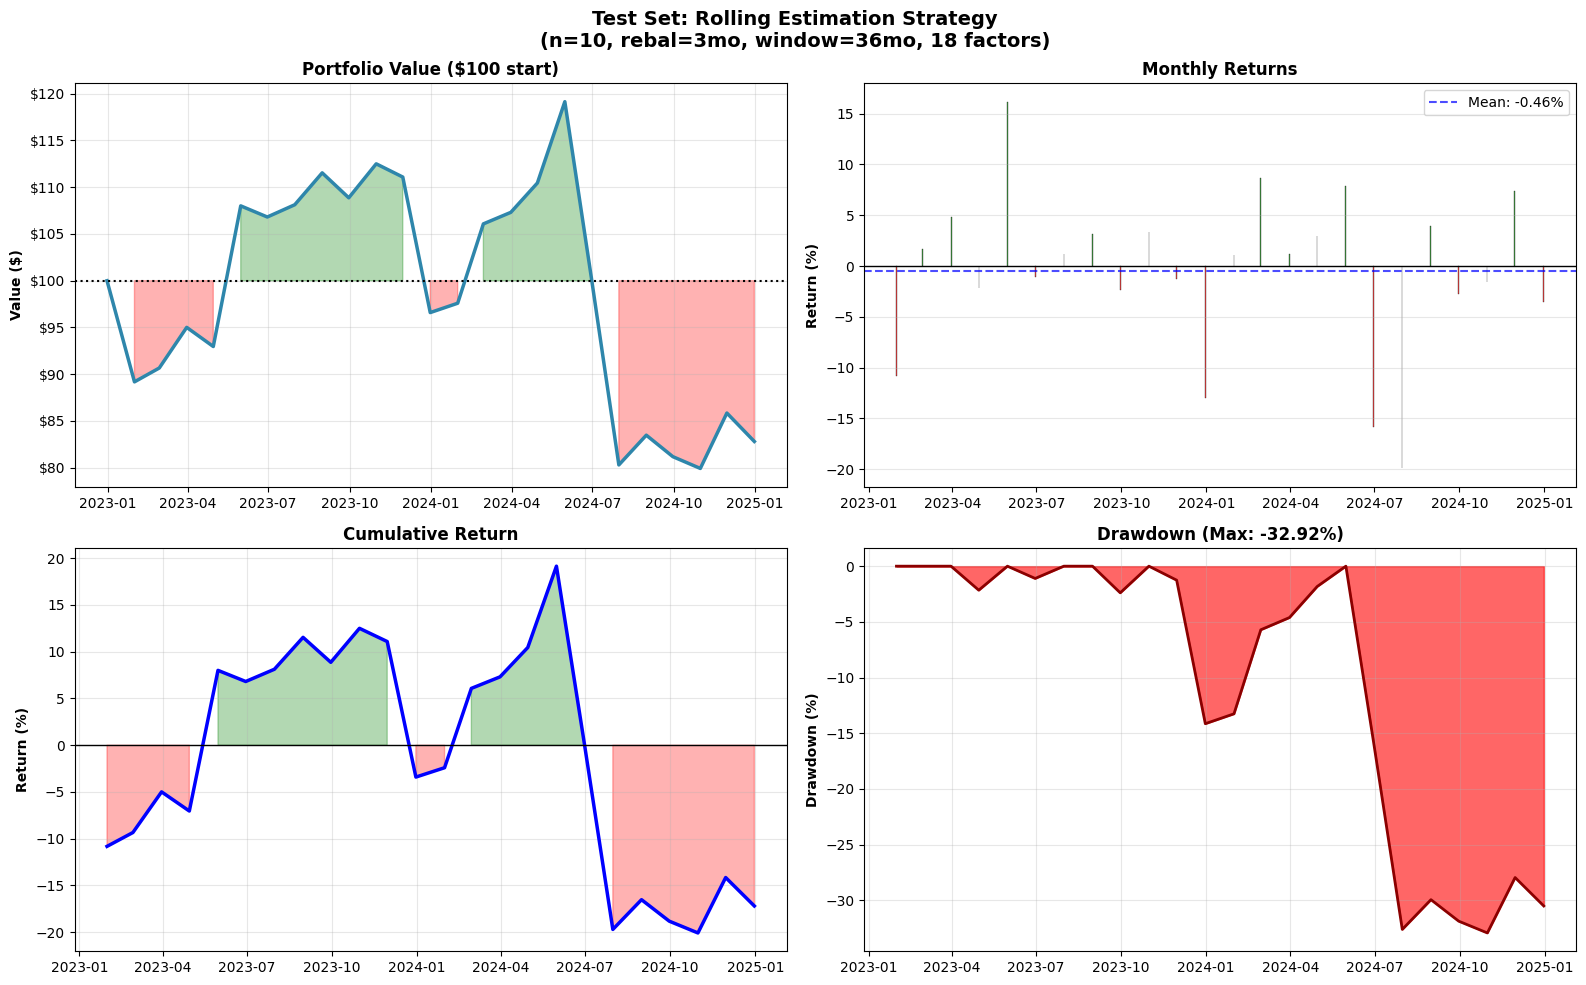


COEFFICIENT EVOLUTION OVER TIME

Coefficients were re-estimated 8 times during test period

Comparison: Initial (Training) vs Final (Test):
--------------------------------------------------------------------------------
Factor                         Initial (Train)    Final (Test)          Change
--------------------------------------------------------------------------------
vol_mom                               0.058335        0.062262       +0.003926
EMA_3                                 0.012150        0.007881       -0.004269
vol_3m                                0.003017        0.002553       -0.000464
rd_sale                              -0.001957       -0.000144       +0.001812
divyield                              0.001838        0.000079       -0.001759
volume                               -0.001248       -0.000474       +0.000773
debt_assets                          -0.001110       -0.000542       +0.000568
bm                                    0.001025        0.001085   

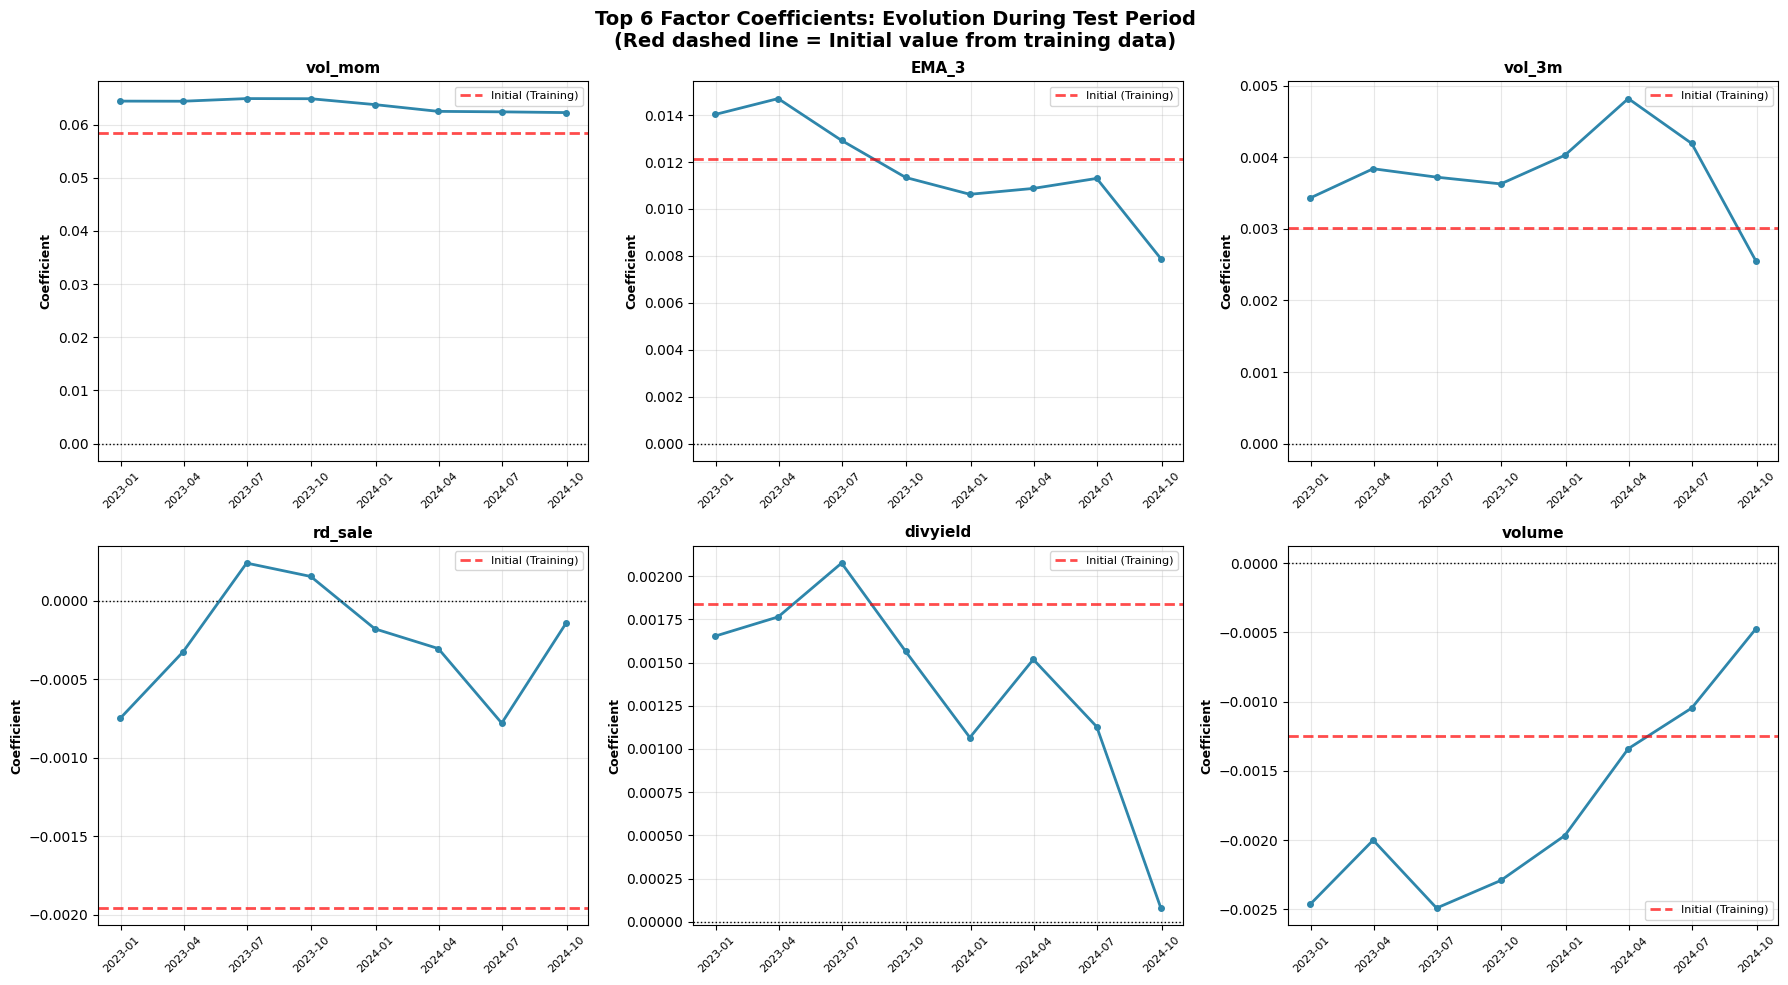


COEFFICIENT STABILITY METRICS

vol_mom:
  Mean: 0.063688
  Std:  0.001062
  Range: [0.062262, 0.064896]
  Coef. of Variation: 1.7%

EMA_3:
  Mean: 0.011711
  Std:  0.002021
  Range: [0.007881, 0.014706]
  Coef. of Variation: 17.3%

vol_3m:
  Mean: 0.003778
  Std:  0.000610
  Range: [0.002553, 0.004821]
  Coef. of Variation: 16.1%

rd_sale:
  Mean: -0.000260
  Std:  0.000346
  Range: [-0.000779, 0.000241]
  Coef. of Variation: 132.9%

divyield:
  Mean: 0.001356
  Std:  0.000571
  Range: [0.000079, 0.002076]
  Coef. of Variation: 42.1%

SUMMARY: Validation vs Test
Metric                           Validation         Test
-----------------------------------------------------------------
Annualized Return (%)                 14.45        -5.34
Annualized Volatility (%)             20.95        27.93
Sharpe Ratio                          0.460       -0.337
Sortino Ratio                         0.879       -0.397
Total Return (%)                      10.07       -17.19
Max Drawdown (%)      

In [371]:
# ========================================
# HYBRID LONG/SHORT STRATEGY:
# - ONE-TIME factor selection on training data
# - ROLLING estimation of loadings & premia
# ========================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# ========================================
# DATA PREPARATION
# ========================================

df = wrds_file.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'ticker'])
df = df.drop(columns=['price'], errors='ignore')

factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

print(f"Total factors: {len(factor_cols)}")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Split data
train_end = "2022-01-01"
val_end = "2022-12-31"

train = df[df['date'] < train_end]
val = df[(df['date'] >= train_end) & (df['date'] < val_end)]
test = df[df['date'] >= val_end]

print(f"\nTrain: {train.shape}")
print(f"Val: {val.shape}")
print(f"Test: {test.shape}")

risk_free_monthly = (1+0.04)**(1/12) - 1
print(f"\nRisk-free rate: {risk_free_monthly*100:.3f}% monthly")

# ========================================
# PART 1: ONE-TIME FACTOR SELECTION
# (Using only training data)
# ========================================

print("\n" + "="*60)
print("PART 1: INITIAL FACTOR SELECTION (Training Data Only)")
print("="*60)

# Step 1: Estimate alphas/betas on training data
print("\nStep 1: Time Series Regression (Alphas & Betas)")
alpha_dict_train = {}
beta_dict_train = {}
residuals_list = []

for ticker, grp in train.groupby('ticker'):
    grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
    if len(grp_clean) < 12:
        continue
    
    X = grp_clean[['market_ret']].values
    y = grp_clean['ret_1m'].values
    
    reg = LinearRegression().fit(X, y)
    alpha_dict_train[ticker] = reg.intercept_
    beta_dict_train[ticker] = reg.coef_[0]
    
    eps = y - reg.predict(X)
    tmp = grp_clean[['date', 'ticker']].copy()
    tmp['eps'] = eps
    residuals_list.append(tmp)

residuals_df = pd.concat(residuals_list, ignore_index=True)
train_with_eps = train.merge(residuals_df, on=['date', 'ticker'], how='left')

print(f"Estimated α/β for {len(alpha_dict_train)} stocks")

# Step 2: Cross-sectional regressions to get gamma time series
print("\nStep 2: Cross-Sectional Regression")
gamma_time_series = defaultdict(list)

for dt, grp in train_with_eps.groupby('date'):
    grp_clean = grp.dropna(subset=['eps'] + factor_cols)
    if len(grp_clean) < len(factor_cols) + 10:
        continue
    
    X_raw = grp_clean[factor_cols].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    if X_normalized.isnull().any().any():
        continue
    
    y = grp_clean['eps'].values
    reg = LinearRegression().fit(X_normalized.values, y)
    
    for i, fc in enumerate(factor_cols):
        gamma_time_series[fc].append(reg.coef_[i])

T = len(gamma_time_series[factor_cols[0]])
print(f"Cross-sectional regressions: {T} time periods")

# Step 3: Factor selection via t-statistics
print("\nStep 3: Factor Selection (t-statistics)")
t_stats = {}

for fc in factor_cols:
    arr = np.array(gamma_time_series[fc])
    gamma_mean = arr.mean()
    gamma_std = arr.std(ddof=1)
    t_stats[fc] = gamma_mean / (gamma_std / np.sqrt(T)) if gamma_std > 0 else 0

selected_factors = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]

print(f"\n✓ Selected {len(selected_factors)}/{len(factor_cols)} factors (|t-stat| > 1.96)")
print("\nTop 10 factors:")
for fc, tstat in sorted(t_stats.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
    mark = "✓" if fc in selected_factors else ""
    print(f"  {fc:30s}: {tstat:7.3f} {mark}")

# Calculate initial factor premia for selected factors
gamma_star_initial = defaultdict(list)
for dt, grp in train_with_eps.groupby('date'):
    grp_clean = grp.dropna(subset=['eps'] + selected_factors)
    if len(grp_clean) < len(selected_factors) + 10:
        continue
    
    X_raw = grp_clean[selected_factors].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    if X_normalized.isnull().any().any():
        continue
    
    y = grp_clean['eps'].values
    reg = LinearRegression().fit(X_normalized.values, y)
    
    for i, fc in enumerate(selected_factors):
        gamma_star_initial[fc].append(reg.coef_[i])

gamma_bar_initial = {fc: np.mean(gamma_star_initial[fc]) for fc in selected_factors}

print("\n" + "="*60)
print("INITIAL FACTOR PREMIA (Training Data Average)")
print("="*60)
for fc in sorted(gamma_bar_initial.keys(), key=lambda x: abs(gamma_bar_initial[x]), reverse=True):
    print(f"  {fc:30s}: {gamma_bar_initial[fc]:8.6f}")

# Visualize
sorted_items = sorted(t_stats.items(), key=lambda x: x[1])
factors_sorted = [item[0] for item in sorted_items]
values_sorted = [item[1] for item in sorted_items]

plt.figure(figsize=(12, 6))
colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
plt.title("Factor Selection: t-statistics on Training Data", fontsize=16, fontweight='bold')
plt.ylabel("t-statistic", fontsize=12)
plt.xlabel("Factors", fontsize=12)
plt.xticks(rotation=45, fontsize=6)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ========================================
# PART 2: ROLLING ESTIMATION FUNCTIONS
# (For validation and test periods)
# ========================================

def estimate_alphas_betas_rolling(data, min_periods=12):
    """Estimate α and β using available historical data"""
    alpha_dict = {}
    beta_dict = {}
    
    for ticker, grp in data.groupby('ticker'):
        grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
        if len(grp_clean) < min_periods:
            continue
        
        X = grp_clean[['market_ret']].values
        y = grp_clean['ret_1m'].values
        
        reg = LinearRegression().fit(X, y)
        alpha_dict[ticker] = reg.intercept_
        beta_dict[ticker] = reg.coef_[0]
    
    return alpha_dict, beta_dict

def compute_residuals_rolling(data, alpha_dict, beta_dict):
    """
    Compute residuals for given alphas/betas
    Only keeps stocks that have alpha/beta estimates
    """
    data = data.copy()
    data['alpha_i'] = data['ticker'].map(alpha_dict)
    data['beta_i'] = data['ticker'].map(beta_dict)
    
    # Only compute residuals for stocks with valid alpha/beta
    mask = data['alpha_i'].notna() & data['beta_i'].notna()
    data.loc[mask, 'eps'] = (data.loc[mask, 'ret_1m'] - 
                              data.loc[mask, 'alpha_i'] - 
                              data.loc[mask, 'beta_i'] * data.loc[mask, 'market_ret'])
    
    return data

def estimate_factor_premia_rolling(data, selected_factors, min_periods=12):
    """
    Estimate factor premia using cross-sectional regressions
    """
    gamma_time_series = defaultdict(list)
    
    for dt, grp in data.groupby('date'):
        grp_clean = grp.dropna(subset=['eps'] + selected_factors)
        if len(grp_clean) < len(selected_factors) + 10:
            continue
        
        X_raw = grp_clean[selected_factors].copy()
        X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
        
        if X_normalized.isnull().any().any():
            continue
        
        y = grp_clean['eps'].values
        reg = LinearRegression().fit(X_normalized.values, y)
        
        for i, fc in enumerate(selected_factors):
            gamma_time_series[fc].append(reg.coef_[i])
    
    if len(gamma_time_series.get(selected_factors[0], [])) < min_periods:
        return None
    
    gamma_bar = {fc: np.mean(gamma_time_series[fc]) for fc in selected_factors}
    return gamma_bar

# ========================================
# PART 3: ROLLING PORTFOLIO CONSTRUCTION
# ========================================

def build_portfolio_with_rolling_estimation(
    data, all_data, selected_factors, n_long, n_short, 
    rebalance_freq, training_window=36, risk_free_rate=0.0002,
    track_coefficients=False):
    """
    Build portfolio with rolling estimation of parameters
    """
    
    oos_data = data.copy().sort_values(['ticker', 'date'])
    all_dates = sorted(oos_data['date'].unique())
    
    portfolio_returns = []
    coefficient_history = [] if track_coefficients else None
    corporate_events = []
    current_long = None
    current_short = None
    months_held = 0
    
    for i in range(len(all_dates) - 1):
        current_date = all_dates[i]
        next_date = all_dates[i + 1]
        
        hist_data = all_data[all_data['date'] < current_date].copy()
        
        if training_window:
            earliest_date = current_date - pd.DateOffset(months=training_window)
            hist_data = hist_data[hist_data['date'] >= earliest_date]
        
        if len(hist_data['date'].unique()) < 24:
            continue
        
        grp_t = oos_data[oos_data['date'] == current_date].copy()
        grp_t1 = oos_data[oos_data['date'] == next_date].copy()
        
        if len(grp_t) < (n_long + n_short):
            continue
        
        should_rebalance = (current_long is None) or (months_held >= rebalance_freq)
        
        if should_rebalance:
            alpha_dict, beta_dict = estimate_alphas_betas_rolling(hist_data)
            hist_with_eps = compute_residuals_rolling(hist_data, alpha_dict, beta_dict)
            gamma_bar = estimate_factor_premia_rolling(hist_with_eps, selected_factors)
            
            if gamma_bar is None or len(alpha_dict) < 50:
                continue
            
            if track_coefficients:
                coef_record = {'date': current_date}
                coef_record.update(gamma_bar)
                coefficient_history.append(coef_record)
            
            for fc in factor_cols:
                if grp_t[fc].notna().sum() > 1:
                    grp_t[fc] = (grp_t[fc] - grp_t[fc].mean()) / grp_t[fc].std()
            
            grp_t['eps_pred'] = 0.0
            for fc in selected_factors:
                grp_t['eps_pred'] += grp_t[fc].fillna(0) * gamma_bar[fc]
            
            grp_t['alpha_i'] = grp_t['ticker'].map(alpha_dict)
            grp_t['beta_i'] = grp_t['ticker'].map(beta_dict)
            
            recent_market = hist_data.tail(12*100)['market_ret'].mean()
            grp_t['E_r_m'] = recent_market if not np.isnan(recent_market) else risk_free_rate
            
            grp_t['r_pred'] = (grp_t['alpha_i'].fillna(0) + 
                              grp_t['beta_i'].fillna(0) * grp_t['E_r_m'] + 
                              grp_t['eps_pred'])
            
            grp_t = grp_t.dropna(subset=['r_pred', 'alpha_i', 'beta_i'])
            
            if len(grp_t) < (n_long + n_short):
                continue
            
            grp_t = grp_t.sort_values('r_pred', ascending=False)
            
            candidate_long = grp_t.head(int(n_long * 1.5))['ticker'].tolist()
            candidate_short = grp_t.tail(int(n_short * 1.5))['ticker'].tolist()
            
            available_next = grp_t1['ticker'].tolist()
            current_long = [t for t in candidate_long if t in available_next][:n_long]
            current_short = [t for t in candidate_short if t in available_next][:n_short]
            
            months_held = 0
        
        available_tickers_t1 = set(grp_t1['ticker'].tolist())
        
        disappeared_long = [t for t in current_long if t not in available_tickers_t1]
        disappeared_short = [t for t in current_short if t not in available_tickers_t1]
        
        if disappeared_long or disappeared_short:
            for ticker in disappeared_long:
                last_return = all_data[(all_data['ticker'] == ticker) & 
                                      (all_data['date'] == current_date)]['ret_1m']
                corporate_events.append({
                    'date': next_date,
                    'ticker': ticker,
                    'side': 'long',
                    'last_return': last_return.iloc[0] if len(last_return) > 0 else np.nan
                })
            
            for ticker in disappeared_short:
                last_return = all_data[(all_data['ticker'] == ticker) & 
                                      (all_data['date'] == current_date)]['ret_1m']
                corporate_events.append({
                    'date': next_date,
                    'ticker': ticker,
                    'side': 'short',
                    'last_return': last_return.iloc[0] if len(last_return) > 0 else np.nan
                })
        
        long_rets = grp_t1[grp_t1['ticker'].isin(current_long)]['ret_1m']
        short_rets = grp_t1[grp_t1['ticker'].isin(current_short)]['ret_1m']
        
        long_survival_rate = len(long_rets) / len(current_long) if len(current_long) > 0 else 0
        short_survival_rate = len(short_rets) / len(current_short) if len(current_short) > 0 else 0
        
        if long_survival_rate < 0.7 or short_survival_rate < 0.7:
            current_long = None
            current_short = None
            months_held = 0
            continue
        
        if len(long_rets) < max(1, n_long // 2) or len(short_rets) < max(1, n_short // 2):
            current_long = None
            current_short = None
            months_held = 0
            continue
        
        long_ret = long_rets.mean()
        short_ret = short_rets.mean()
        ls_ret = long_ret - short_ret
        
        portfolio_returns.append({
            'formation_date': current_date,
            'return_date': next_date,
            'long_return': long_ret,
            'short_return': short_ret,
            'ls_return': ls_ret,
            'ls_excess': ls_ret - risk_free_rate,
            'market_return': grp_t1['market_ret'].mean(),
            'n_long': len(long_rets),
            'n_short': len(short_rets),
            'n_long_target': len(current_long),
            'n_short_target': len(current_short),
            'disappeared_long': len(disappeared_long),
            'disappeared_short': len(disappeared_short),
            'rebalanced': should_rebalance
        })
        
        months_held += 1
    
    result = pd.DataFrame(portfolio_returns)
    
    return_tuple = [result]
    if track_coefficients and coefficient_history:
        return_tuple.append(pd.DataFrame(coefficient_history))
    else:
        return_tuple.append(None)
    
    return_tuple.append(pd.DataFrame(corporate_events) if corporate_events else None)
    
    return tuple(return_tuple)

# ========================================
# PERFORMANCE METRICS (ENHANCED WITH VOLATILITY)
# ========================================

def calculate_metrics(portfolio_df, rf_rate):
    """Calculate comprehensive performance metrics including volatility"""
    if len(portfolio_df) == 0:
        return None
    
    rets = portfolio_df['ls_return']
    excess = rets - rf_rate
    
    # Annualized volatility
    ann_vol = rets.std() * np.sqrt(12)
    
    sharpe = (excess.mean() * 12) / (rets.std() * np.sqrt(12)) if rets.std() > 0 else 0
    
    downside = excess[excess < 0]
    sortino = ((excess.mean() * 12) / (downside.std() * np.sqrt(12)) 
               if len(downside) > 1 and downside.std() > 0 else 0)
    
    cum_ret = (1 + rets).prod() - 1
    cum_vals = (1 + rets).cumprod()
    running_max = cum_vals.expanding().max()
    max_dd = ((cum_vals - running_max) / running_max).min()
    
    return {
        'n_periods': len(rets),
        'total_return': cum_ret,
        'annualized_return': (1 + rets.mean())**12 - 1,
        'annualized_volatility': ann_vol,
        'sharpe': sharpe,
        'sortino': sortino,
        'max_drawdown': max_dd,
        'win_rate': (rets > 0).mean()
    }

# ========================================
# HYPERPARAMETER TUNING (VALIDATION)
# ========================================

print("\n" + "="*60)
print("PART 4: HYPERPARAMETER TUNING WITH ROLLING ESTIMATION")
print("="*60)

n_stocks_options = [10, 25, 50]
rebalance_options = [1, 2, 3]
window_options = [36, None]

tuning_results = []

for n_stocks, rebal, window in product(n_stocks_options, rebalance_options, window_options):
    window_str = f"{window}mo" if window else "expanding"
    print(f"\nTesting: n={n_stocks}, rebal={rebal}mo, window={window_str}")
    
    val_results = build_portfolio_with_rolling_estimation(
        data=val,
        all_data=df,
        selected_factors=selected_factors,
        n_long=n_stocks,
        n_short=n_stocks,
        rebalance_freq=rebal,
        training_window=window,
        risk_free_rate=risk_free_monthly
    )
    
    val_portfolio = val_results[0]
    
    if len(val_portfolio) == 0:
        print("  ⚠️  No results")
        continue
    
    perf = calculate_metrics(val_portfolio, risk_free_monthly)
    
    tuning_results.append({
        'n_stocks': n_stocks,
        'rebalance': rebal,
        'window': window_str,
        **perf
    })
    
    print(f"  Sharpe: {perf['sharpe']:.3f}, Return: {perf['total_return']*100:.2f}%, Vol: {perf['annualized_volatility']*100:.2f}%")

tuning_df = pd.DataFrame(tuning_results)

print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
print(tuning_df.to_string(index=False))

best_idx = tuning_df['sharpe'].idxmax()
best = tuning_df.iloc[best_idx]

print(f"\n🏆 BEST PARAMETERS:")
print(f"   n_stocks: {int(best['n_stocks'])}")
print(f"   rebalance: {int(best['rebalance'])} months")
print(f"   window: {best['window']}")
print(f"   Validation Sharpe: {best['sharpe']:.3f}")
print(f"   Validation Volatility: {best['annualized_volatility']*100:.2f}%")

# Visualize validation results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for window_val in tuning_df['window'].unique():
    subset = tuning_df[tuning_df['window'] == window_val]
    
    pivot = subset.pivot(index='n_stocks', columns='rebalance', values='sharpe')
    im = axes[0].imshow(pivot.values, cmap='RdYlGn', aspect='auto', alpha=0.7)
    axes[0].set_xticks(range(len(pivot.columns)))
    axes[0].set_yticks(range(len(pivot.index)))
    axes[0].set_xticklabels(pivot.columns)
    axes[0].set_yticklabels(pivot.index)
    axes[0].set_title('Sharpe Ratio')
    axes[0].set_xlabel('Rebalance Freq (mo)')
    axes[0].set_ylabel('N Stocks')
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            axes[0].text(j, i, f'{pivot.values[i, j]:.2f}',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
    pivot = subset.pivot(index='n_stocks', columns='rebalance', values='total_return')
    axes[1].imshow(pivot.values * 100, cmap='RdYlGn', aspect='auto', alpha=0.7)
    axes[1].set_xticks(range(len(pivot.columns)))
    axes[1].set_yticks(range(len(pivot.index)))
    axes[1].set_xticklabels(pivot.columns)
    axes[1].set_yticklabels(pivot.index)
    axes[1].set_title('Total Return (%)')
    axes[1].set_xlabel('Rebalance Freq (mo)')
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            axes[1].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)
    
    pivot = subset.pivot(index='n_stocks', columns='rebalance', values='max_drawdown')
    axes[2].imshow(pivot.values * 100, cmap='RdYlGn_r', aspect='auto', alpha=0.7)
    axes[2].set_xticks(range(len(pivot.columns)))
    axes[2].set_yticks(range(len(pivot.index)))
    axes[2].set_xticklabels(pivot.columns)
    axes[2].set_yticklabels(pivot.index)
    axes[2].set_title('Max Drawdown (%)')
    axes[2].set_xlabel('Rebalance Freq (mo)')
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            axes[2].text(j, i, f'{pivot.values[i, j]*100:.1f}%',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)

plt.suptitle('Validation: Rolling Estimation Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FINAL TEST
# ========================================

print("\n" + "="*60)
print("PART 5: FINAL TEST SET EVALUATION")
print("="*60)

best_window = None if best['window'] == 'expanding' else int(best['window'].replace('mo', ''))

test_results = build_portfolio_with_rolling_estimation(
    data=test,
    all_data=df,
    selected_factors=selected_factors,
    n_long=int(best['n_stocks']),
    n_short=int(best['n_stocks']),
    rebalance_freq=int(best['rebalance']),
    training_window=best_window,
    risk_free_rate=risk_free_monthly,
    track_coefficients=True
)

test_portfolio = test_results[0]
coef_history = test_results[1]
corporate_events_df = test_results[2]

if len(test_portfolio) > 0:
    test_perf = calculate_metrics(test_portfolio, risk_free_monthly)
    
    print(f"\n📊 TEST SET PERFORMANCE:")
    print(f"   Periods: {test_perf['n_periods']}")
    print(f"   Total Return: {test_perf['total_return']*100:.2f}%")
    print(f"   Annualized Return: {test_perf['annualized_return']*100:.2f}%")
    print(f"   Annualized Volatility: {test_perf['annualized_volatility']*100:.2f}%")
    print(f"   Sharpe Ratio: {test_perf['sharpe']:.3f}")
    print(f"   Sortino Ratio: {test_perf['sortino']:.3f}")
    print(f"   Max Drawdown: {test_perf['max_drawdown']*100:.2f}%")
    print(f"   Win Rate: {test_perf['win_rate']*100:.1f}%")
    
    # ========================================
    # CORPORATE EVENTS ANALYSIS
    # ========================================
    
    if corporate_events_df is not None and len(corporate_events_df) > 0:
        print("\n" + "="*60)
        print("CORPORATE EVENTS (Delistings/Mergers)")
        print("="*60)
        
        total_disappeared = len(corporate_events_df)
        long_disappeared = len(corporate_events_df[corporate_events_df['side'] == 'long'])
        short_disappeared = len(corporate_events_df[corporate_events_df['side'] == 'short'])
        
        print(f"\nTotal stocks that disappeared: {total_disappeared}")
        print(f"  - From long positions: {long_disappeared}")
        print(f"  - From short positions: {short_disappeared}")
        
        events_with_returns = corporate_events_df.dropna(subset=['last_return'])
        if len(events_with_returns) > 0:
            avg_return = events_with_returns['last_return'].mean()
            print(f"\nAverage last return before disappearance: {avg_return*100:.2f}%")
            print(f"(Negative = stocks crashed before delisting)")
            
            print("\n5 Worst disappearances (lowest returns):")
            worst = events_with_returns.nsmallest(5, 'last_return')
            for _, row in worst.iterrows():
                print(f"  {row['ticker']:10s} ({row['side']:5s}): {row['last_return']*100:+7.2f}% on {row['date'].date()}")
        
        disappeared_summary = test_portfolio[['return_date', 'disappeared_long', 'disappeared_short']].copy()
        disappeared_summary['total_disappeared'] = (disappeared_summary['disappeared_long'] + 
                                                   disappeared_summary['disappeared_short'])
        
        total_events = disappeared_summary['total_disappeared'].sum()
        if total_events > 0:
            print(f"\nTotal disappearance events during test period: {int(total_events)}")
            print(f"Disappearance rate: {total_events / len(test_portfolio):.2f} stocks per month")
    
    # Portfolio composition statistics
    print("\n" + "="*60)
    print("PORTFOLIO COMPOSITION STATISTICS")
    print("="*60)
    
    avg_long = test_portfolio['n_long'].mean()
    avg_short = test_portfolio['n_short'].mean()
    min_long = test_portfolio['n_long'].min()
    min_short = test_portfolio['n_short'].min()
    
    print(f"\nAverage stocks per leg:")
    print(f"  Long:  {avg_long:.1f} (target: {int(best['n_stocks'])}, min: {int(min_long)})")
    print(f"  Short: {avg_short:.1f} (target: {int(best['n_stocks'])}, min: {int(min_short)})")
    
    target_long = test_portfolio['n_long_target'].iloc[0] if 'n_long_target' in test_portfolio.columns else int(best['n_stocks'])
    pct_full_long = (test_portfolio['n_long'] == target_long).mean() * 100
    pct_full_short = (test_portfolio['n_short'] == target_long).mean() * 100
    
    print(f"\nPercentage of periods with full target:")
    print(f"  Long:  {pct_full_long:.1f}%")
    print(f"  Short: {pct_full_short:.1f}%")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    cum_ret = 100 * (1 + test_portfolio['ls_return']).cumprod()
    dates_plot = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
    values_plot = [100] + cum_ret.tolist()
    
    axes[0,0].plot(dates_plot, values_plot, linewidth=2.5, color='#2E86AB')
    axes[0,0].axhline(100, color='black', linestyle=':', linewidth=1.5)
    axes[0,0].set_title('Portfolio Value ($100 start)', fontweight='bold', fontsize=12)
    axes[0,0].set_ylabel('Value ($)', fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].fill_between(dates_plot, 100, values_plot,
                           where=(np.array(values_plot) >= 100), alpha=0.3, color='green')
    axes[0,0].fill_between(dates_plot, 100, values_plot,
                           where=(np.array(values_plot) < 100), alpha=0.3, color='red')
    axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))
    
    colors = ['g' if x > 0 else 'r' for x in test_portfolio['ls_return']]
    axes[0,1].bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
                  color=colors, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[0,1].axhline(0, color='black', linewidth=1)
    axes[0,1].axhline(test_portfolio['ls_return'].mean()*100, 
                      color='blue', linestyle='--', linewidth=1.5, alpha=0.7,
                      label=f'Mean: {test_portfolio["ls_return"].mean()*100:.2f}%')
    axes[0,1].set_title('Monthly Returns', fontweight='bold', fontsize=12)
    axes[0,1].set_ylabel('Return (%)', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3, axis='y')
    
    axes[1,0].plot(test_portfolio['return_date'], 
                   (cum_ret/100 - 1) * 100, linewidth=2.5, color='blue')
    axes[1,0].axhline(0, color='black', linewidth=1)
    axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
                           where=((cum_ret/100 - 1) * 100 >= 0), alpha=0.3, color='green')
    axes[1,0].fill_between(test_portfolio['return_date'], 0, (cum_ret/100 - 1) * 100,
                           where=((cum_ret/100 - 1) * 100 < 0), alpha=0.3, color='red')
    axes[1,0].set_title('Cumulative Return', fontweight='bold', fontsize=12)
    axes[1,0].set_ylabel('Return (%)', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    running_max = cum_ret.expanding().max()
    dd = (cum_ret - running_max) / running_max * 100
    axes[1,1].fill_between(test_portfolio['return_date'], 0, dd, 
                           color='red', alpha=0.6)
    axes[1,1].plot(test_portfolio['return_date'], dd, linewidth=2, color='darkred')
    axes[1,1].set_title(f'Drawdown (Max: {dd.min():.2f}%)', fontweight='bold', fontsize=12)
    axes[1,1].set_ylabel('Drawdown (%)', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Test Set: Rolling Estimation Strategy\n' +
                 f'(n={int(best["n_stocks"])}, rebal={int(best["rebalance"])}mo, ' +
                 f'window={best["window"]}, {len(selected_factors)} factors)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # VISUALIZE COEFFICIENT EVOLUTION
    # ========================================
    
    if coef_history is not None and len(coef_history) > 0:
        print("\n" + "="*60)
        print("COEFFICIENT EVOLUTION OVER TIME")
        print("="*60)
        
        print(f"\nCoefficients were re-estimated {len(coef_history)} times during test period")
        print("\nComparison: Initial (Training) vs Final (Test):")
        print("-" * 80)
        print(f"{'Factor':<30} {'Initial (Train)':>15} {'Final (Test)':>15} {'Change':>15}")
        print("-" * 80)
        
        for fc in sorted(selected_factors, key=lambda x: abs(gamma_bar_initial.get(x, 0)), reverse=True)[:10]:
            initial_val = gamma_bar_initial.get(fc, 0)
            final_val = coef_history[fc].iloc[-1] if fc in coef_history.columns else 0
            change = final_val - initial_val
            print(f"{fc:<30} {initial_val:>15.6f} {final_val:>15.6f} {change:>+15.6f}")
        
        top_factors = sorted(selected_factors, 
                           key=lambda x: abs(gamma_bar_initial.get(x, 0)), 
                           reverse=True)[:6]
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for idx, fc in enumerate(top_factors):
            if fc in coef_history.columns:
                ax = axes[idx]
                ax.plot(coef_history['date'], coef_history[fc], 
                       linewidth=2, marker='o', markersize=4, color='#2E86AB')
                ax.axhline(gamma_bar_initial[fc], color='red', linestyle='--', 
                          linewidth=2, alpha=0.7, label='Initial (Training)')
                ax.axhline(0, color='black', linestyle=':', linewidth=1)
                ax.set_title(f'{fc}', fontweight='bold', fontsize=11)
                ax.set_ylabel('Coefficient', fontweight='bold', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=8)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
        
        plt.suptitle('Top 6 Factor Coefficients: Evolution During Test Period\n' + 
                    '(Red dashed line = Initial value from training data)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*60)
        print("COEFFICIENT STABILITY METRICS")
        print("="*60)
        
        for fc in top_factors[:5]:
            if fc in coef_history.columns:
                vals = coef_history[fc].values
                mean_val = np.mean(vals)
                std_val = np.std(vals)
                min_val = np.min(vals)
                max_val = np.max(vals)
                cv = (std_val / abs(mean_val)) * 100 if mean_val != 0 else np.inf
                
                print(f"\n{fc}:")
                print(f"  Mean: {mean_val:8.6f}")
                print(f"  Std:  {std_val:8.6f}")
                print(f"  Range: [{min_val:8.6f}, {max_val:8.6f}]")
                print(f"  Coef. of Variation: {cv:.1f}%")
    
    print("\n" + "="*60)
    print("SUMMARY: Validation vs Test")
    print("="*60)
    print(f"{'Metric':<30} {'Validation':>12} {'Test':>12}")
    print("-" * 65)
    print(f"{'Annualized Return (%)':<30} {best['annualized_return']*100:>12.2f} {test_perf['annualized_return']*100:>12.2f}")
    print(f"{'Annualized Volatility (%)':<30} {best['annualized_volatility']*100:>12.2f} {test_perf['annualized_volatility']*100:>12.2f}")
    print(f"{'Sharpe Ratio':<30} {best['sharpe']:>12.3f} {test_perf['sharpe']:>12.3f}")
    print(f"{'Sortino Ratio':<30} {best['sortino']:>12.3f} {test_perf['sortino']:>12.3f}")
    print(f"{'Total Return (%)':<30} {best['total_return']*100:>12.2f} {test_perf['total_return']*100:>12.2f}")
    print(f"{'Max Drawdown (%)':<30} {best['max_drawdown']*100:>12.2f} {test_perf['max_drawdown']*100:>12.2f}")
    print(f"{'Win Rate (%)':<30} {best['win_rate']*100:>12.1f} {test_perf['win_rate']*100:>12.1f}")
    
else:
    print("❌ No test results generated")

print("\n✅ ANALYSIS COMPLETE")
print("\n📋 METHODOLOGY SUMMARY:")
print("  1. Factor selection: ONE-TIME on training data (2015-2022)")
print(f"     - Started with {len(factor_cols)} factors")
print(f"     - Selected {len(selected_factors)} significant factors (|t-stat| > 1.96)")
print("  2. Parameter estimation: ROLLING on historical data only")
print("     - Alpha/Beta re-estimated at each rebalancing")
print("     - Factor premia re-estimated using ONLY selected factors")
print("  3. No look-ahead bias: All predictions use only past information")
print("  4. Proper Fama-MacBeth: Regressions use ONLY selected factors, not all factors")